In [2]:
# Python packages and utilities
import os
import sys
from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import display, HTML

try:
    import mlxtend
except ModuleNotFoundError:
    !pip install mlxtend

#RDKit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs

# Mordred
try:
    import mordred
    from mordred import Calculator, descriptors
except ModuleNotFoundError:
    !pip install 'mordred[full]'
    import mordred
    from mordred import Calculator, descriptors
    

# scikit-learn
try:
    import sklearn
except ModuleNotFoundError:
    !pip install -U scikit-learn
    import sklearn
    
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.feature_selection import RFECV, RFE
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#imbalanced learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
except ModuleNotFoundError:
    !pip install -U imbalanced-learn
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN

# seaborn
try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt

#PIL
from PIL import Image

# scikitplot library
try:
    import scikitplot as skplt
except ModuleNotFoundError:
    !pip install scikit-plot
    import scikitplot as skplt

!pip install pip install -U imbalanced-learn

# own module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pythia import classification_metrics as cmetrics
from pythia import fingerprints_generation as fp
from pythia import molecules_and_structures as mi
from pythia import plots as pltsk
from pythia import workflow_functions as cwf

# utility
%load_ext autoreload
%autoreload 2
%aimport
import importlib


import logging 
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)


random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


Random seed fixed as 10459


Modules to reload:
all-except-skipped

Modules to skip:



# Load target data

First we read the dataset from a csv file. A csv file is a comma separated file, where each row is a data point.

`pd.read_csv()` is used to read the input csv file that contain the dataset. The dataset is stored in a dataframe, which is a data structure provided by the pandas library. A dataframe is a two-dimensional data structure, i.e. data is aligned in a tabular fashion in rows and columns. The dataframe can be indexed by column names.

Here, we also reformat the column names to replace spaces with underscores and make the column names all lower case. This is done to make it easier to work with the data.

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)

In [3]:
data = pd.read_csv("First_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [4]:
log.info("Columns: {}".format(data.columns))

Columns: Index(['reaction', 'substrate', 'catalyst', 'solvent', 'solvent_code',
       'temperature', 'ee', 'ddg', 'paper'],
      dtype='object')


In [5]:
data

reaction                                    substrate  \
0           0       CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
1           1  C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3   
2           2       CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
3           3  C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3   
4           4       CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
..        ...                                          ...   
114       114                      C=CC/N=C(C)/C1=CC=CC=C1   
115       115       CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
116       116  C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3   
117       117              C/C(C1=CC=CC=C1)=N\CC2=CC=CC=C2   
118       118                      C=CC/N=C(C)/C1=CC=CC=C1   

                                              catalyst  solvent  solvent_code  \
0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...  toluene             0   
1    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...  toluene             0   
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
..                                                 ...      ...           ...   
114  CN(C([C@H](NC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1...  toluene             0   
115  [H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...  toluene             0   
116  [H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...  toluene             0   
117  [H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...  toluene             0   
118  [H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...  toluene             0   

     temperature  ee       ddg           paper  
0          -30.0  14  0.569810     Nature 2009  
1          -30.0  41  1.761325     Nature 2009  
2          -30.0  30  1.251493     Nature 2009  
3          -30.0  86  5.229434     Nature 2009  
4          -30.0  58  2.678563     Nature 2009  
..           ...  ..       ...             ...  
114        -75.0   0  0.000000  0ee - manually  
115        -30.0   0  0.000000  0ee - manually  
116        -30.0   0  0.000000  0ee - manually  
117        -75.0   0  0.000000  0ee - manually  
118        -75.0   0  0.000000  0ee - manually  

[119 rows x 9 columns]

# Set Target Properties

Here we define the input column and the target column. 

In chemistry, we usually use SMILES to represent molecules. SMILES is a string representation of a molecule. These SMILES strings should be obtained during data collection. Here we define the column name that contains the SMILES strings. 

The target values are the values that we want to predict. In this case, the target column is the column that contains the ddg values.

In [6]:
substratesmiles = data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles.head()))

catalystsmiles = data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles.head()))

reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

ddg = data["ddg"]
log.info("DGG: {}".format(ddg.head()))

Substrate SMILES: 0         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
1    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
2         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
3    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
4         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
1    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
Name: catalyst, dtype: object
Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64
DGG: 0    0.569810
1    1.761325
2    1.251493
3    5.229434
4    2.678563
Name: ddg, dtype: float64


In [7]:
targets = ddg

# Generate Mordred Descriptors as Features

We first convert the SMILES strings into RDKit molecules. RDKit is a cheminformatics software that can be used to manipulate molecules. 

Then we use the `Mordred` library to calculate the molecular descriptors. Mordred is a python library that can be used to calculate molecular descriptors. They include 1D, 2D and 3D descriptors. Examples of 1D descriptors are molecular weight, number of hydrogen bond donors, number of hydrogen bond acceptors, etc. Examples of 2D descriptors are number of rings, number of rotatable bonds, etc. Examples of 3D descriptors are molecular surface area, molecular volume, etc. Here we do not use 3D descriptors because they are computationally expensive to calculate.

Here we do the process once for the substrates and once for the catalysts. Then we conctainate the two. If you have once molecule you do not have to do this

In [9]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list = [mi.get_mol_from_smiles(s) for s in substratesmiles]
subfeatures_df = calc.pandas(submolecule_list)

100%|██████████| 119/119 [00:16<00:00,  7.10it/s]


In [10]:
subbackup_feature_df = subfeatures_df.copy()
#features_df = backup_feature_df

`dataframe.dropna()` is used to remove rows with missing values. Here we remove rows with missing values in the target column with a threshold of 0.9 * number of rows. This means that if a row has more than 90% missing values, it will be removed. Then we also dropped the rows with a standard deviation that is less than 0.5. This is done to remove features that have little variance.

In [11]:
subfeatures_df.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df.index)))
threshold = 0.5
subfeatures_df.drop(subfeatures_df.std()[subfeatures_df.std() < threshold].index.values, axis=1)
subfeatures_df.columns = [ent.strip() for ent in subfeatures_df.columns]
subfeatures_df.head()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  Zagreb2  \
0  14.538011  12.482550      0      0  23.734067  ...    24     94.0    104.0   
1  16.182576  12.923224      0      0  28.376768  ...    28    104.0    118.0   
2  14.538011  12.482550      0      0  23.734067  ...    24     94.0    104.0   
3  16.182576  12.923224      0      0  28.376768  ...    28    104.0    118.0   
4  14.538011  12.482550      0      0  23.734067  ...    24     94.0    104.0   

   mZagreb1  mZagreb2  
0  6.395833  4.180556  
1  4.694444  4.805556  
2  6.395833  4.180556  
3  4.694444  4.805556  
4  6.395833  4.180556  

[5 rows x 1826 columns]

Then we define the types of the features. Categorial features are features that have a finite set of possible values. For example, the feature 'number of rings' can only take integer values. Continuous features are features that can take any value. For example, the feature 'molecular weight' can take any value. Here, we have both categorical and continuous features, so we choose 'some_categorical' as the type.

In [12]:
log.info(subfeatures_df)
subfeature_types = "some_categorical" # other options 'some_categorical', 'no_categorical'

           ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  \
0    14.538011  12.482550      0      0  23.734067  ...    24     94.0   
1    16.182576  12.923224      0      0  28.376768  ...    28    104.0   
2    14.538011  12.482550      0      0  23.734067  ...    24     94.0   
3    16.182576  12.923224      0      0  28.376768  ...    28    104.0   
4    14.538011  12.482550      0      0  23.734067  ...    24     94.0   
..         ...        ...    ...    ...        ...  ...   ...      ...   
114   8.554231   7.960160      0      0  15.368571  ...    13     52.0   
115  14.538011  12.482550      0      0  23.734067  ...    24     94.0   
116  16.182576  12.923224      0      0  28.376768  ...    28    104.0   
117  12.089765  10.061032      0      0  21.313564  ...    19     76.0   
118   8.554231   7.960160      0      0  15.368571  ...    13     52.0   

     Zagreb2  mZagreb1  mZagreb2  
0      104.0  6.395833  4.180556  
1      118.0  4.694444  4.805556  
2     

In [13]:
# Mordred for catalysts

In [14]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list = [mi.get_mol_from_smiles(s) for s in catalystsmiles]
catfeatures_df = calc.pandas(catmolecule_list)

100%|██████████| 119/119 [00:35<00:00,  3.33it/s]


In [15]:
catbackup_feature_df = catfeatures_df.copy()

In [16]:
catfeatures_df.dropna(inplace=True, thresh=int(0.9*len(catfeatures_df.index)))
threshold = 0.5
catfeatures_df.drop(catfeatures_df.std()[catfeatures_df.std() < threshold].index.values, axis=1)
catfeatures_df.columns = [ent.strip() for ent in catfeatures_df.columns]
catfeatures_df.head()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  Zagreb2  \
0  21.401108  19.292802      0      0  30.867985  ...    43    144.0    162.0   
1  21.401108  19.292802      0      0  30.867985  ...    43    144.0    162.0   
2  26.241465  22.162609      0      0  39.436111  ...    52    176.0    199.0   
3  26.241465  22.162609      0      0  39.436111  ...    52    176.0    199.0   
4  26.977082  23.080194      0      0  40.925850  ...    56    182.0    208.0   

    mZagreb1  mZagreb2  
0  15.215278  5.722222  
1  15.215278  5.722222  
2  15.826389  7.055556  
3  15.826389  7.055556  
4  16.687500  7.277778  

[5 rows x 1826 columns]

In [17]:
log.info(catfeatures_df)
catfeature_types = "some_categorical" 

           ABC      ABCGG  nAcid  nBase    SpAbs_A  ...  WPol  Zagreb1  \
0    21.401108  19.292802      0      0  30.867985  ...    43    144.0   
1    21.401108  19.292802      0      0  30.867985  ...    43    144.0   
2    26.241465  22.162609      0      0  39.436111  ...    52    176.0   
3    26.241465  22.162609      0      0  39.436111  ...    52    176.0   
4    26.977082  23.080194      0      0  40.925850  ...    56    182.0   
..         ...        ...    ...    ...        ...  ...   ...      ...   
114  21.401108  19.292802      0      0  30.867985  ...    43    144.0   
115  16.714811  14.859531      0      0  24.619317  ...    30    110.0   
116  16.714811  14.859531      0      0  24.619317  ...    30    110.0   
117  16.714811  14.859531      0      0  24.619317  ...    30    110.0   
118  16.714811  14.859531      0      0  24.619317  ...    30    110.0   

     Zagreb2   mZagreb1  mZagreb2  
0      162.0  15.215278  5.722222  
1      162.0  15.215278  5.722222  
2  


# Pearson correlation coefficent and Spearman's rank correlation coefficient
In the next cells we can investigate how well each bit correlates against our property of interest and checks for signficance using a one tail permutation test: how many times out of the n_sample do I obtain a correlation coefficient that is greater than the observed value.


In the next block the feature with a reasonable correlation and statistically significant are chosen. The `sig_metric` is the significance testing metric correlation coefficent names are two tail p tests. to do one tail enter replacing option with `gt` for greater than and `lt` for less than and the correction coefficent name one of `pearsron`, `spearman` or `kendalltau`, `onetail_$option_$correlation_coefficent`.

If you don't how to choose between pearson, spearman or kendalltau, please have a read in the literature as this will depend on the type of data you have. Usually pearson is used for continuous data whereas spearman for discrete

In [18]:
subreasonable_predicted_properties, subsignificant_fearures = cwf.find_correlating_features(subfeatures_df, targets, thresh=0.38, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0      0.569810
1      1.761325
2      1.251493
3      5.229434
4      2.678563
         ...   
114    0.000000
115    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: ddg, Length: 119, dtype: float64
Significance will be calculated for the correlations
GATS3c: -0.4557 P: 0.0002 Significant at 0.0500 level? True
GATS3se: -0.4813 P: 0.0002 Significant at 0.0500 level? True
GATS3pe: -0.4114 P: 0.0002 Significant at 0.0500 level? True
GATS3are: -0.4403 P: 0.0002 Significant at 0.0500 level? True


In [19]:
log.info("{} {}".format(subreasonable_predicted_properties, len(subreasonable_predicted_properties)))
log.info("{} {}".format(subsignificant_fearures, len(subsignificant_fearures)))
use_significant = True
use_reasonable = False

['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are'] 4
['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are'] 4


In [20]:
catreasonable_predicted_properties, catsignificant_fearures = cwf.find_correlating_features(catfeatures_df, targets, thresh=0.60, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0      0.569810
1      1.761325
2      1.251493
3      5.229434
4      2.678563
         ...   
114    0.000000
115    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: ddg, Length: 119, dtype: float64
Significance will be calculated for the correlations
VE3_A: 0.6258 P: 0.0002 Significant at 0.0500 level? True
ATS5Z: 0.6387 P: 0.0002 Significant at 0.0500 level? True
ATS5m: 0.6029 P: 0.0002 Significant at 0.0500 level? True
ATS5v: 0.6275 P: 0.0002 Significant at 0.0500 level? True
ATS6v: 0.6314 P: 0.0002 Significant at 0.0500 level? True
ATS6se: 0.6497 P: 0.0002 Significant at 0.0500 level? True
ATS7se: 0.6010 P: 0.0002 Significant at 0.0500 level? True
ATS6pe: 0.6526 P: 0.0002 Significant at 0.0500 level? True
ATS6are: 0.6521 P: 0.0002 Significant at 0.0500 level? True
ATS5p: 0.6058 P: 0.0002 Significant at 0.0500 level? True
ATS6p: 0.6368 P: 0.0002 Significant at 0.0500 level? True
ATS6i: 0.6498 P: 0.0002 Significant at 0.0500 level? True
ATS7i: 0.6109 P: 0.0002 Signifi

In [21]:
log.info("{} {}".format(catreasonable_predicted_properties, len(catreasonable_predicted_properties)))
log.info("{} {}".format(catsignificant_fearures, len(catsignificant_fearures)))
use_significant = True
use_reasonable = False

['VE3_A', 'ATS5Z', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe', 'ATS6are', 'ATS5p', 'ATS6p', 'ATS6i', 'ATS7i', 'ATSC3se', 'ATSC3are', 'PEOE_VSA6', 'GGI6'] 17
['VE3_A', 'ATS5Z', 'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe', 'ATS6are', 'ATS5p', 'ATS6p', 'ATS6i', 'ATS7i', 'ATSC3se', 'ATSC3are', 'PEOE_VSA6', 'GGI6'] 17


In [22]:
subfeats_df = pd.DataFrame()

if use_significant is True:
    for k in subsignificant_fearures:
        subfeats_df[k] = subfeatures_df[k]
        
elif use_reasonable is True:
    for k in subreasonable_predicted_properties:
        subfeats_df[k] = subfeatures_df[k]

In [23]:
catfeats_df = pd.DataFrame()

if use_significant is True:
    for k in catsignificant_fearures:
        catfeats_df[k] = catfeatures_df[k]
        
elif use_reasonable is True:
    for k in catreasonable_predicted_properties:
        catfeats_df[k] = catfeatures_df[k]

In [24]:
features_df = subfeats_df.join(catfeats_df, lsuffix="subfeats_df", rsuffix="catfeats_df")

In [25]:
features_df

GATS3c   GATS3se   GATS3pe  GATS3are     VE3_A  ...         ATS7i  \
0    1.101164  1.187627  1.169919  1.166806  2.513060  ...  22590.015536   
1    0.981164  1.031415  0.978073  0.989808  2.513060  ...  22590.015536   
2    1.101164  1.187627  1.169919  1.166806  2.757223  ...  28356.636657   
3    0.981164  1.031415  0.978073  0.989808  2.757223  ...  28356.636657   
4    1.101164  1.187627  1.169919  1.166806  2.856647  ...  30959.251213   
..        ...       ...       ...       ...       ...  ...           ...   
114  1.306779  1.612830  1.359694  1.462054  2.513060  ...  22590.015536   
115  1.101164  1.187627  1.169919  1.166806  2.138716  ...   7002.700761   
116  0.981164  1.031415  0.978073  0.989808  2.138716  ...   7002.700761   
117  1.250566  1.431267  1.258747  1.323399  2.138716  ...   7002.700761   
118  1.306779  1.612830  1.359694  1.462054  2.138716  ...   7002.700761   

      ATSC3se  ATSC3are  PEOE_VSA6      GGI6  
0   -0.230044 -0.103049  20.771212  0.835102  
1   -0.230044 -0.103049  20.771212  0.835102  
2    0.109333  0.501976  51.103047  1.161633  
3    0.109333  0.501976  51.103047  1.161633  
4   -0.078909  0.175383  51.103047  1.243265  
..        ...       ...        ...       ...  
114 -0.230044 -0.103049  20.771212  0.835102  
115 -1.562365 -1.940117   0.000000  0.671837  
116 -1.562365 -1.940117   0.000000  0.671837  
117 -1.562365 -1.940117   0.000000  0.671837  
118 -1.562365 -1.940117   0.000000  0.671837  

[119 rows x 21 columns]

# Classify Molecules
We use these next cells to classify the ddg values into 'good' and 'bad' in terms of ddg kJ/mol. Because the ddg values are continuous, we need to define a threshold value to separate the 'good' and 'bad' molecules. Here we define the threshold value as 4. If the target value is lower than the threshold value, we assign the class label 'class 0', which means the molecule is 'bad'. If the target value is higher than the threshold value or absent, we assign the class label 'class 1', which means the molecule is 'good'.

Note that how to define the class labels depends on the problem. For example, if we want to predict whether a molecule is toxic or not, we can define a threshold value and assign the class labels accordingly. 

In [26]:
classes=[]
for index, value in ddg.items():
    if value < 4:
        classes.append(0)
    else:
        classes.append(1)

In [27]:
classes
class_targets_df = pd.DataFrame(np.array([classes]).T, columns=["classes"])
features_and_classes_df = features_df.copy()
features_and_classes_df["classes"] = classes

# Feature exploration
In the section we explore the features and their relationships. 
We classify the ddg into 'good' and 'bad'. To visualize all of these structure set show to True.

In [28]:
pd.set_option('display.max_columns', len(features_df.columns))
features_df.describe()

GATS3c     GATS3se     GATS3pe    GATS3are       VE3_A  \
count  119.000000  119.000000  119.000000  119.000000  119.000000   
mean     1.039625    1.127619    1.088098    1.100294    2.897151   
std      0.153986    0.223764    0.172929    0.192380    0.239249   
min      0.751475    0.497034    0.510248    0.500853    2.138716   
25%      0.955798    1.018107    0.978073    0.989808    2.817286   
50%      1.023688    1.136662    1.089701    1.104697    3.011422   
75%      1.101164    1.187627    1.169919    1.166806    3.064137   
max      1.495364    1.744208    1.489049    1.592949    3.116852   

             ATS5Z         ATS5m         ATS5v         ATS6v       ATS6se  \
count   119.000000    119.000000    119.000000    119.000000   119.000000   
mean   3842.361345  14164.961465  35412.432235  36189.119287  1641.107280   
std     645.025472   2291.173746   8706.076715   9849.134963   398.391850   
min    1992.000000   7945.773694  11967.479765  10656.801016   567.809490   
25%    3488.000000  13035.651149  31180.594742  30949.042524  1493.323210   
50%    3891.000000  13986.347236  39537.363935  41046.436724  1830.262018   
75%    4315.000000  15392.622928  41504.320794  43299.754273  1961.626346   
max    4469.000000  16828.947682  43113.080733  44658.369232  1992.660968   

            ATS7se       ATS6pe      ATS6are       ATS5p       ATS6p  \
count   119.000000   119.000000   119.000000  119.000000  119.000000   
mean   1660.058729  1341.036294  1328.488277  257.884699  273.908619   
std     535.679456   309.113867   300.542924   70.266693   80.424848   
min     357.483924   498.050600   506.498000   73.748680   65.160487   
25%    1416.097368  1215.578800  1201.261000  224.806318  234.013724   
50%    1780.464856  1509.697100  1498.140000  280.603473  307.741429   
75%    2172.521328  1572.098000  1545.679000  302.769649  323.315688   
max    2185.382372  1605.165000  1586.277000  330.782940  353.411712   

              ATS6i         ATS7i     ATSC3se    ATSC3are   PEOE_VSA6  \
count    119.000000    119.000000  119.000000  119.000000  119.000000   
mean   34015.128480  35869.950075    0.043871    0.306503   67.826701   
std     8378.227061  11755.222620    0.399995    0.558285   28.281442   
min    11410.024884   7002.700761   -1.562365   -1.940117    0.000000   
25%    31096.965467  30959.251213   -0.078909    0.085756   51.103047   
50%    37705.902670  38559.737181    0.239152    0.391134   81.434882   
75%    40837.953518  46941.664498    0.289080    0.572301   84.715902   
max    41568.272839  47236.558869    0.563868    0.971825  100.697347   

             GGI6  
count  119.000000  
mean     1.352735  
std      0.326128  
min      0.671837  
25%      1.068163  
50%      1.592653  
75%      1.600000  
max      1.607347

plot a correlation matrix showing multicolliniarity between the features.

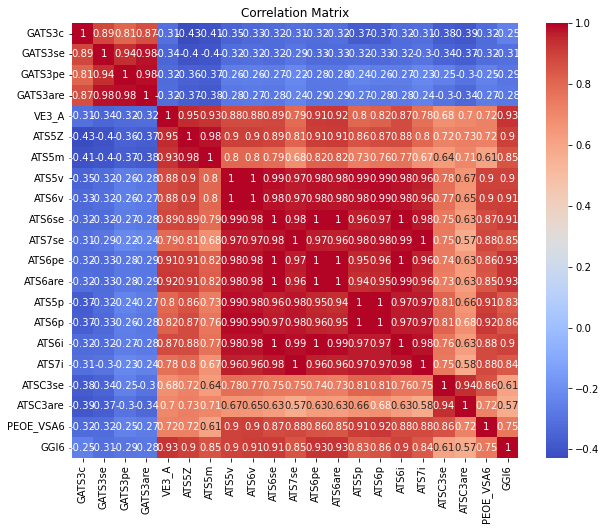

In [29]:
corr_matrix = features_df.corr()

# Create a heatmap visualization of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)
plt.title("Correlation Matrix")
plt.show()

Performing Variance Inflation Factor (VIF) test. It has been commented out here as for our dataset there is high multicolliniarity and actually all features should be removed. It might however be useful for your data so please go ahead and read here https://en.wikipedia.org/wiki/Variance_inflation_factor this will allow you to decide what is best for your project

In [30]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # Calculate VIF for each predictor variable
# vif_df = pd.DataFrame()
# vif_df["feature"] = features_df.columns
# vif_df["VIF"] = [variance_inflation_factor(features_df.values, i) for i in range(features_df.shape[1])]

# # Print the VIF values
# print(vif_df)

# # Remove any predictor variables with high VIF values
# # Change threshold approprietly
# vif_threshold = 10
# high_vif_features = vif_df[vif_df["VIF"] > vif_threshold]["feature"].values
# if len(high_vif_features) > 0:
#     print("Removing high VIF features:", high_vif_features)
#     features_df.drop(high_vif_features, axis=1, inplace=True)


The code generates histograms of the features in the "features_df" dataframe, and separates the histograms based on the class labels in the "classes" column of the "features_and_classes_df" dataframe.

Over all classes


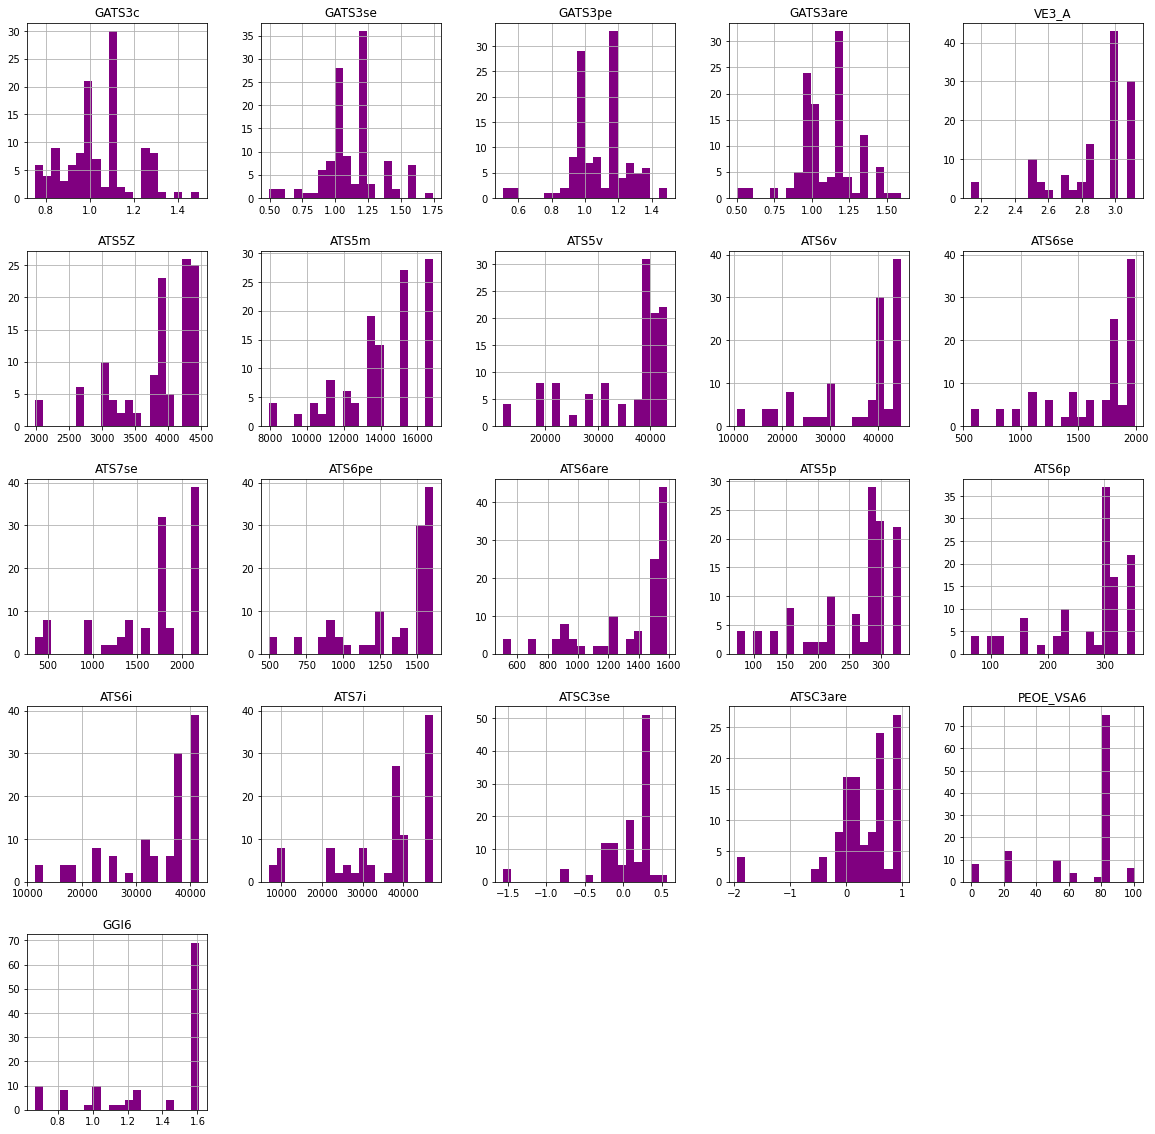

Class 0 only


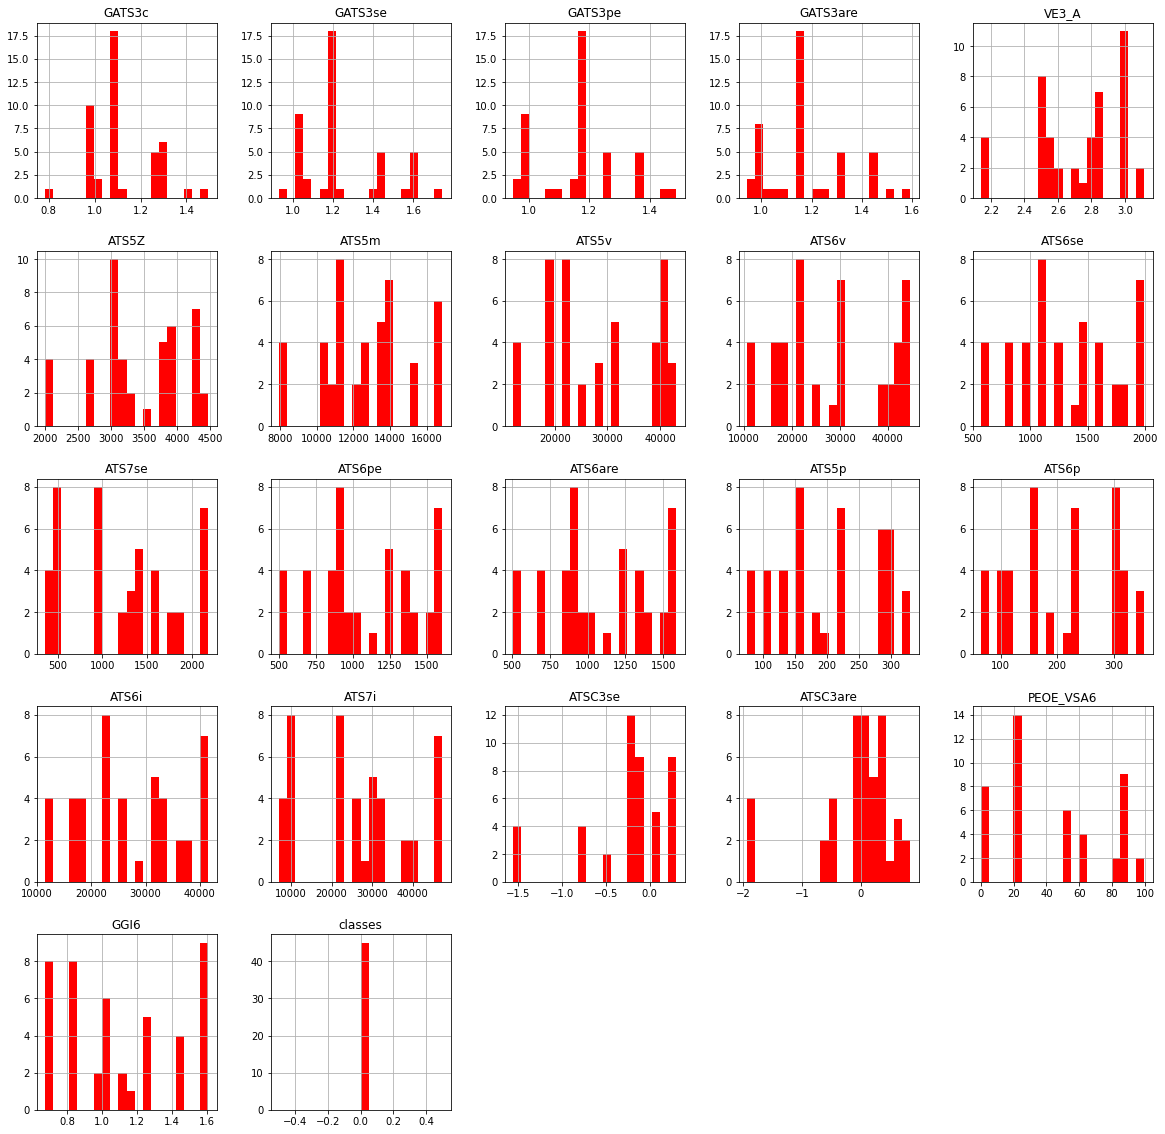

Class 1 only


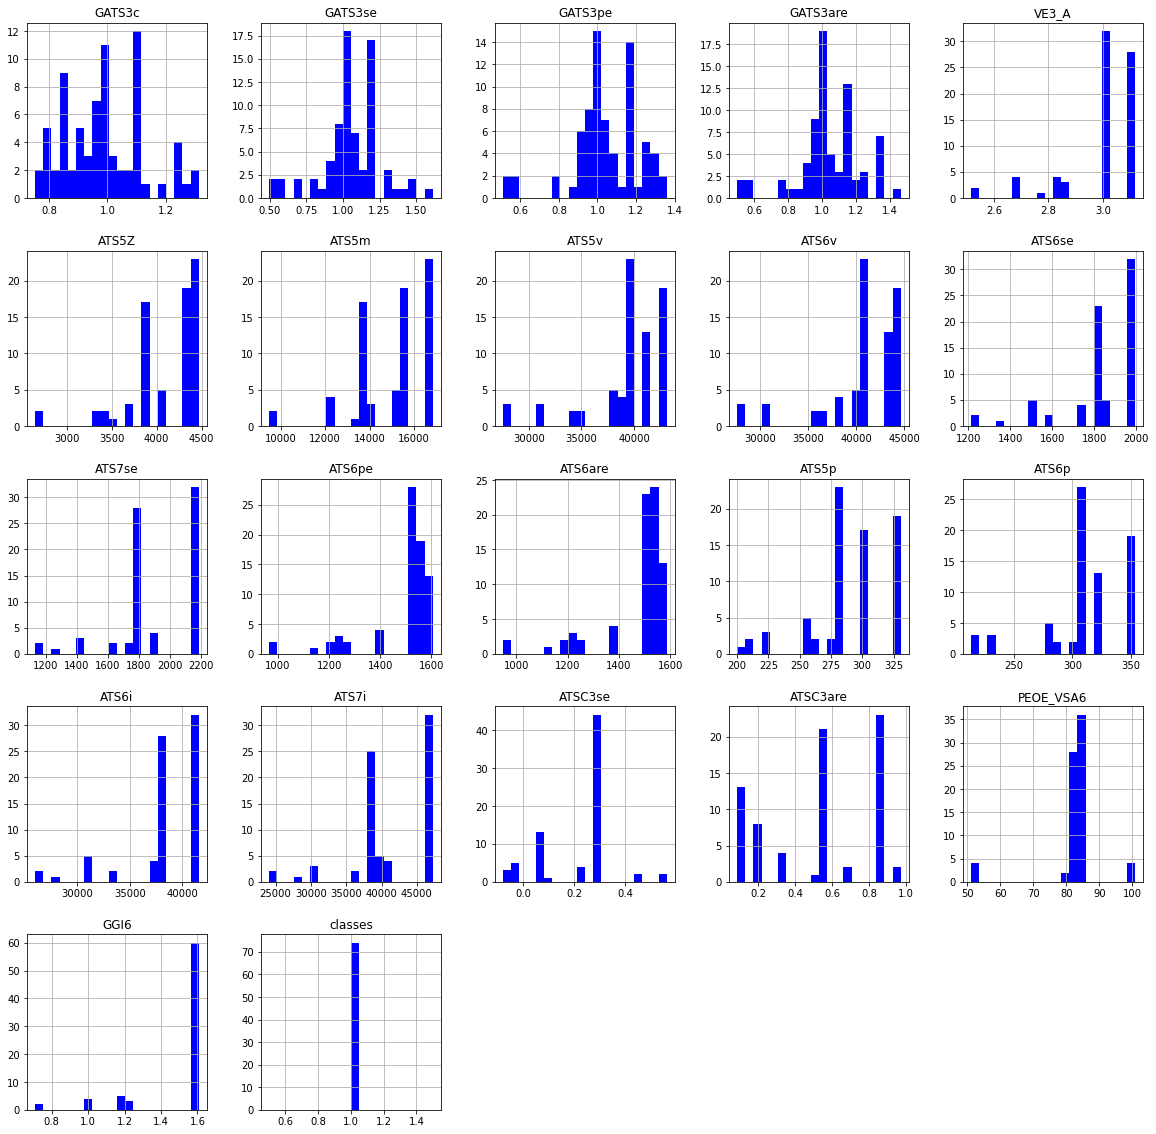

In [31]:
log.info("Over all classes")
features_df.hist(bins=20, figsize=(20,20), color="purple")
plt.savefig("features_all_classes.png")
plt.show()

log.info("Class 0 only")
features_and_classes_df[features_and_classes_df["classes"]==0].hist(bins=20, figsize=(20,20), color="red")
plt.savefig("features_class_0.png")
plt.show()

log.info("Class 1 only")
features_and_classes_df[features_and_classes_df["classes"]==1].hist(bins=20, figsize=(20,20), color="blue")
plt.savefig("features_class_1.png")
plt.show()

In [32]:
class_targets_df["classes"].values

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

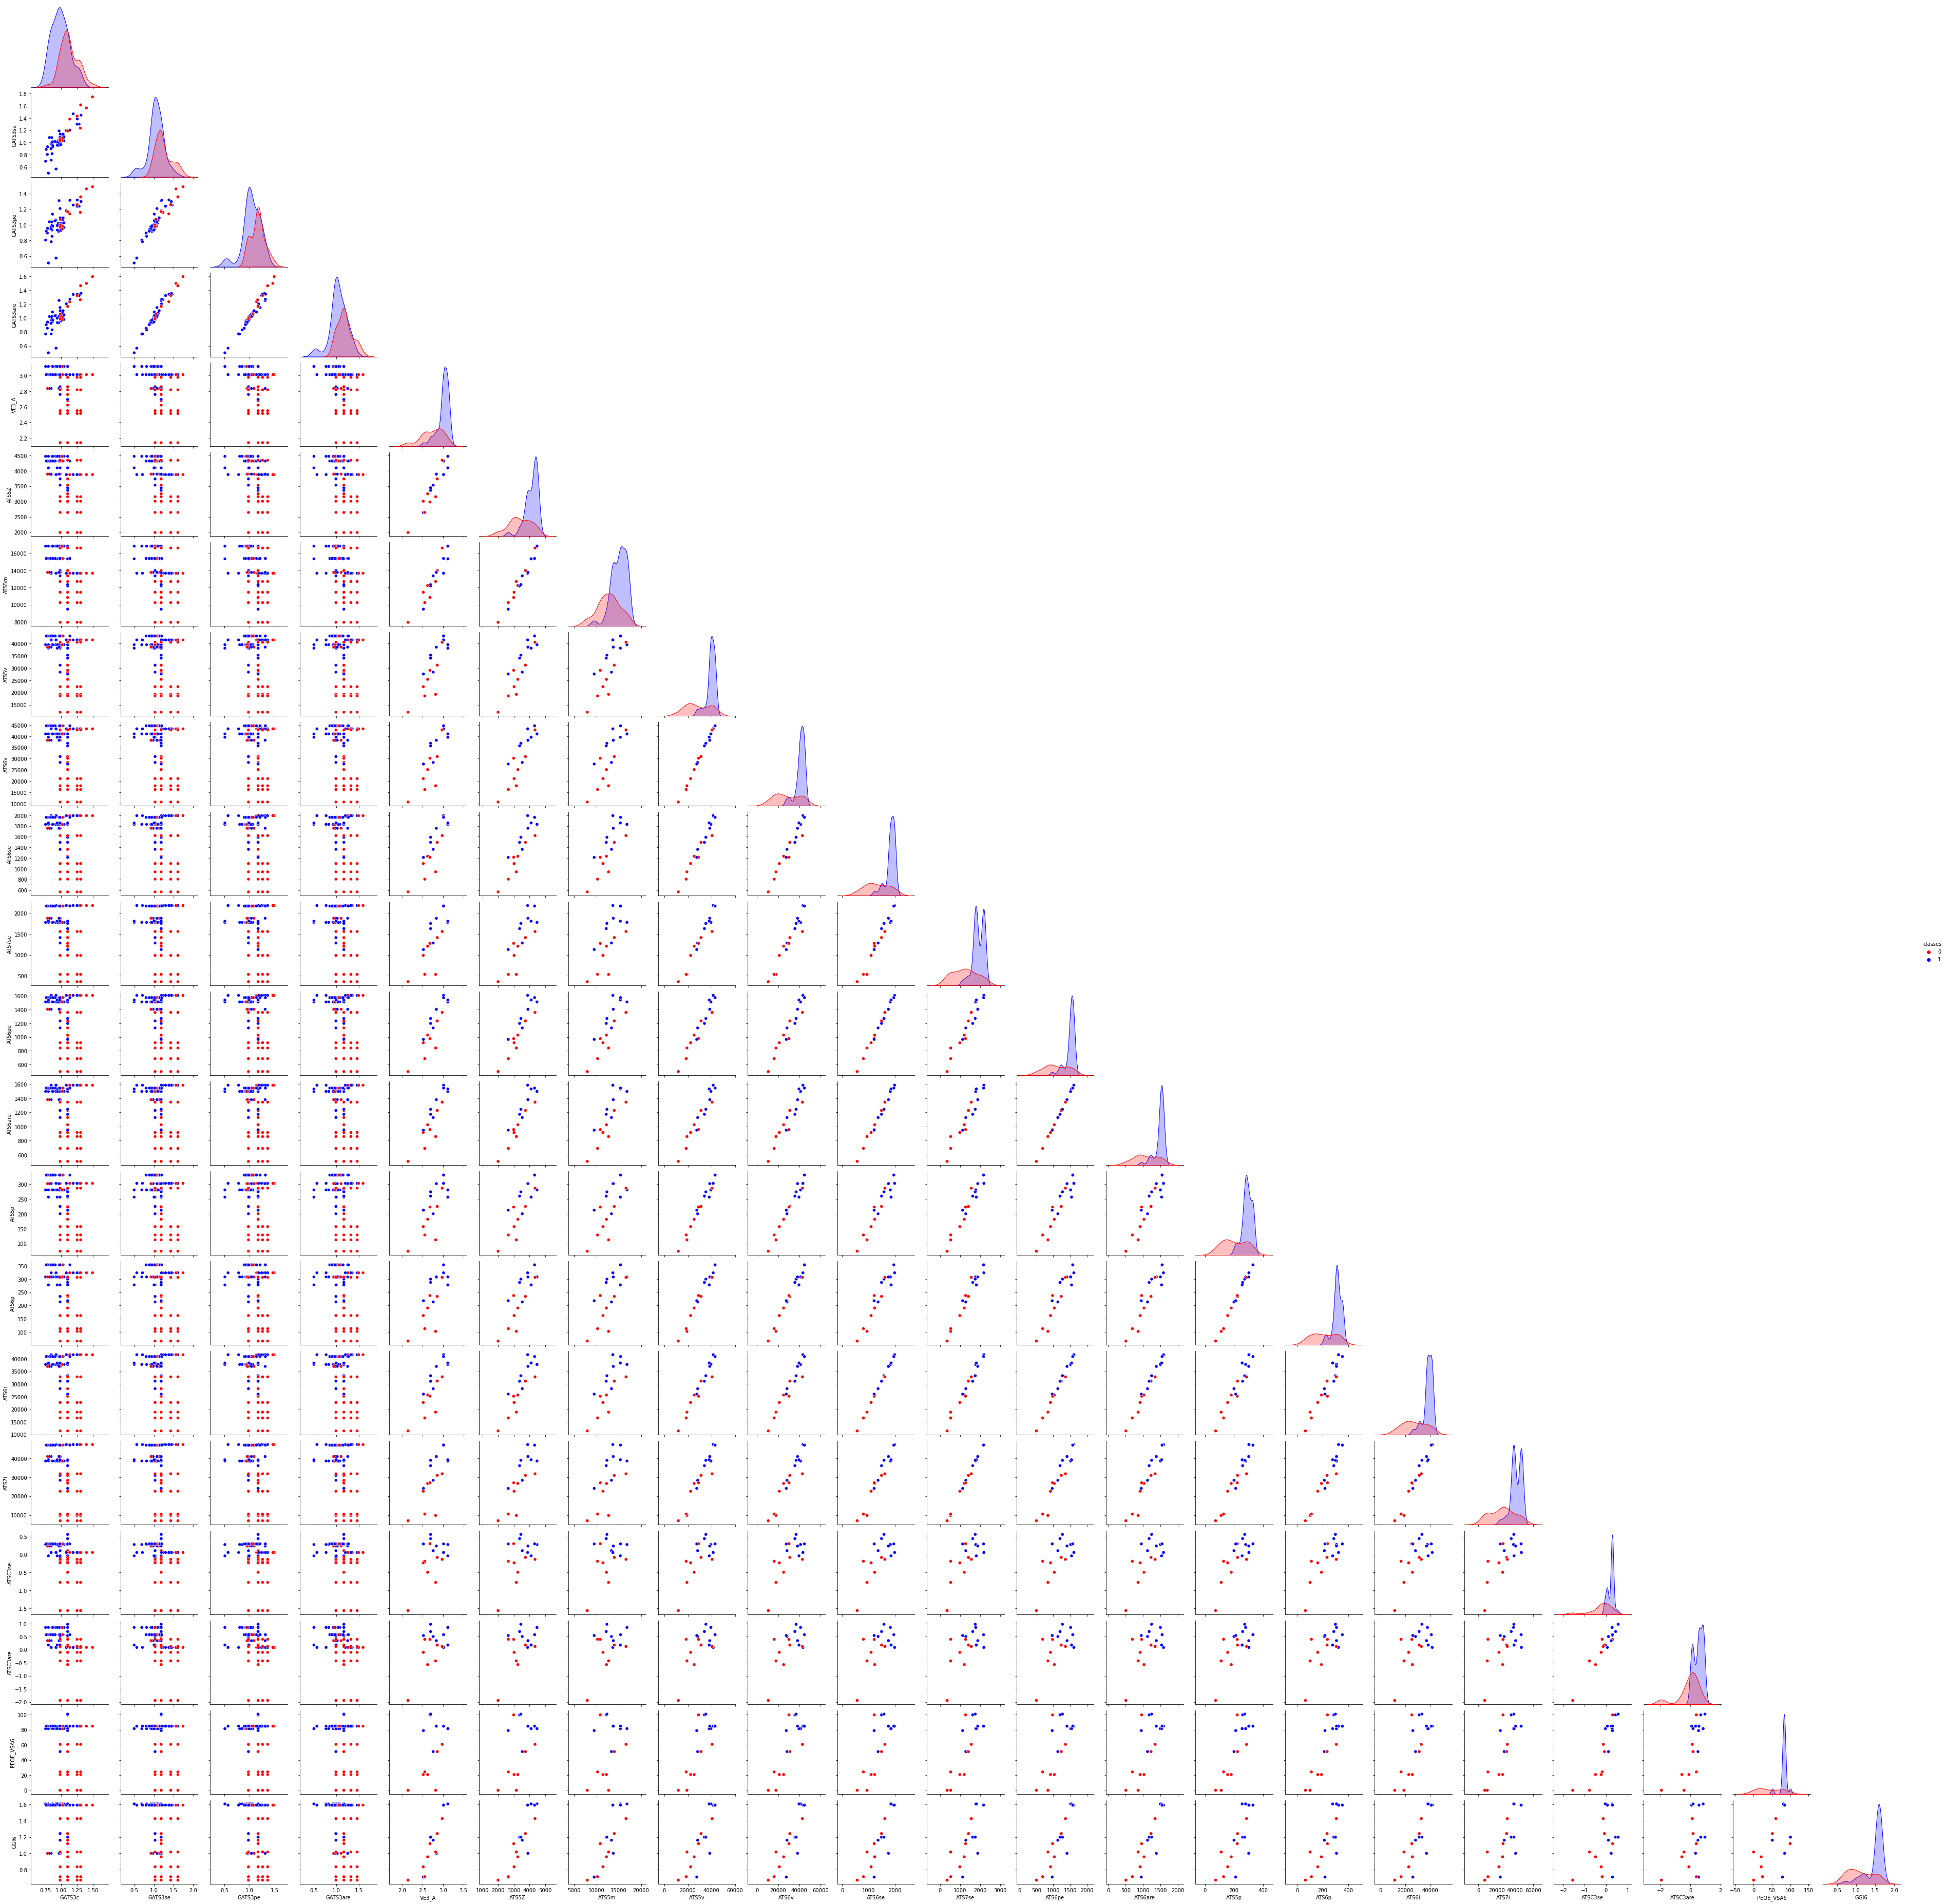

In [33]:
features_plot = sns.pairplot(features_and_classes_df, hue="classes", diag_kind="kde", kind="scatter", palette = ["red", "blue"], corner=True)
features_plot.savefig("var_features_plot.png")
features_plot

In [34]:
# Remove features with "drop" as you see fit according to your model.

In [35]:
features_df.to_csv("features.csv")

# Classification
In this section we test out a range of classification models.

## Data scaling

Different types of features (continous or not) need different types of scaling!! we only have non categorical features, but please check yours!

In [36]:
feature_types = 'no_categorical'

In [37]:
# NOTE: USER DEFINES THE LIST BELOW!!!!!!
categorical_indxs = [16,17, 18 ,19, 51]
feature_columns = features_df.columns


# or use this Automatic selection of categorical feaures
#     categorical_indxs = []
#     for column in features_df:
#         arr = features_df[column]
#         #print(arr.name)
#         if arr.dtype.name == 'int64':
#             index_no = features_df.columns.get_loc(arr.name)
#            #print(index_no)
#             categorical_indxs.append(index_no)
#     feature_columns = features_df.columns

# Backup
backup_feats_df = features_df.copy()

# None categorical only scale the data as numbers
if feature_types == "no_categorical":
    mm_scaler = MinMaxScaler()
    features_df = mm_scaler.fit_transform(features_df)
    log.info(pd.DataFrame(features_df, columns=feature_columns))
    features_df = pd.DataFrame(features_df, columns=feature_columns)
    
# Some categorical - Need to provide the indexes
elif feature_types == "some_categorical":
    numeric_features = [feature_columns[i] for i in range(len(feature_columns)) if i not in categorical_indxs]
    numerical_transformer = MinMaxScaler()
    categorical_features = [feature_columns[i] for i in range(len(feature_columns)) if i in categorical_indxs]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    if any(ent in categorical_features for ent in numeric_features):
        log.warning("WARNING - numeric and categorical feature specififed overlap")
        log.info(numeric_features)
        log.info(categorical_features)
    else:
        log.info("Numerical features:\n{} {}".format(numeric_features, len(numeric_features)))
        log.info("Categorical features:\n{} {}".format(categorical_features, len(categorical_indxs)))
    
    preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)])
    
    features_df = preprocessor.fit_transform(features_df)
    feature_names = cwf.get_feature_names_from_column_transformers(preprocessor)
    categorical_indxs = [i for i in range(len(numeric_features), len(feature_names))]
    log.info(feature_names)

    log.info(pd.DataFrame(features_df, columns=feature_names))
    features_df = pd.DataFrame(features_df, columns=feature_names)
    log.info("categorical indexes {}".format(categorical_indxs))
    log.info("Categorical features start on column name {} and end on {}".format(features_df.columns[categorical_indxs[0]], features_df.columns[categorical_indxs[-1]]))
    
# All categorical
elif feature_types == "categorical":
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    features_df = categorical_transformer.fit_transform(features_df).toarray()
    feature_names = [categorical_transformer.get_feature_names(feature_columns)]
    features_df = pd.DataFrame(features_df, columns=feature_names)
    log.info(features_df)

# No scaling or other encoding
else:
    log.info("No scaling")

       GATS3c   GATS3se   GATS3pe  GATS3are     VE3_A     ATS5Z     ATS5m  \
0    0.470082  0.553726  0.673958  0.609793  0.382712  0.410577  0.395021   
1    0.308767  0.428474  0.477957  0.447722  0.382712  0.410577  0.395021   
2    0.470082  0.553726  0.673958  0.609793  0.632332  0.621316  0.609724   
3    0.308767  0.428474  0.477957  0.447722  0.632332  0.621316  0.609724   
4    0.470082  0.553726  0.673958  0.609793  0.733978  0.703270  0.680002   
..        ...       ...       ...       ...       ...       ...       ...   
114  0.746488  0.894660  0.867844  0.880143  0.382712  0.410577  0.395021   
115  0.470082  0.553726  0.673958  0.609793  0.000000  0.000000  0.000000   
116  0.308767  0.428474  0.477957  0.447722  0.000000  0.000000  0.000000   
117  0.670921  0.749080  0.764710  0.753181  0.000000  0.000000  0.000000   
118  0.746488  0.894660  0.867844  0.880143  0.000000  0.000000  0.000000   

        ATS5v     ATS6v    ATS6se    ATS7se    ATS6pe   ATS6are     ATS5p  

## Using synthetic data sampling

In this section I investigate the use of synthetic sampling methods, i.e. generate additional sampling points for the minority class or undersample the majority class. Both of these techniques look to provide a better balance between the classes and hence improve the learning of a decision boundary. SMOTE https://arxiv.org/pdf/1106.1813.pdf.


In [38]:
nneighbours = min(5, len(class_targets_df[class_targets_df["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No categorical
if feature_types == "no_categorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some categorical - Need to provide the indexes
elif feature_types == "some_categorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=categorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All categorical
elif feature_types == "categorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


Check that there are only features in the feature dataframe and classes in the classes dataframe.

In [39]:
log.info("Feature decriptions:\n{}".format(features_df.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df.columns.values))

Feature decriptions:
['GATS3c' 'GATS3se' 'GATS3pe' 'GATS3are' 'VE3_A' 'ATS5Z' 'ATS5m' 'ATS5v'
 'ATS6v' 'ATS6se' 'ATS7se' 'ATS6pe' 'ATS6are' 'ATS5p' 'ATS6p' 'ATS6i'
 'ATS7i' 'ATSC3se' 'ATSC3are' 'PEOE_VSA6' 'GGI6']
Classes/Targets descriptions:
['classes']


In [40]:
features_df.columns.values

array(['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'VE3_A', 'ATS5Z',
       'ATS5m', 'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe', 'ATS6are',
       'ATS5p', 'ATS6p', 'ATS6i', 'ATS7i', 'ATSC3se', 'ATSC3are',
       'PEOE_VSA6', 'GGI6'], dtype=object)

Sample using smote to balance the dataset using synthetic samples for the under represented class.

In [41]:
features_smote, classes_smote = sm.fit_resample(features_df.to_numpy(), class_targets_df.to_numpy())
n_sythetic_points = features_smote.shape[0] - len(features_df.index)
log.info("SMOTE has added {} sythetic features to balance the classes".format(n_sythetic_points))

SMOTE has added 29 sythetic features to balence the classes


In [42]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote, features_smote.shape, classes_smote, classes_smote.shape))

Resampled X
[[0.4700823  0.55372616 0.67395789 ... 0.63087372 0.20627367 0.17452007]
 [0.30876729 0.42847354 0.47795704 ... 0.63087372 0.20627367 0.17452007]
 [0.4700823  0.55372616 0.67395789 ... 0.83864737 0.50749149 0.52356021]
 ...
 [0.74648843 0.89465964 0.86784357 ... 0.75603673 0.23155165 0.07980759]
 [0.34540314 0.42675303 0.45787035 ... 0.93557417 0.8163951  0.99629502]
 [0.4700823  0.55372616 0.67395789 ... 0.7264909  0.50749149 0.61082024]]
(148, 21)
Resampled y:
[0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(148,)


In [43]:
features_smote_df = pd.DataFrame(data=features_smote, columns=features_df.columns.values)
classes_smote_df = pd.DataFrame(data=classes_smote, columns=["classes"])

comb_df_res = features_smote_df.copy()
comb_df_res["classes"] = classes_smote
comb_df_res.to_csv("resampled_synthetic_data_set.csv")
comb_df_res

GATS3c   GATS3se   GATS3pe  GATS3are     VE3_A     ATS5Z     ATS5m  \
0    0.470082  0.553726  0.673958  0.609793  0.382712  0.410577  0.395021   
1    0.308767  0.428474  0.477957  0.447722  0.382712  0.410577  0.395021   
2    0.470082  0.553726  0.673958  0.609793  0.632332  0.621316  0.609724   
3    0.308767  0.428474  0.477957  0.447722  0.632332  0.621316  0.609724   
4    0.470082  0.553726  0.673958  0.609793  0.733978  0.703270  0.680002   
..        ...       ...       ...       ...       ...       ...       ...   
143  0.332455  0.438106  0.490544  0.463680  0.892213  0.937828  0.838310   
144  0.310168  0.482702  0.551243  0.515324  0.763229  0.831726  0.769815   
145  0.746488  0.894660  0.867844  0.880143  0.409743  0.303235  0.295770   
146  0.345403  0.426753  0.457870  0.438407  0.974575  0.985335  0.961860   
147  0.470082  0.553726  0.673958  0.609793  0.733978  0.703270  0.680002   

        ATS5v     ATS6v    ATS6se  ...   ATS6are     ATS5p     ATS6p  \
0    0.334544  0.307263  0.371587  ...  0.378961  0.322889  0.334863   
1    0.334544  0.307263  0.371587  ...  0.378961  0.322889  0.334863   
2    0.525455  0.519410  0.557964  ...  0.575190  0.491379  0.513201   
3    0.525455  0.519410  0.557964  ...  0.575190  0.491379  0.513201   
4    0.616881  0.596803  0.649551  ...  0.668859  0.587695  0.585785   
..        ...       ...       ...  ...       ...       ...       ...   
143  1.000000  1.000000  0.978219  ...  0.962402  1.000000  1.000000   
144  0.876870  0.858904  0.800234  ...  0.798137  0.865988  0.839316   
145  0.246072  0.203238  0.222626  ...  0.226982  0.243199  0.209456   
146  0.912274  0.918829  0.907771  ...  0.928760  0.850826  0.878934   
147  0.616881  0.596803  0.649551  ...  0.668859  0.587695  0.585785   

        ATS6i     ATS7i   ATSC3se  ATSC3are  PEOE_VSA6      GGI6  classes  
0    0.373298  0.387418  0.626611  0.630874   0.206274  0.174520        0  
1    0.373298  0.387418  0.626611  0.630874   0.206274  0.174520        0  
2    0.553970  0.530745  0.786225  0.838647   0.507491  0.523560        0  
3    0.553970  0.530745  0.786225  0.838647   0.507491  0.523560        1  
4    0.653678  0.595433  0.697692  0.726491   0.507491  0.610820        0  
..        ...       ...       ...       ...        ...       ...      ...  
143  0.975784  0.992670  0.875237  0.862798   0.841292  0.984293        0  
144  0.797305  0.762075  0.784715  0.757364   0.755926  0.514450        0  
145  0.225186  0.169015  0.641917  0.756037   0.231552  0.079808        0  
146  0.896427  0.833482  0.869066  0.935574   0.816395  0.996295        0  
147  0.653678  0.595433  0.697692  0.726491   0.507491  0.610820        0  

[148 rows x 22 columns]

## Using balanced classes Kfold
This section tests the relience of the model on the training set

In [44]:
kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier", "AdaBoost",
         "LogisticRegression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "NearestNeighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "GaussianProcess": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "DecisionTree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "LogisticRegression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

Features: Index(['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'VE3_A', 'ATS5Z', 'ATS5m',
       'ATS5v', 'ATS6v', 'ATS6se', 'ATS7se', 'ATS6pe', 'ATS6are', 'ATS5p',
       'ATS6p', 'ATS6i', 'ATS7i', 'ATSC3se', 'ATSC3are', 'PEOE_VSA6', 'GGI6'],
      dtype='object')
Features:        GATS3c   GATS3se   GATS3pe  GATS3are     VE3_A     ATS5Z     ATS5m  \
0    0.470082  0.553726  0.673958  0.609793  0.382712  0.410577  0.395021   
1    0.308767  0.428474  0.477957  0.447722  0.382712  0.410577  0.395021   
2    0.470082  0.553726  0.673958  0.609793  0.632332  0.621316  0.609724   
3    0.308767  0.428474  0.477957  0.447722  0.632332  0.621316  0.609724   
4    0.470082  0.553726  0.673958  0.609793  0.733978  0.703270  0.680002   
..        ...       ...       ...       ...       ...       ...       ...   
143  0.332455  0.438106  0.490544  0.463680  0.892213  0.937828  0.838310   
144  0.310168  0.482702  0.551243  0.515324  0.763229  0.831726  0.769815   
145  0.746488  0.894660  0.867844

	Best parameters; {'n_neighbors': 2}
	0.7610 (+/-0.0835) for {'n_neighbors': 2}
	0.7590 (+/-0.0866) for {'n_neighbors': 3}
	0.7587 (+/-0.1141) for {'n_neighbors': 4}
	0.7413 (+/-0.0688) for {'n_neighbors': 5}
	0.7338 (+/-0.0698) for {'n_neighbors': 6}
	0.7300 (+/-0.0606) for {'n_neighbors': 7}
	0.7094 (+/-0.0774) for {'n_neighbors': 8}
	0.7116 (+/-0.0842) for {'n_neighbors': 9}

	----- Predicting using: NearestNeighbors -----
	ROC analysis area under the curve: 0.8571428571428572
	Confusion matrix (NearestNeighbors):
[[6 1]
 [2 6]]


	score (NearestNeighbors): 0.8
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.86      0.75      0.80      0.80      0.65         7
          1       0.86      0.75      0.86      0.80      0.80      0.64         8

avg / total       0.81      0.80      0.81      0.80      0.80      0.64        15

	 Index | Predicted | Label
	-----------

	0.7775 (+/-0.1654) for {'n_neighbors': 2}
	0.7455 (+/-0.1554) for {'n_neighbors': 3}
	0.7572 (+/-0.1342) for {'n_neighbors': 4}
	0.7476 (+/-0.1113) for {'n_neighbors': 5}
	0.7398 (+/-0.1126) for {'n_neighbors': 6}
	0.7259 (+/-0.0970) for {'n_neighbors': 7}
	0.7443 (+/-0.0996) for {'n_neighbors': 8}
	0.7515 (+/-0.0794) for {'n_neighbors': 9}

	----- Predicting using: NearestNeighbors -----
	ROC analysis area under the curve: 0.7613636363636364
	Confusion matrix (NearestNeighbors):
[[8 3]
 [3 1]]


	score (NearestNeighbors): 0.6
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      0.73      0.25      0.73      0.43      0.19        11
          1       0.25      0.25      0.73      0.25      0.43      0.17         4

avg / total       0.60      0.60      0.38      0.60      0.43      0.19        15

	 Index | Predicted | Label
	------------------
	13   |   1   |   0
	28   |  

	Best parameters; {'n_neighbors': 5}
	0.6423 (+/-0.1629) for {'n_neighbors': 2}
	0.6488 (+/-0.1812) for {'n_neighbors': 3}
	0.7132 (+/-0.0877) for {'n_neighbors': 4}
	0.7291 (+/-0.0816) for {'n_neighbors': 5}
	0.7097 (+/-0.0870) for {'n_neighbors': 6}
	0.7244 (+/-0.0825) for {'n_neighbors': 7}
	0.7156 (+/-0.1125) for {'n_neighbors': 8}
	0.7207 (+/-0.1155) for {'n_neighbors': 9}

	----- Predicting using: NearestNeighbors -----
	ROC analysis area under the curve: 0.9895833333333334
	Confusion matrix (NearestNeighbors):
[[5 1]
 [0 8]]


	score (NearestNeighbors): 0.9285714285714286
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.83      1.00      0.91      0.91      0.82         6
          1       0.89      1.00      0.83      0.94      0.91      0.85         8

avg / total       0.94      0.93      0.90      0.93      0.91      0.84        14

	 Index | Predicted | Lab

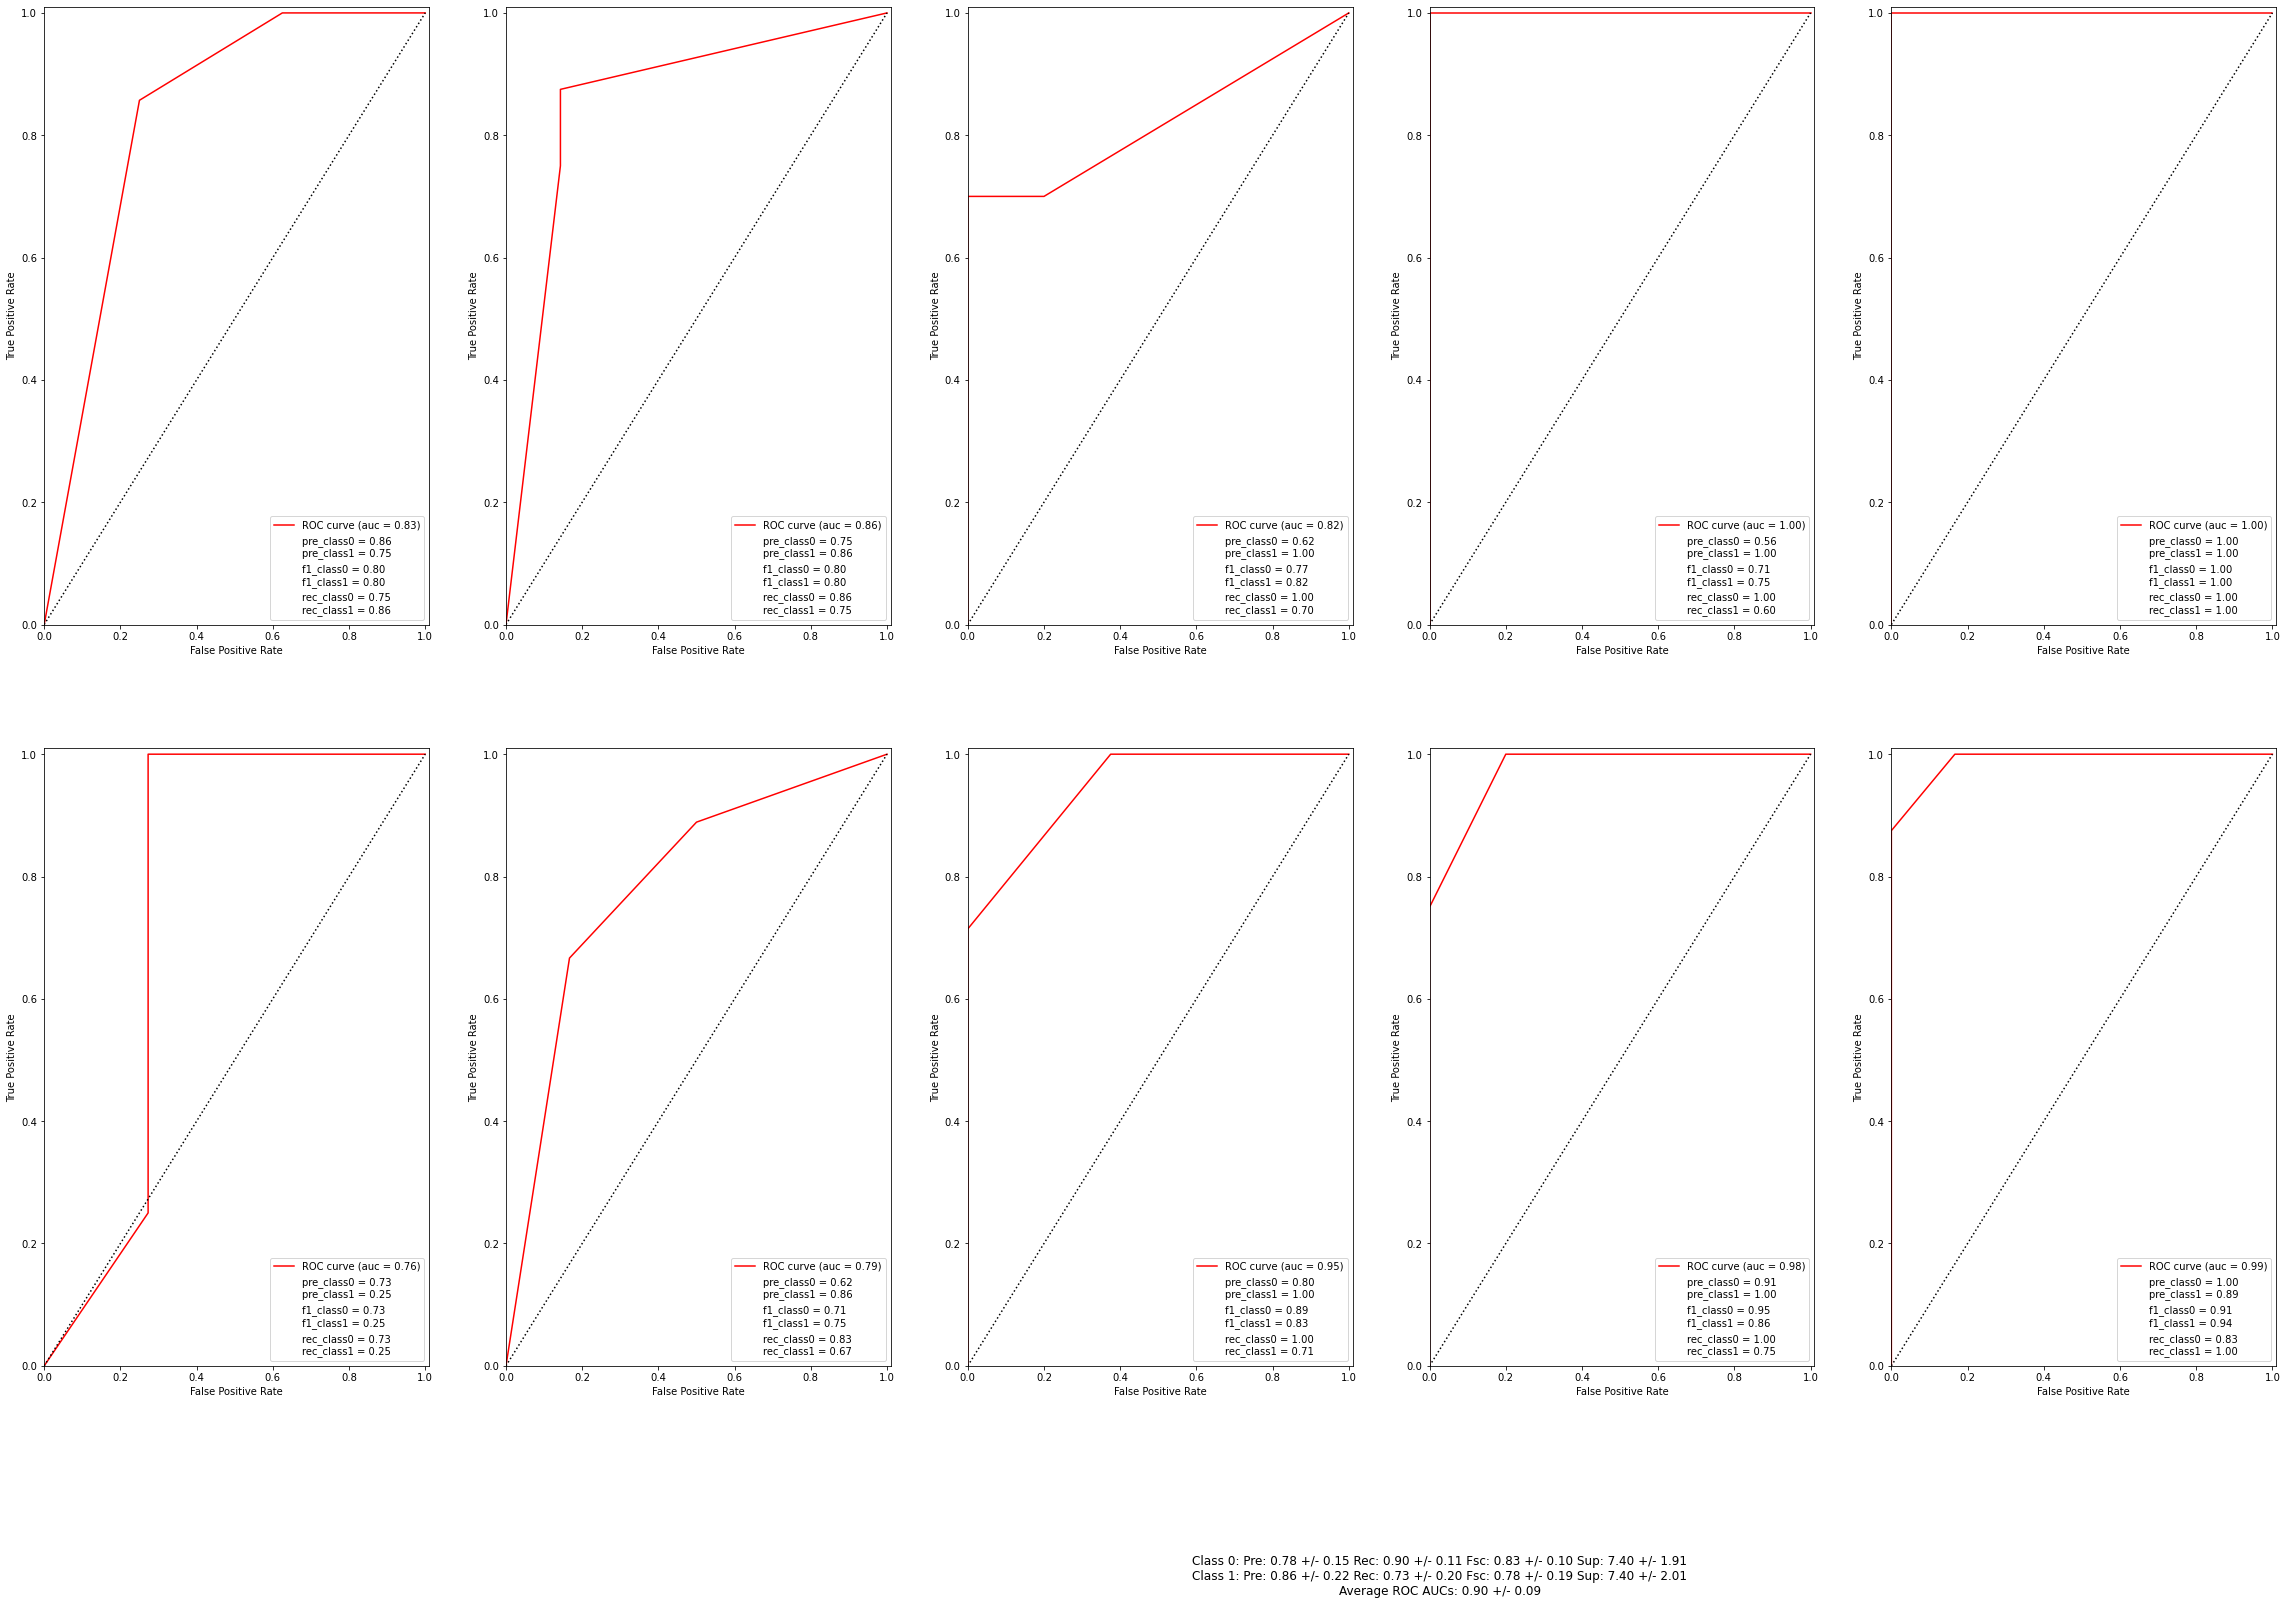


-----
Begin GaussianProcess
-----

----- GaussianProcess: Fold 0 -----
[9, 16, 37, 42, 46, 48, 53, 57, 60, 88, 109, 126, 129, 134, 136]
	Train indx [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38
  39  40  41  43  44  45  47  49  50  51  52  54  55  56  58  59  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 127 128 130 131 132 133 135 137 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [  9  16  37  42  46  48  53  57  60  88 109 126 129 134 136]
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k

----- GaussianProcess: Fold 3 -----
[5, 15, 22, 31, 35, 39, 47, 52, 64, 81, 83, 97, 119, 125, 141]
	Train indx [  0   1   2   3   4   6   7   8   9  10  11  12  13  14  16  17  18  19
  20  21  23  24  25  26  27  28  29  30  32  33  34  36  37  38  40  41
  42  43  44  45  46  48  49  50  51  53  54  55  56  57  58  59  60  61
  62  63  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  82  84  85  86  87  88  89  90  91  92  93  94  95  96  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 120
 121 122 123 124 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 142 143 144 145 146 147]
	Test indx: [  5  15  22  31  35  39  47  52  64  81  83  97 119 125 141]
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specifi

----- GaussianProcess: Fold 6 -----
[11, 17, 19, 23, 26, 36, 40, 45, 75, 96, 107, 113, 133, 135, 144]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  18  20
  21  22  24  25  27  28  29  30  31  32  33  34  35  37  38  39  41  42
  43  44  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  97  98  99
 100 101 102 103 104 105 106 108 109 110 111 112 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 134 136 137 138 139
 140 141 142 143 145 146 147]
	Test indx: [ 11  17  19  23  26  36  40  45  75  96 107 113 133 135 144]
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the spec

	2   |   0   |   0
	12   |   1   |   1
	29   |   1   |   1
	62   |   0   |   0
	65   |   1   |   1
	85   |   1   |   1
	95   |   1   |   0
	101   |   0   |   0
	102   |   0   |   0
	104   |   0   |   0
	115   |   0   |   0
	118   |   0   |   0
	121   |   0   |   0
	147   |   0   |   0
-----

----- GaussianProcess: Fold 9 -----
[1, 21, 44, 55, 69, 77, 82, 87, 92, 93, 132, 140, 143, 146]
	Train indx [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  45  46  47  48  49  50  51  52  53  54  56  57
  58  59  60  61  62  63  64  65  66  67  68  70  71  72  73  74  75  76
  78  79  80  81  83  84  85  86  88  89  90  91  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 133 134 135 136
 137 138 139 141 142 144 145 147]
	Test indx: [  1  21  44  55  69  77  82  87  92  93 1


-----
Begin DecisionTree
-----

----- DecisionTree: Fold 0 -----
[9, 16, 37, 42, 46, 48, 53, 57, 60, 88, 109, 126, 129, 134, 136]
	Train indx [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38
  39  40  41  43  44  45  47  49  50  51  52  54  55  56  58  59  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 127 128 130 131 132 133 135 137 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [  9  16  37  42  46  48  53  57  60  88 109 126 129 134 136]
	Best parameters; {'max_depth': 5}
	0.7667 (+/-0.1193) for {'max_depth': 2}
	0.7586 (+/-0.0717) for {'max_depth': 3}
	0.7636 (+/-0.1214) for {'max_depth': 4}
	0.8141 (+/-0.1001) for {'max_depth': 5}
	0.7610 (+/-0.0794) for {'max_depth': 7}
	0

	Best parameters; {'max_depth': 3}
	0.7920 (+/-0.1247) for {'max_depth': 2}
	0.7944 (+/-0.1188) for {'max_depth': 3}
	0.7140 (+/-0.1165) for {'max_depth': 4}
	0.7578 (+/-0.0823) for {'max_depth': 5}
	0.7658 (+/-0.1613) for {'max_depth': 7}
	0.7421 (+/-0.1310) for {'max_depth': 10}

	----- Predicting using: DecisionTree -----
	ROC analysis area under the curve: 0.9464285714285714
	Confusion matrix (DecisionTree):
[[6 2]
 [0 7]]


	score (DecisionTree): 0.8666666666666667
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.75      1.00      0.86      0.87      0.73         8
          1       0.78      1.00      0.75      0.88      0.87      0.77         7

avg / total       0.90      0.87      0.88      0.87      0.87      0.75        15

	 Index | Predicted | Label
	------------------
	8   |   1   |   1
	24   |   1   |   1
	27   |   1   |   1
	33   |   1   |   1
	43   |  


	score (DecisionTree): 0.8571428571428571
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.80      1.00      0.89      0.89      0.78        10
          1       0.67      1.00      0.80      0.80      0.89      0.82         4

avg / total       0.90      0.86      0.94      0.86      0.89      0.79        14

	 Index | Predicted | Label
	------------------
	2   |   1   |   0
	12   |   1   |   1
	29   |   1   |   1
	62   |   0   |   0
	65   |   1   |   1
	85   |   1   |   1
	95   |   1   |   0
	101   |   0   |   0
	102   |   0   |   0
	104   |   0   |   0
	115   |   0   |   0
	118   |   0   |   0
	121   |   0   |   0
	147   |   0   |   0
-----

----- DecisionTree: Fold 9 -----
[1, 21, 44, 55, 69, 77, 82, 87, 92, 93, 132, 140, 143, 146]
	Train indx [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31 

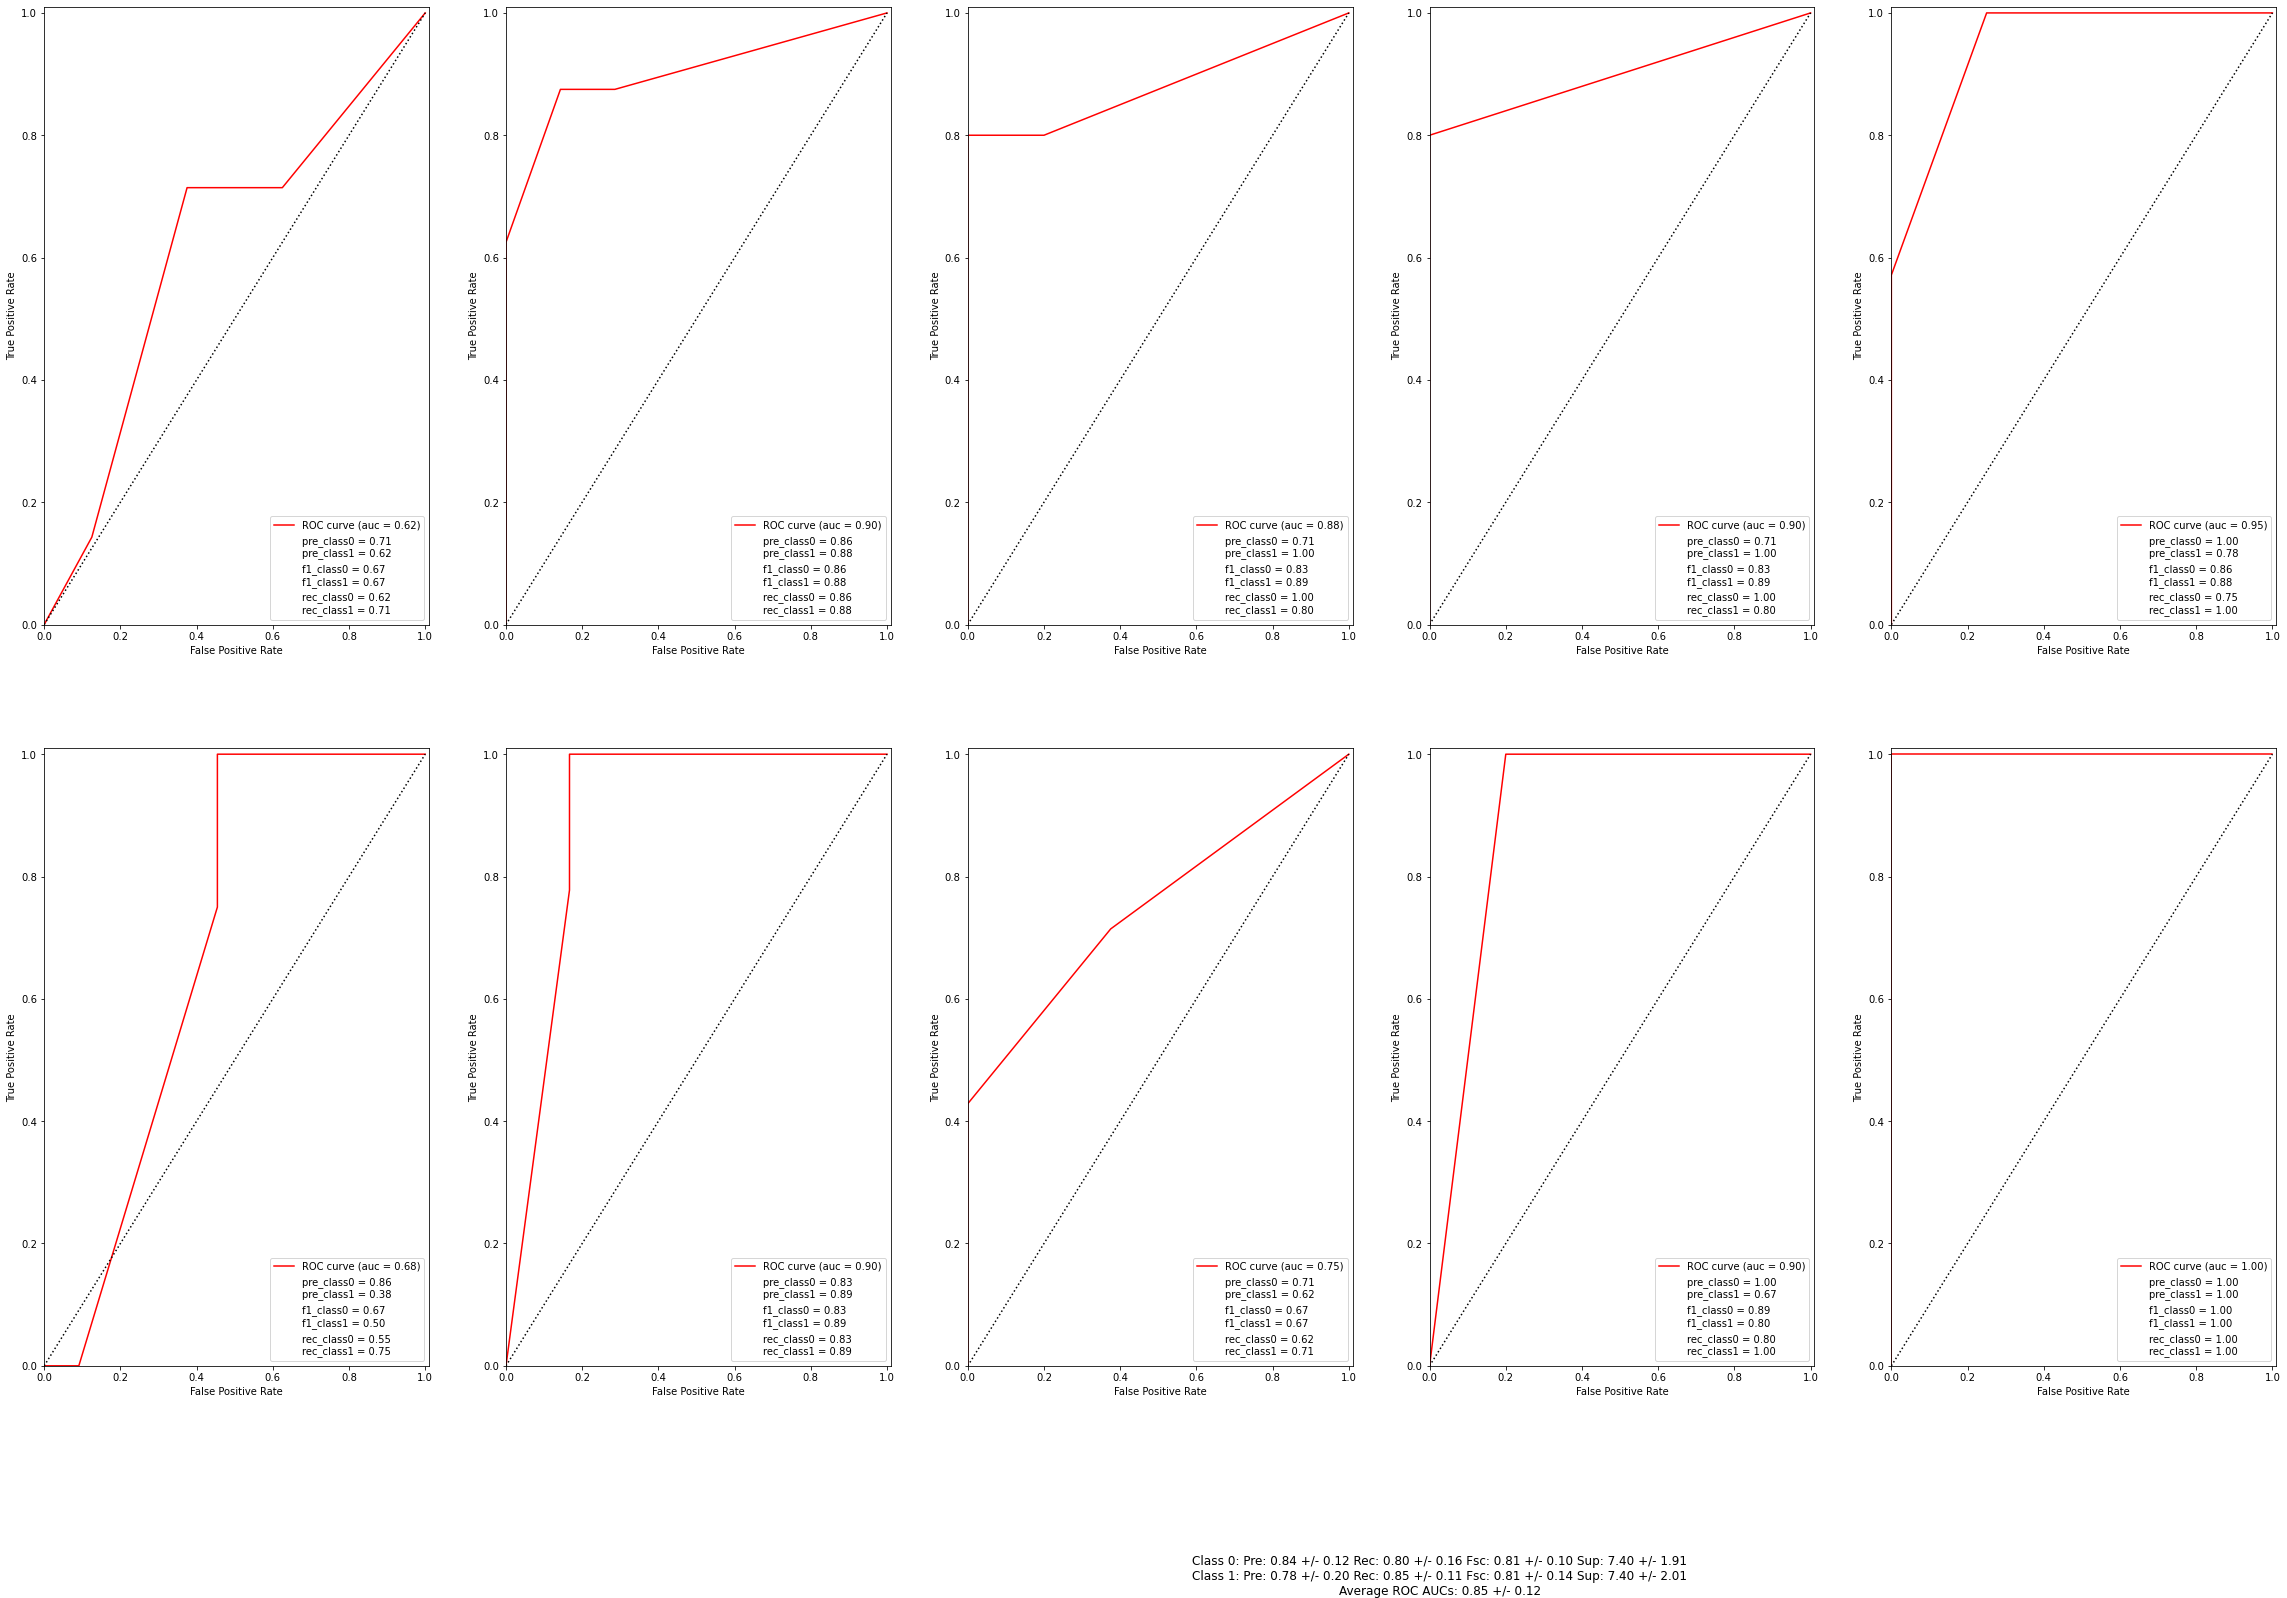


-----
Begin ExtraTreesClassifier
-----

----- ExtraTreesClassifier: Fold 0 -----
[9, 16, 37, 42, 46, 48, 53, 57, 60, 88, 109, 126, 129, 134, 136]
	Train indx [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38
  39  40  41  43  44  45  47  49  50  51  52  54  55  56  58  59  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 127 128 130 131 132 133 135 137 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [  9  16  37  42  46  48  53  57  60  88 109 126 129 134 136]
	Best parameters; {'max_depth': 2, 'n_estimators': 20}
	0.8365 (+/-0.1237) for {'max_depth': 2, 'n_estimators': 10}
	0.8573 (+/-0.0827) for {'max_depth': 2, 'n_estimators': 20}
	0.8378 (+/-0.1252) for {'max_depth': 2, 'n_estim

	0.8243 (+/-0.1745) for {'max_depth': 7, 'n_estimators': 10}
	0.8366 (+/-0.1526) for {'max_depth': 7, 'n_estimators': 20}
	0.8434 (+/-0.1363) for {'max_depth': 7, 'n_estimators': 50}
	0.8461 (+/-0.1249) for {'max_depth': 7, 'n_estimators': 100}
	0.8147 (+/-0.1215) for {'max_depth': 10, 'n_estimators': 10}
	0.8415 (+/-0.1112) for {'max_depth': 10, 'n_estimators': 20}
	0.8495 (+/-0.1064) for {'max_depth': 10, 'n_estimators': 50}
	0.8594 (+/-0.1079) for {'max_depth': 10, 'n_estimators': 100}

	----- Predicting using: ExtraTreesClassifier -----
	ROC analysis area under the curve: 0.9
	Confusion matrix (ExtraTreesClassifier):
[[5 0]
 [3 7]]


	score (ExtraTreesClassifier): 0.8
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.62      1.00      0.70      0.77      0.84      0.72         5
          1       1.00      0.70      1.00      0.82      0.84      0.68        10

avg / total   

	Best parameters; {'max_depth': 10, 'n_estimators': 100}
	0.7956 (+/-0.1141) for {'max_depth': 2, 'n_estimators': 10}
	0.7992 (+/-0.1139) for {'max_depth': 2, 'n_estimators': 20}
	0.8143 (+/-0.1013) for {'max_depth': 2, 'n_estimators': 50}
	0.8159 (+/-0.1069) for {'max_depth': 2, 'n_estimators': 100}
	0.7745 (+/-0.1201) for {'max_depth': 3, 'n_estimators': 10}
	0.7709 (+/-0.1203) for {'max_depth': 3, 'n_estimators': 20}
	0.7892 (+/-0.1123) for {'max_depth': 3, 'n_estimators': 50}
	0.7969 (+/-0.1052) for {'max_depth': 3, 'n_estimators': 100}
	0.8295 (+/-0.0904) for {'max_depth': 4, 'n_estimators': 10}
	0.7679 (+/-0.1181) for {'max_depth': 4, 'n_estimators': 20}
	0.7832 (+/-0.1113) for {'max_depth': 4, 'n_estimators': 50}
	0.7843 (+/-0.1111) for {'max_depth': 4, 'n_estimators': 100}
	0.8382 (+/-0.1374) for {'max_depth': 5, 'n_estimators': 10}
	0.8086 (+/-0.1356) for {'max_depth': 5, 'n_estimators': 20}
	0.8301 (+/-0.1286) for {'max_depth': 5, 'n_estimators': 50}
	0.8221 (+/-0.1335) for {

	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      1.00      0.71      0.89      0.85      0.73         8
          1       1.00      0.71      1.00      0.83      0.85      0.69         7

avg / total       0.89      0.87      0.85      0.86      0.85      0.72        15

	 Index | Predicted | Label
	------------------
	3   |   0   |   1
	4   |   0   |   0
	7   |   1   |   1
	20   |   1   |   1
	34   |   0   |   0
	38   |   1   |   1
	41   |   1   |   1
	67   |   1   |   1
	76   |   0   |   1
	94   |   0   |   0
	108   |   0   |   0
	110   |   0   |   0
	112   |   0   |   0
	138   |   0   |   0
	139   |   0   |   0
-----

----- ExtraTreesClassifier: Fold 8 -----
[2, 12, 29, 62, 65, 85, 95, 101, 102, 104, 115, 118, 121, 147]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  37  38
  39  40  41

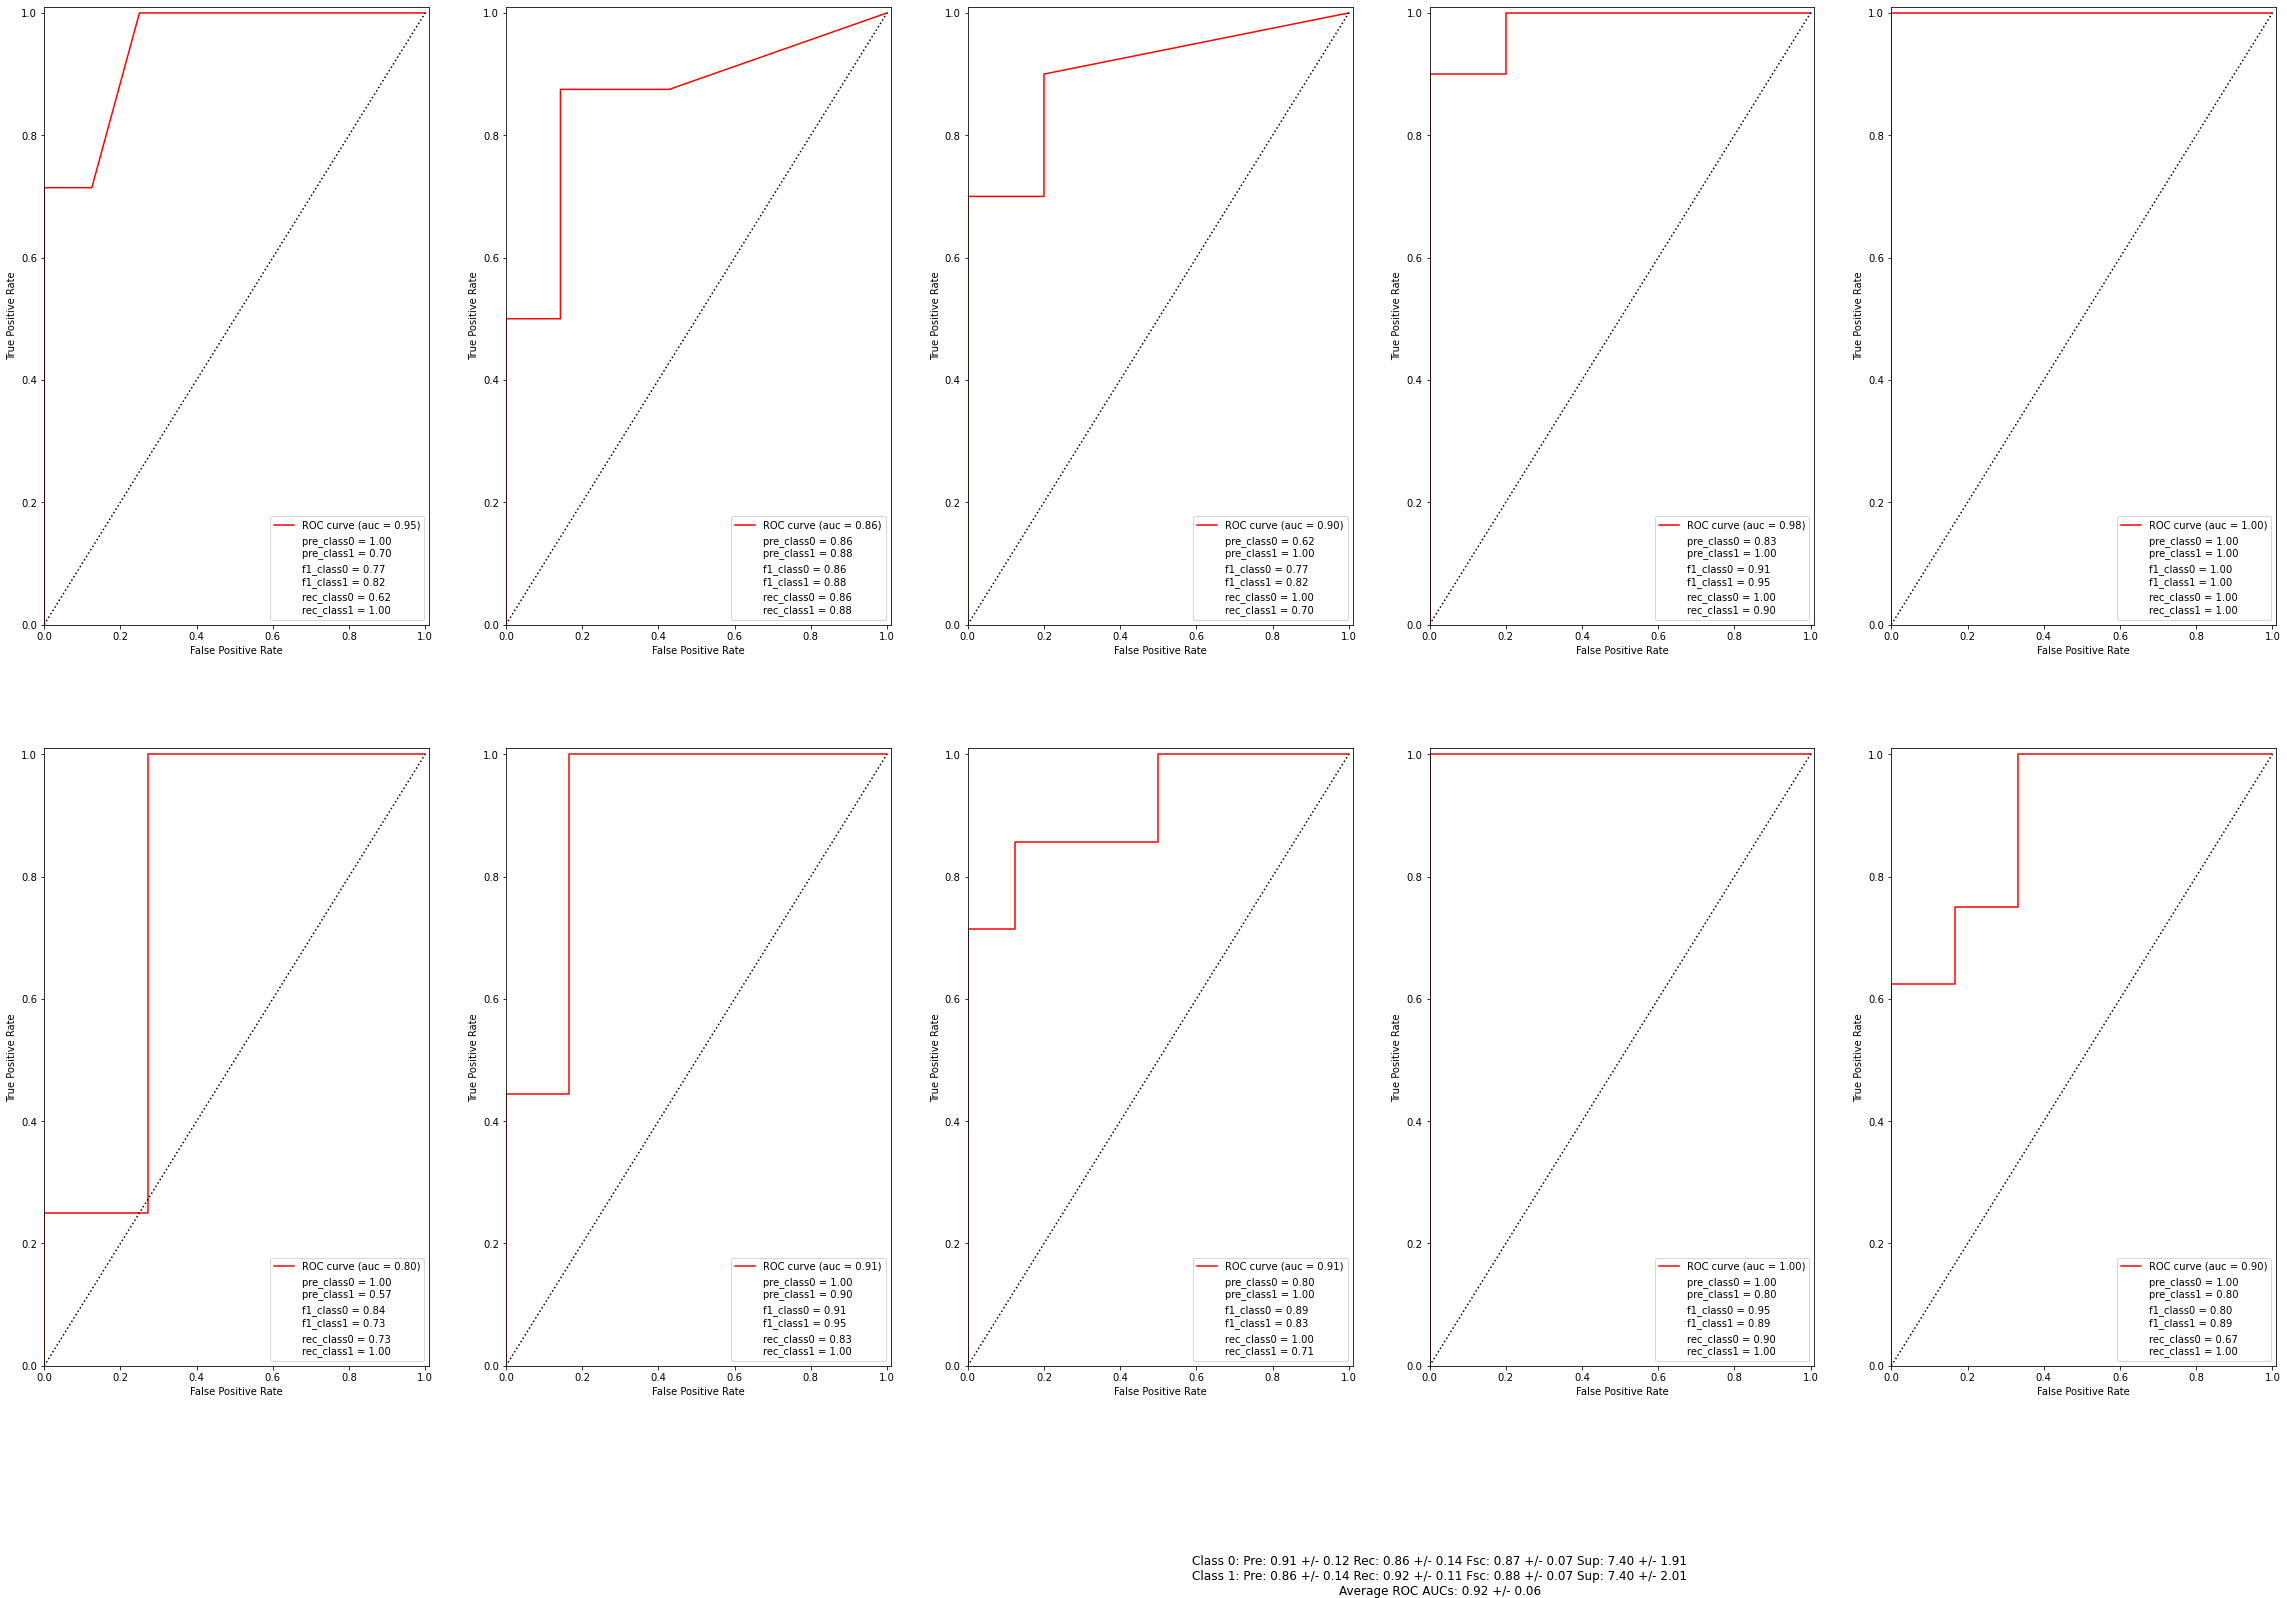


-----
Begin AdaBoost
-----

----- AdaBoost: Fold 0 -----
[9, 16, 37, 42, 46, 48, 53, 57, 60, 88, 109, 126, 129, 134, 136]
	Train indx [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38
  39  40  41  43  44  45  47  49  50  51  52  54  55  56  58  59  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 127 128 130 131 132 133 135 137 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [  9  16  37  42  46  48  53  57  60  88 109 126 129 134 136]
	Best parameters; {'n_estimators': 50}
	0.8077 (+/-0.1184) for {'n_estimators': 10}
	0.8054 (+/-0.1227) for {'n_estimators': 20}
	0.8357 (+/-0.0921) for {'n_estimators': 50}
	0.8352 (+/-0.1090) for {'n_estimators': 100}

	----- Predicting using: AdaB

	0.8467 (+/-0.1127) for {'n_estimators': 10}
	0.8361 (+/-0.0763) for {'n_estimators': 20}
	0.8700 (+/-0.0845) for {'n_estimators': 50}
	0.8759 (+/-0.0751) for {'n_estimators': 100}

	----- Predicting using: AdaBoost -----
	ROC analysis area under the curve: 0.9464285714285714
	Confusion matrix (AdaBoost):
[[6 2]
 [1 6]]


	score (AdaBoost): 0.8
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.75      0.86      0.80      0.80      0.64         8
          1       0.75      0.86      0.75      0.80      0.80      0.65         7

avg / total       0.81      0.80      0.81      0.80      0.80      0.64        15

	 Index | Predicted | Label
	------------------
	8   |   1   |   1
	24   |   1   |   1
	27   |   1   |   1
	33   |   1   |   1
	43   |   1   |   0
	54   |   1   |   1
	58   |   0   |   0
	90   |   1   |   1
	91   |   0   |   1
	106   |   0   |   0
	114   |   0   |

	2   |   1   |   0
	12   |   1   |   1
	29   |   1   |   1
	62   |   0   |   0
	65   |   1   |   1
	85   |   1   |   1
	95   |   1   |   0
	101   |   0   |   0
	102   |   0   |   0
	104   |   0   |   0
	115   |   0   |   0
	118   |   0   |   0
	121   |   0   |   0
	147   |   0   |   0
-----

----- AdaBoost: Fold 9 -----
[1, 21, 44, 55, 69, 77, 82, 87, 92, 93, 132, 140, 143, 146]
	Train indx [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  45  46  47  48  49  50  51  52  53  54  56  57
  58  59  60  61  62  63  64  65  66  67  68  70  71  72  73  74  75  76
  78  79  80  81  83  84  85  86  88  89  90  91  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 133 134 135 136
 137 138 139 141 142 144 145 147]
	Test indx: [  1  21  44  55  69  77  82  87  92  93 132 140 

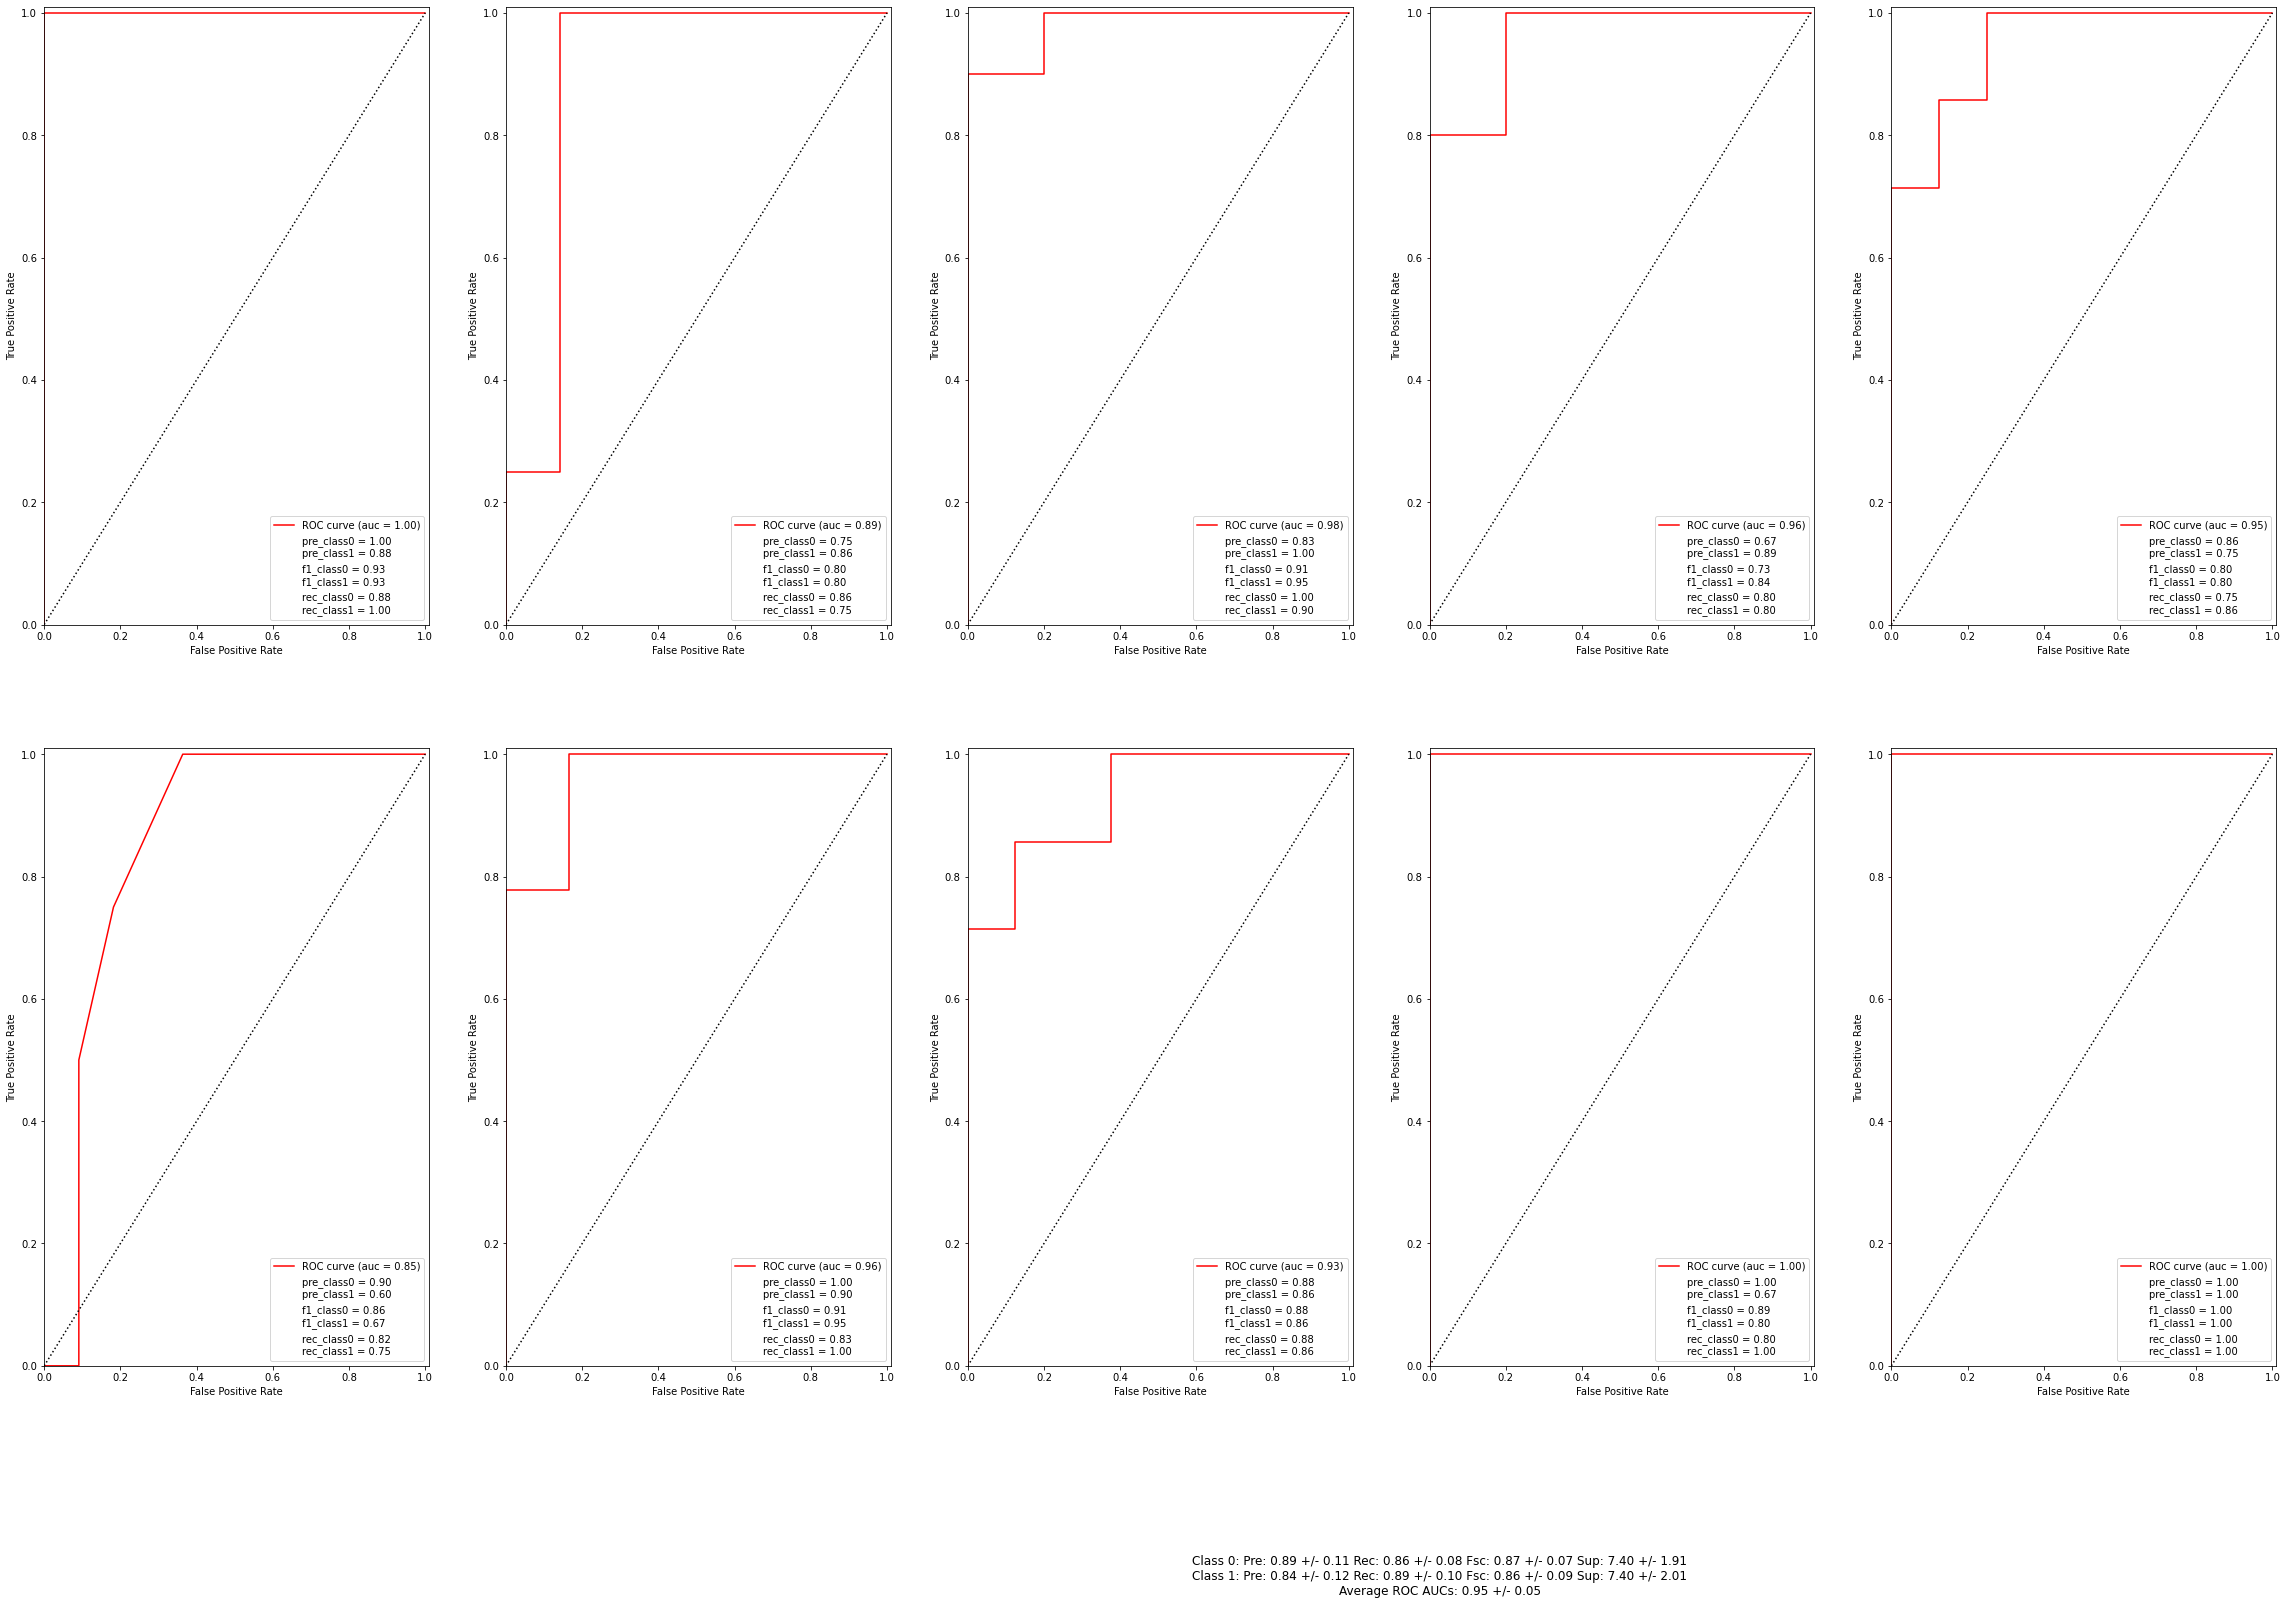


-----
Begin LogisticRegression
-----

----- LogisticRegression: Fold 0 -----
[9, 16, 37, 42, 46, 48, 53, 57, 60, 88, 109, 126, 129, 134, 136]
	Train indx [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  38
  39  40  41  43  44  45  47  49  50  51  52  54  55  56  58  59  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 127 128 130 131 132 133 135 137 138 139 140
 141 142 143 144 145 146 147]
	Test indx: [  9  16  37  42  46  48  53  57  60  88 109 126 129 134 136]
	Best parameters; {'C': 0.05, 'penalty': 'l2'}
	0.8779 (+/-0.1045) for {'C': 0.05, 'penalty': 'l2'}
	0.8729 (+/-0.1093) for {'C': 0.1, 'penalty': 'l2'}
	0.8603 (+/-0.1228) for {'C': 0.25, 'penalty': 'l2'}
	0.8510 (+/-0.1357) for {

----- LogisticRegression: Fold 4 -----
[8, 24, 27, 33, 43, 54, 58, 90, 91, 106, 114, 117, 130, 131, 142]
	Train indx [  0   1   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  26  28  29  30  31  32  34  35  36  37  38  39
  40  41  42  44  45  46  47  48  49  50  51  52  53  55  56  57  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 107 108 109 110 111 112 113 115 116 118 119
 120 121 122 123 124 125 126 127 128 129 132 133 134 135 136 137 138 139
 140 141 143 144 145 146 147]
	Test indx: [  8  24  27  33  43  54  58  90  91 106 114 117 130 131 142]
	Best parameters; {'C': 0.05, 'penalty': 'l2'}
	0.8741 (+/-0.1041) for {'C': 0.05, 'penalty': 'l2'}
	0.8730 (+/-0.1056) for {'C': 0.1, 'penalty': 'l2'}
	0.8609 (+/-0.1156) for {'C': 0.25, 'penalty': 'l2'}
	0.8500 (+/-0.1297) for {'C': 0.5, 'penalty': 'l2'}
	0.8445 (+/

[2, 12, 29, 62, 65, 85, 95, 101, 102, 104, 115, 118, 121, 147]
	Train indx [  0   1   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  63  64  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  86  87  88  89  90  91  92  93  94  96
  97  98  99 100 103 105 106 107 108 109 110 111 112 113 114 116 117 119
 120 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146]
	Test indx: [  2  12  29  62  65  85  95 101 102 104 115 118 121 147]
	Best parameters; {'C': 0.05, 'penalty': 'l2'}
	0.8487 (+/-0.1406) for {'C': 0.05, 'penalty': 'l2'}
	0.8442 (+/-0.1399) for {'C': 0.1, 'penalty': 'l2'}
	0.8332 (+/-0.1498) for {'C': 0.25, 'penalty': 'l2'}
	0.8183 (+/-0.1570) for {'C': 0.5, 'penalty': 'l2'}
	0.8161 (+/-0.1592) for {'C': 1.0, 'penalty': 'l2'}
	

In [45]:
cwf.kfold_test_classifiers_with_optimization(features_smote_df, classes_smote_df, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, scale=True, cv=5, n_repeats=10, smiles=None, names=None,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

In [46]:
directory_names = cwf.directory_names(kfold_clf_names)

In [47]:
directory_names

['NearestNeighbors',
 'GaussianProcess',
 'DecisionTree',
 'ExtraTreesClassifier',
 'AdaBoost',
 'LogisticRegression']

## Analyses the output over all folds and predictions therefore for all molecules
The next cell reads in the predictions from each fold (n_repeats max_folds should = n_repeats).


NearestNeighbors
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_nearestneighbors_morderd.png
['ddg_nearestneighbors_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 66, 'fp': 8, 'fn': 19, 'tp': 55}
[[66  8]
 [19 55]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

GaussianProcess
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_gaussianprocess_morderd.png
['ddg_nearestneighbors_morderd.png', 'ddg_gaussianprocess_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 63, 'fp': 11, 'fn': 8, 'tp': 66}
[[63 11]
 [ 8 66]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

DecisionTree
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_decisiontree_morderd.png
['ddg_nearestneighbors_morderd.png', 'ddg_gaussianprocess_morderd.png', 'ddg_decisiontree_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 57, 'fp': 17, 'fn': 11, 'tp': 63}
[[57 17]
 [11 63]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

ExtraTreesClassifier
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_extratreesclassifier_morderd.png
['ddg_nearestneighbors_morderd.png', 'ddg_gaussianprocess_morderd.png', 'ddg_decisiontree_morderd.png', 'ddg_extratreesclassifier_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 63, 'fp': 11, 'fn': 7, 'tp': 67}
[[63 11]
 [ 7 67]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

AdaBoost
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_adaboost_morderd.png
['ddg_nearestneighbors_morderd.png', 'ddg_gaussianprocess_morderd.png', 'ddg_decisiontree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 63, 'fp': 11, 'fn': 8, 'tp': 66}
[[63 11]
 [ 8 66]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

LogisticRegression
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_logisticregression_morderd.png
['ddg_nearestneighbors_morderd.png', 'ddg_gaussianprocess_morderd.png', 'ddg_decisiontree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png', 'ddg_logisticregression_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 51, 'fp': 23, 'fn': 8, 'tp': 66}
[[51 23]
 [ 8 66]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &  sensitivity &  specificity &       mcc &  precision &    g-mean \\
\midrule
nearest neighbors      &  0.817568 &     0.743243 &     0.891892 &  0.642271 &   0.873016 &  0.814182 \\
gaussian process       &  0.871622 &     0.891892 &     0.851351 &  0.743855 &   0.857143 &  0.871386 \\
decision tree          &  0.810811 &     0.851351 &     0.770270 &  0.623675 &   0.787500 &  0.809797 \\
extra trees classifier &  0.878378 &     0.905405 &     0.851351 &  0.757865 &   0.858974 &  0.877962 \\
adaboost               &  0.871622 &     0.891892 &     0.851351 &  0.743855 &   0.857143 &  0.871386 \\
logistic regression    &  0.790541 &     0.891892 &     0.689189 &  0.593400 &   0.741573 &  0.784017 \\
\bottomrule
\end{tabular}



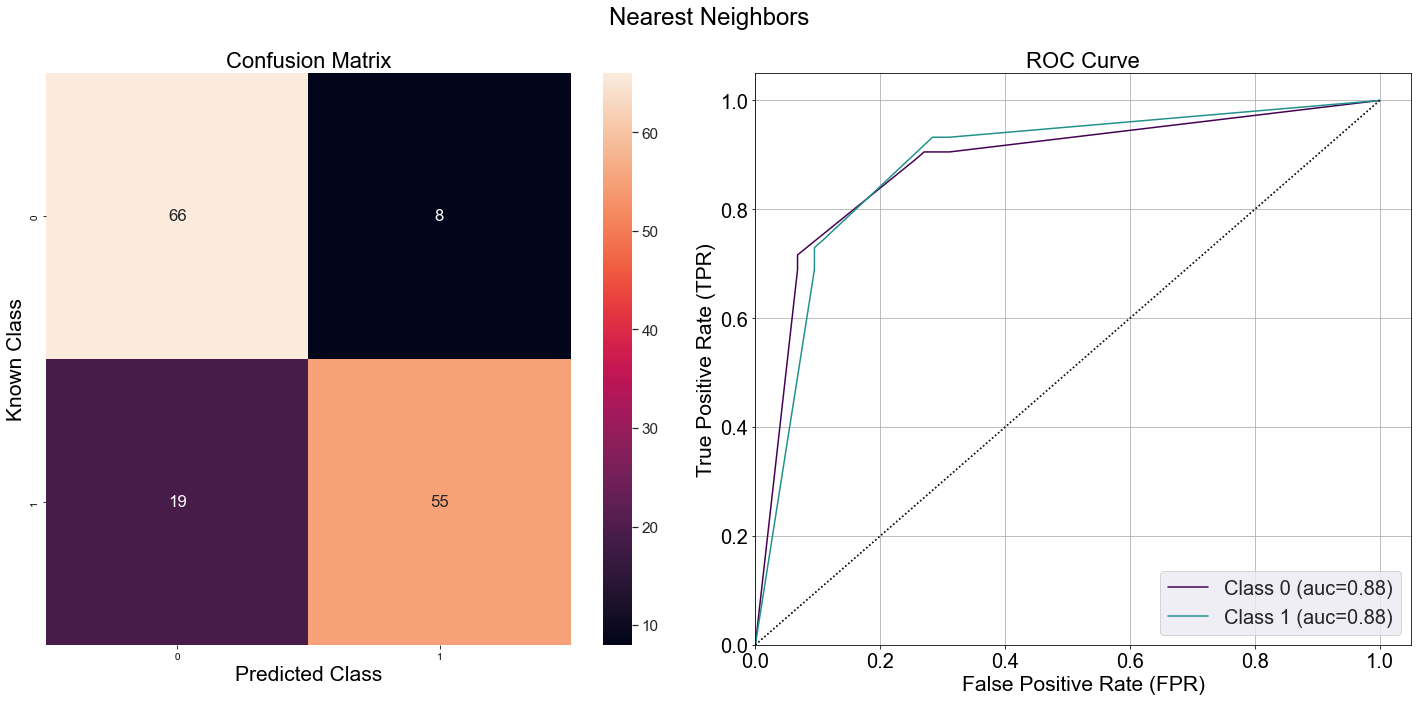

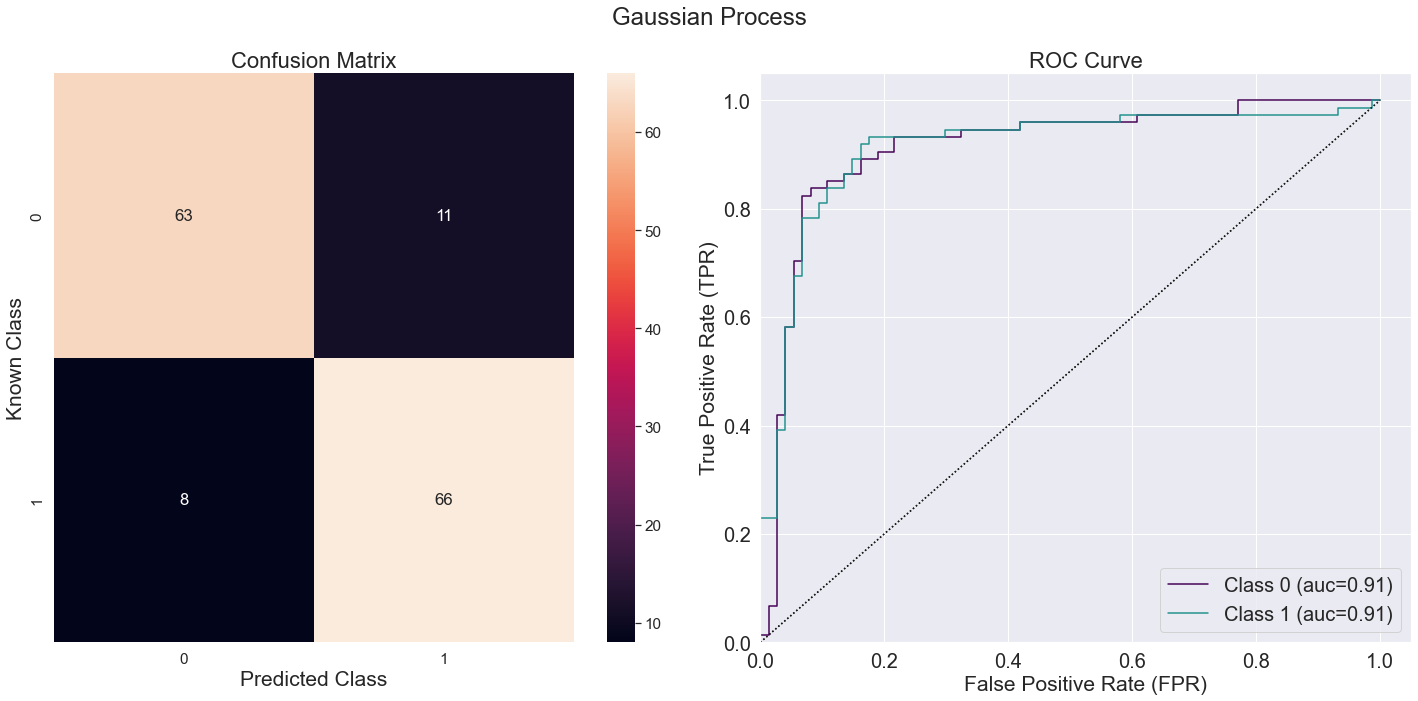

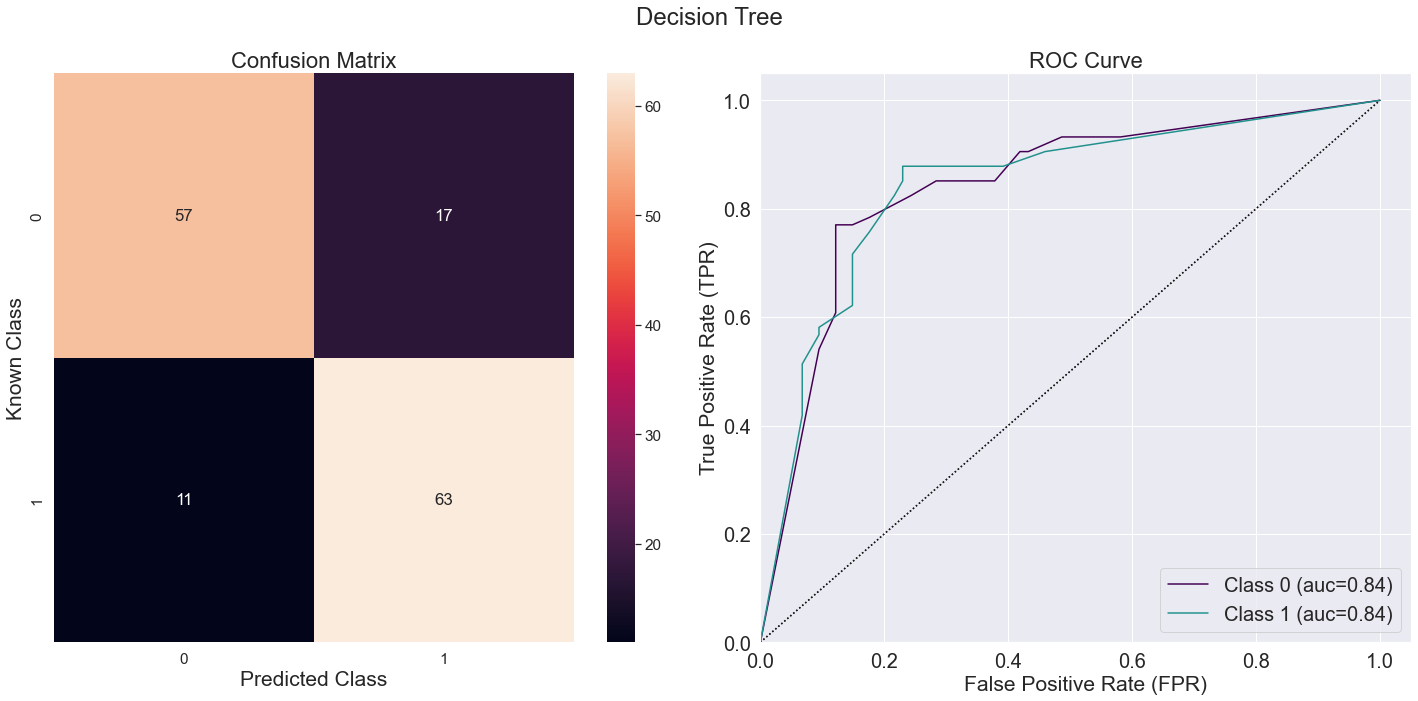

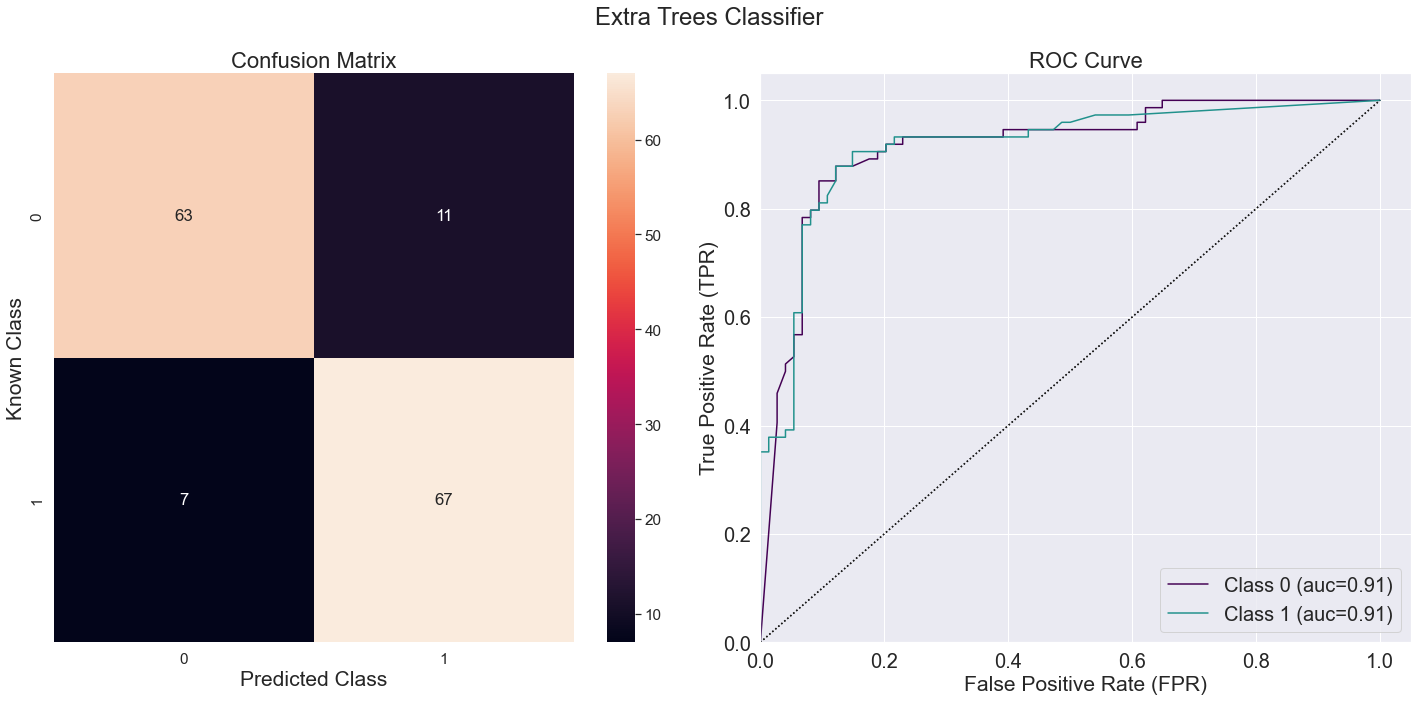

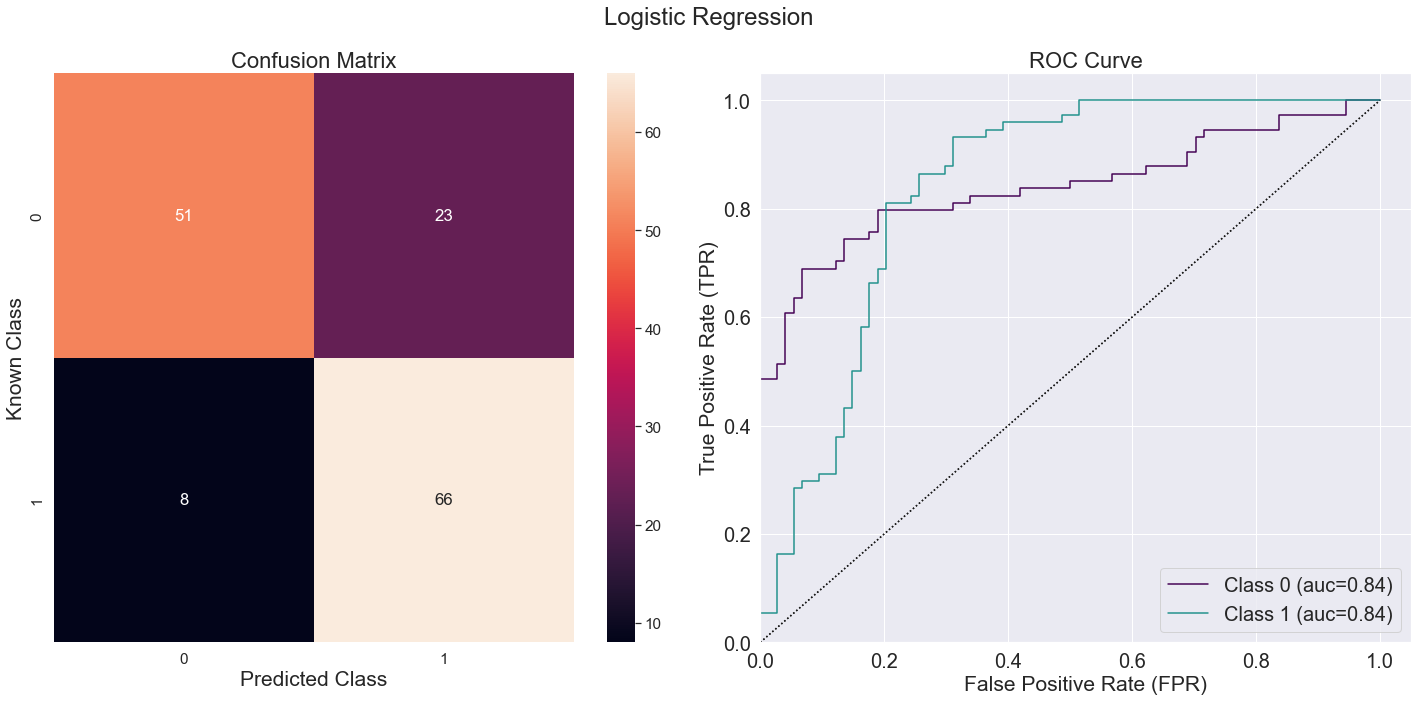

In [48]:
files_plt = []

kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Extra Trees Classifier", "AdaBoost",
         "Logistic Regression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = cwf.build_data_from_directory(dirname, max_folds=10)
    
#     log.debug("Last value in the data frame: {}".format(data[165:166]))
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_morderd.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_mordred.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
log.info(df_metrics_for_paper.to_latex())

In [49]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_mordred.png")

Combining 6 images
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
New image will be W:1440 H:4320
Image 0 added at offset height 0
Image 1 added at offset height 720
Image 2 added at offset height 1440
Image 3 added at offset height 2160
Image 4 added at offset height 2880
Image 5 added at offset height 3600


# Now first we split 90%-10% (train-test)

We need to evaluate the performace of our model on an external test set. If you are not familiar with the process please read the paper section where this is explained.

In [50]:
data = pd.read_csv("First_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [51]:
data

reaction                                    substrate  \
0           0       CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
1           1  C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3   
2           2       CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
3           3  C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3   
4           4       CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
..        ...                                          ...   
114       114                      C=CC/N=C(C)/C1=CC=CC=C1   
115       115       CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
116       116  C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3   
117       117              C/C(C1=CC=CC=C1)=N\CC2=CC=CC=C2   
118       118                      C=CC/N=C(C)/C1=CC=CC=C1   

                                              catalyst  solvent  solvent_code  \
0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...  toluene             0   
1    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...  toluene             0   
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
..                                                 ...      ...           ...   
114  CN(C([C@H](NC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1...  toluene             0   
115  [H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...  toluene             0   
116  [H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...  toluene             0   
117  [H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...  toluene             0   
118  [H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...  toluene             0   

     temperature  ee       ddg           paper  
0          -30.0  14  0.569810     Nature 2009  
1          -30.0  41  1.761325     Nature 2009  
2          -30.0  30  1.251493     Nature 2009  
3          -30.0  86  5.229434     Nature 2009  
4          -30.0  58  2.678563     Nature 2009  
..           ...  ..       ...             ...  
114        -75.0   0  0.000000  0ee - manually  
115        -30.0   0  0.000000  0ee - manually  
116        -30.0   0  0.000000  0ee - manually  
117        -75.0   0  0.000000  0ee - manually  
118        -75.0   0  0.000000  0ee - manually  

[119 rows x 9 columns]

We know which data points we are using for test set, for consistency reasons. However if you have much more data and you dont know which ones you want to use as a training set, or you don't want to write them manually you could do something like this:

import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.DataFrame(data)

X = df.drop('target', axis=1) y = df['target']

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print("X_test:") print(X_test)

print("y_test:") print(y_test)

In [52]:
test_reactions = [49, 33, 19, 1, 6, 51, 66,47, 58] 

In [53]:
reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64


we romove from the data the test reactions

In [54]:
train_data = data.drop(labels =test_reactions, axis=0,inplace = False)

In [55]:
train_data

reaction                                    substrate  \
0           0       CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
2           2       CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
3           3  C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3   
4           4       CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
5           5  C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3   
..        ...                                          ...   
114       114                      C=CC/N=C(C)/C1=CC=CC=C1   
115       115       CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
116       116  C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3   
117       117              C/C(C1=CC=CC=C1)=N\CC2=CC=CC=C2   
118       118                      C=CC/N=C(C)/C1=CC=CC=C1   

                                              catalyst  solvent  solvent_code  \
0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...  toluene             0   
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
5    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
..                                                 ...      ...           ...   
114  CN(C([C@H](NC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1...  toluene             0   
115  [H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...  toluene             0   
116  [H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...  toluene             0   
117  [H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...  toluene             0   
118  [H]N(C(CNC(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=S...  toluene             0   

     temperature  ee       ddg           paper  
0          -30.0  14  0.569810     Nature 2009  
2          -30.0  30  1.251493     Nature 2009  
3          -30.0  86  5.229434     Nature 2009  
4          -30.0  58  2.678563     Nature 2009  
5          -30.0  90  5.952686     Nature 2009  
..           ...  ..       ...             ...  
114        -75.0   0  0.000000  0ee - manually  
115        -30.0   0  0.000000  0ee - manually  
116        -30.0   0  0.000000  0ee - manually  
117        -75.0   0  0.000000  0ee - manually  
118        -75.0   0  0.000000  0ee - manually  

[110 rows x 9 columns]

and we generate the test dataframe

In [56]:
test_data = pd.DataFrame()
test_data = data.iloc[test_reactions]

In [57]:
test_data

reaction                                       substrate  \
49        49   COC(C=C1)=CC=C1/C=N/C(C2=CC=CC=C2)C3=CC=CC=C3   
33        33               C=CC/N=C(C)/C1=CC(C=CC=C2)=C2C=C1   
19        19  N#CC(C=C1)=CC=C1/C=N/C(C2=CC=CC=C2)C3=CC=CC=C3   
1          1     C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3   
6          6          CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
51        51          CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
66        66          CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   
47        47             C/C(C1=CC=CC=C1)=N\CC2=CC=C(Br)C=C2   
58        58          CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2   

                                             catalyst  solvent  solvent_code  \
49  CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
33  O=C([C@@H](C(C)(C)C)NC(N[C@@H]1[C@@H](/N=C/C2=...  toluene             0   
19  CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
1   CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...  toluene             0   
6   CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
51  CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   
66  O=C([C@H](C)NC(NC1=CC=CC=C1)=S)N(C)C(C2=CC=CC=...  toluene             0   
47  O=C([C@@H](C(C)(C)C)NC(N[C@@H]1[C@@H](/N=C/C2=...  toluene             0   
58  CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...  toluene             0   

    temperature  ee       ddg         paper  
49        -30.0  96  7.867979     JACS 2009  
33        -75.0  89  4.685297  ORGLETT 2000  
19        -30.0  93  6.705437   Nature 2009  
1         -30.0  41  1.761325   Nature 2009  
6         -30.0  77  4.125533   Nature 2009  
51        -30.0  97  8.003605     JACS 2009  
66        -30.0  91  6.391000     JACS 2009  
47        -75.0  92  5.235901  ORGLETT 2000  
58        -30.0  28  1.188311     JACS 2009

In [58]:
substratesmiles_train = train_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_train.head()))

catalystsmiles_train = train_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_train.head()))

ddg_train = train_data["ddg"]
log.info("DGG: {}".format(ddg_train.head()))

Substrate SMILES: 0         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
2         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
3    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
4         CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
5    C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
2    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
3    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
4    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
5    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
Name: catalyst, dtype: object
DGG: 0    0.569810
2    1.251493
3    5.229434
4    2.678563
5    5.952686
Name: ddg, dtype: float64


In [59]:
target_train = ddg_train

In [60]:
substratesmiles_test = test_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_test.head()))

catalystsmiles_test = test_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_test.head()))

ddg_test = test_data["ddg"]
log.info("DGG: {}".format(ddg_test.head()))

Substrate SMILES: 49     COC(C=C1)=CC=C1/C=N/C(C2=CC=CC=C2)C3=CC=CC=C3
33                 C=CC/N=C(C)/C1=CC(C=CC=C2)=C2C=C1
19    N#CC(C=C1)=CC=C1/C=N/C(C2=CC=CC=C2)C3=CC=CC=C3
1        C(C1=CC=CC=C1)(C2=CC=CC=C2)/N=C/C3=CC=CC=C3
6             CC(C)(C)/C=N/C(C1=CC=CC=C1)C2=CC=CC=C2
Name: substrate, dtype: object
Catalyst SMILES: 49    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
33    O=C([C@@H](C(C)(C)C)NC(N[C@@H]1[C@@H](/N=C/C2=...
19    CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
1     CN(C)C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(...
6     CN(C([C@@H](C(C)(C)C)NC(NC1=CC(C(F)(F)F)=CC(C(...
Name: catalyst, dtype: object
DGG: 49    7.867979
33    4.685297
19    6.705437
1     1.761325
6     4.125533
Name: ddg, dtype: float64


In [61]:
target_test = ddg_test

Generating Mordred Descriptors for the training set

First for the substrates

In [62]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list_train = [mi.get_mol_from_smiles(s) for s in substratesmiles_train]
subfeatures_df_train = calc.pandas(submolecule_list_train)

100%|██████████| 110/110 [00:17<00:00,  6.43it/s]


In [63]:
subfeatures_df_train.dropna(inplace=True, thresh=int(0.9*len(subfeatures_df_train.index)))
threshold = 0.5
subfeatures_df_train.drop(subfeatures_df_train.std()[subfeatures_df_train.std() < threshold].index.values, axis=1)
subfeatures_df_train.columns = [ent.strip() for ent in subfeatures_df_train.columns]
subfeatures_df_train.head()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0  14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
1  14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
2  16.182576  12.923224      0      0  28.376768  2.343528  4.687055   
3  14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
4  16.182576  12.923224      0      0  28.376768  2.343528  4.687055   

      SpAD_A   SpMAD_A   LogEE_A  ...     SRW10     TSRW10        MW  \
0  23.734067  1.249161  3.853399  ...  9.625162  51.858564  251.1674   
1  23.734067  1.249161  3.853399  ...  9.625162  51.858564  251.1674   
2  28.376768  1.351275  3.966671  ...  9.687009  54.282362  271.1361   
3  23.734067  1.249161  3.853399  ...  9.625162  51.858564  251.1674   
4  28.376768  1.351275  3.966671  ...  9.687009  54.282362  271.1361   

        AMW  WPath  WPol  Zagreb1  Zagreb2  mZagreb1  mZagreb2  
0  6.279185    706    24     94.0    104.0  6.395833  4.180556  
1  6.279185    706    24     94.0    104.0  6.395833  4.180556  
2  7.135161    958    28    104.0    118.0  4.694444  4.805556  
3  6.279185    706    24     94.0    104.0  6.395833  4.180556  
4  7.135161    958    28    104.0    118.0  4.694444  4.805556  

[5 rows x 1826 columns]

In [64]:
subfeatures_df_train

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0    14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
1    14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
2    16.182576  12.923224      0      0  28.376768  2.343528  4.687055   
3    14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
4    16.182576  12.923224      0      0  28.376768  2.343528  4.687055   
..         ...        ...    ...    ...        ...       ...       ...   
105   8.554231   7.960160      0      0  15.368571  2.224278  4.448556   
106  14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
107  16.182576  12.923224      0      0  28.376768  2.343528  4.687055   
108  12.089765  10.061032      0      0  21.313564  2.247466  4.494933   
109   8.554231   7.960160      0      0  15.368571  2.224278  4.448556   

        SpAD_A   SpMAD_A   LogEE_A  ...     SRW10     TSRW10          MW  \
0    23.734067  1.249161  3.853399  ...  9.625162  51.858564  251.167400   
1    23.734067  1.249161  3.853399  ...  9.625162  51.858564  251.167400   
2    28.376768  1.351275  3.966671  ...  9.687009  54.282362  271.136100   
3    23.734067  1.249161  3.853399  ...  9.625162  51.858564  251.167400   
4    28.376768  1.351275  3.966671  ...  9.687009  54.282362  271.136100   
..         ...       ...       ...  ...       ...        ...         ...   
105  15.368571  1.280714  3.361095  ...  8.798606  41.463281  159.104799   
106  23.734067  1.249161  3.853399  ...  9.625162  51.858564  251.167400   
107  28.376768  1.351275  3.966671  ...  9.687009  54.282362  271.136100   
108  21.313564  1.332098  3.680451  ...  9.260558  47.520971  209.120449   
109  15.368571  1.280714  3.361095  ...  8.798606  41.463281  159.104799   

          AMW  WPath  WPol  Zagreb1  Zagreb2  mZagreb1  mZagreb2  
0    6.279185    706    24     94.0    104.0  6.395833  4.180556  
1    6.279185    706    24     94.0    104.0  6.395833  4.180556  
2    7.135161    958    28    104.0    118.0  4.694444  4.805556  
3    6.279185    706    24     94.0    104.0  6.395833  4.180556  
4    7.135161    958    28    104.0    118.0  4.694444  4.805556  
..        ...    ...   ...      ...      ...       ...       ...  
105  6.364192    218    13     52.0     56.0  4.222222  2.944444  
106  6.279185    706    24     94.0    104.0  6.395833  4.180556  
107  7.135161    958    28    104.0    118.0  4.694444  4.805556  
108  6.745821    496    19     76.0     84.0  4.333333  3.694444  
109  6.364192    218    13     52.0     56.0  4.222222  2.944444  

[110 rows x 1826 columns]

In [65]:
log.info(subfeatures_df_train)
subfeatures_types = "some_categorical" 

           ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0    14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
1    14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
2    16.182576  12.923224      0      0  28.376768  2.343528  4.687055   
3    14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
4    16.182576  12.923224      0      0  28.376768  2.343528  4.687055   
..         ...        ...    ...    ...        ...       ...       ...   
105   8.554231   7.960160      0      0  15.368571  2.224278  4.448556   
106  14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
107  16.182576  12.923224      0      0  28.376768  2.343528  4.687055   
108  12.089765  10.061032      0      0  21.313564  2.247466  4.494933   
109   8.554231   7.960160      0      0  15.368571  2.224278  4.448556   

        SpAD_A   SpMAD_A   LogEE_A  ...     SRW10     TSRW10          MW  \
0    23.734067  1.249161  3.853399 

Mordred for catalysts

In [66]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list_train = [mi.get_mol_from_smiles(s) for s in catalystsmiles_train]
catfeatures_df_train = calc.pandas(catmolecule_list_train)

100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


# Pearsons Correlation

In [67]:
catfeatures_df_train.dropna(inplace=True, thresh=int(0.9*len(catfeatures_df_train.index)))
threshold = 0.5
catfeatures_df_train.drop(catfeatures_df_train.std()[catfeatures_df_train.std() < threshold].index.values, axis=1)
catfeatures_df_train.columns = [ent.strip() for ent in catfeatures_df_train.columns]
catfeatures_df_train.head()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0  21.401108  19.292802      0      0  30.867985  2.425439  4.850878   
1  26.241465  22.162609      0      0  39.436111  2.426470  4.852941   
2  26.241465  22.162609      0      0  39.436111  2.426470  4.852941   
3  26.977082  23.080194      0      0  40.925850  2.428813  4.857626   
4  26.977082  23.080194      0      0  40.925850  2.428813  4.857626   

      SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  \
0  30.867985  1.102428  4.224506  ...  10.282506  63.404103  429.130953   
1  39.436111  1.159886  4.427881  ...  10.440303  70.325912  505.162253   
2  39.436111  1.159886  4.427881  ...  10.440303  70.325912  505.162253   
3  40.925850  1.169310  4.457444  ...  10.507612  71.558608  519.177903   
4  40.925850  1.169310  4.457444  ...  10.507612  71.558608  519.177903   

        AMW  WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2  
0  8.757775   2068    43    144.0    162.0  15.215278  5.722222  
1  8.562072   3643    52    176.0    199.0  15.826389  7.055556  
2  8.562072   3643    52    176.0    199.0  15.826389  7.055556  
3  8.373837   3880    56    182.0    208.0  16.687500  7.277778  
4  8.373837   3880    56    182.0    208.0  16.687500  7.277778  

[5 rows x 1826 columns]

In [68]:
catfeatures_df_train

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0    21.401108  19.292802      0      0  30.867985  2.425439  4.850878   
1    26.241465  22.162609      0      0  39.436111  2.426470  4.852941   
2    26.241465  22.162609      0      0  39.436111  2.426470  4.852941   
3    26.977082  23.080194      0      0  40.925850  2.428813  4.857626   
4    26.977082  23.080194      0      0  40.925850  2.428813  4.857626   
..         ...        ...    ...    ...        ...       ...       ...   
105  21.401108  19.292802      0      0  30.867985  2.425439  4.850878   
106  16.714811  14.859531      0      0  24.619317  2.420606  4.841212   
107  16.714811  14.859531      0      0  24.619317  2.420606  4.841212   
108  16.714811  14.859531      0      0  24.619317  2.420606  4.841212   
109  16.714811  14.859531      0      0  24.619317  2.420606  4.841212   

        SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  \
0    30.867985  1.102428  4.224506  ...  10.282506  63.404103  429.130953   
1    39.436111  1.159886  4.427881  ...  10.440303  70.325912  505.162253   
2    39.436111  1.159886  4.427881  ...  10.440303  70.325912  505.162253   
3    40.925850  1.169310  4.457444  ...  10.507612  71.558608  519.177903   
4    40.925850  1.169310  4.457444  ...  10.507612  71.558608  519.177903   
..         ...       ...       ...  ...        ...        ...         ...   
105  30.867985  1.102428  4.224506  ...  10.282506  63.404103  429.130953   
106  24.619317  1.119060  3.980739  ...   9.917144  55.875510  345.037052   
107  24.619317  1.119060  3.980739  ...   9.917144  55.875510  345.037052   
108  24.619317  1.119060  3.980739  ...   9.917144  55.875510  345.037052   
109  24.619317  1.119060  3.980739  ...   9.917144  55.875510  345.037052   

           AMW  WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2  
0     8.757775   2068    43    144.0    162.0  15.215278  5.722222  
1     8.562072   3643    52    176.0    199.0  15.826389  7.055556  
2     8.562072   3643    52    176.0    199.0  15.826389  7.055556  
3     8.373837   3880    56    182.0    208.0  16.687500  7.277778  
4     8.373837   3880    56    182.0    208.0  16.687500  7.277778  
..         ...    ...   ...      ...      ...        ...       ...  
105   8.757775   2068    43    144.0    162.0  15.215278  5.722222  
106  11.130227   1095    30    110.0    121.0  11.180556  4.583333  
107  11.130227   1095    30    110.0    121.0  11.180556  4.583333  
108  11.130227   1095    30    110.0    121.0  11.180556  4.583333  
109  11.130227   1095    30    110.0    121.0  11.180556  4.583333  

[110 rows x 1826 columns]

In [69]:
log.info(catfeatures_df_train)
catfeatures_types = "some_categorical" 

           ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0    21.401108  19.292802      0      0  30.867985  2.425439  4.850878   
1    26.241465  22.162609      0      0  39.436111  2.426470  4.852941   
2    26.241465  22.162609      0      0  39.436111  2.426470  4.852941   
3    26.977082  23.080194      0      0  40.925850  2.428813  4.857626   
4    26.977082  23.080194      0      0  40.925850  2.428813  4.857626   
..         ...        ...    ...    ...        ...       ...       ...   
105  21.401108  19.292802      0      0  30.867985  2.425439  4.850878   
106  16.714811  14.859531      0      0  24.619317  2.420606  4.841212   
107  16.714811  14.859531      0      0  24.619317  2.420606  4.841212   
108  16.714811  14.859531      0      0  24.619317  2.420606  4.841212   
109  16.714811  14.859531      0      0  24.619317  2.420606  4.841212   

        SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  \
0    30.867985  1.102428  4.224506

# Pearson correlation coefficent 

In [70]:
subreasonable_predicted_properties, subsignificant_features = cwf.find_correlating_features(subfeatures_df_train, target_train, thresh=0.39, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0      0.569810
2      1.251493
3      5.229434
4      2.678563
5      5.952686
         ...   
114    0.000000
115    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: ddg, Length: 110, dtype: float64
Significance will be calculated for the correlations
GATS3c: -0.4745 P: 0.0002 Significant at 0.0500 level? True
GATS3se: -0.5000 P: 0.0002 Significant at 0.0500 level? True
GATS3pe: -0.4285 P: 0.0002 Significant at 0.0500 level? True
GATS3are: -0.4601 P: 0.0002 Significant at 0.0500 level? True
Lipinski: -0.3991 P: 0.0002 Significant at 0.0500 level? True


In [71]:
log.info("{} {}".format(subreasonable_predicted_properties, len(subreasonable_predicted_properties)))
log.info("{} {}".format(subsignificant_features, len(subsignificant_features)))
use_significant = True
use_reasonable = False

['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski'] 5
['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski'] 5


In [72]:
catreasonable_predicted_properties, catsignificant_features = cwf.find_correlating_features(catfeatures_df_train, target_train, thresh=0.50, 
                                                                                      plot=False, corr_method="pearson", 
                                                                                      sig_metric="pearson", process_non_numeric=True, 
                                                                                      sig_level=0.05, significance=True, n_sample=5000)

0      0.569810
2      1.251493
3      5.229434
4      2.678563
5      5.952686
         ...   
114    0.000000
115    0.000000
116    0.000000
117    0.000000
118    0.000000
Name: ddg, Length: 110, dtype: float64
Significance will be calculated for the correlations
ABCGG: 0.5599 P: 0.0002 Significant at 0.0500 level? True
SpAbs_A: 0.5201 P: 0.0002 Significant at 0.0500 level? True
SpAD_A: 0.5201 P: 0.0002 Significant at 0.0500 level? True
LogEE_A: 0.5215 P: 0.0002 Significant at 0.0500 level? True
VE3_A: 0.6329 P: 0.0002 Significant at 0.0500 level? True
nHeavyAtom: 0.5073 P: 0.0002 Significant at 0.0500 level? True
nC: 0.5159 P: 0.0002 Significant at 0.0500 level? True
ATS4d: 0.5362 P: 0.0002 Significant at 0.0500 level? True
ATS5d: 0.5765 P: 0.0002 Significant at 0.0500 level? True
ATS6d: 0.5719 P: 0.0002 Significant at 0.0500 level? True
ATS7d: 0.5631 P: 0.0002 Significant at 0.0500 level? True
ATS5s: 0.5146 P: 0.0002 Significant at 0.0500 level? True
ATS7s: 0.5647 P: 0.0002 Signi

VR3_DzZ: 0.5233 P: 0.0002 Significant at 0.0500 level? True
VE1_Dzm: 0.5224 P: 0.0002 Significant at 0.0500 level? True
VE2_Dzm: -0.5324 P: 0.0002 Significant at 0.0500 level? True
VE3_Dzm: 0.5287 P: 0.0002 Significant at 0.0500 level? True
VR3_Dzm: 0.5234 P: 0.0002 Significant at 0.0500 level? True
VE1_Dzv: 0.5264 P: 0.0002 Significant at 0.0500 level? True
VE2_Dzv: -0.5285 P: 0.0002 Significant at 0.0500 level? True
VE3_Dzv: 0.5300 P: 0.0002 Significant at 0.0500 level? True
VR3_Dzv: 0.5198 P: 0.0002 Significant at 0.0500 level? True
VE1_Dzse: 0.5225 P: 0.0002 Significant at 0.0500 level? True
VE2_Dzse: -0.5323 P: 0.0002 Significant at 0.0500 level? True
VE3_Dzse: 0.5287 P: 0.0002 Significant at 0.0500 level? True
VR3_Dzse: 0.5233 P: 0.0002 Significant at 0.0500 level? True
VE1_Dzpe: 0.5223 P: 0.0002 Significant at 0.0500 level? True
VE2_Dzpe: -0.5325 P: 0.0002 Significant at 0.0500 level? True
VE3_Dzpe: 0.5287 P: 0.0002 Significant at 0.0500 level? True
VR3_Dzpe: 0.5235 P: 0.0002 Si

In [73]:
log.info("{} {}".format(catreasonable_predicted_properties, len(catreasonable_predicted_properties)))
log.info("{} {}".format(catsignificant_features, len(catsignificant_features)))
use_significant = True
use_reasonable = False

['ABCGG', 'SpAbs_A', 'SpAD_A', 'LogEE_A', 'VE3_A', 'nHeavyAtom', 'nC', 'ATS4d', 'ATS5d', 'ATS6d', 'ATS7d', 'ATS5s', 'ATS7s', 'ATS4Z', 'ATS5Z', 'ATS6Z', 'ATS7Z', 'ATS8Z', 'ATS1m', 'ATS4m', 'ATS5m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS5se', 'ATS6se', 'ATS7se', 'ATS8se', 'ATS5pe', 'ATS6pe', 'ATS7pe', 'ATS8pe', 'ATS5are', 'ATS6are', 'ATS7are', 'ATS8are', 'ATS0p', 'ATS4p', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS8p', 'ATS5i', 'ATS6i', 'ATS7i', 'ATS8i', 'AATS6dv', 'AATS7dv', 'AATS8dv', 'AATS6s', 'AATS8s', 'AATS6Z', 'AATS7Z', 'AATS6m', 'AATS7m', 'AATS1se', 'AATS3se', 'AATS6se', 'AATS7se', 'AATS8se', 'AATS6pe', 'AATS7pe', 'AATS8pe', 'AATS1are', 'AATS6are', 'AATS7are', 'AATS8are', 'AATS1i', 'AATS5i', 'AATS6i', 'AATS8i', 'ATSC3c', 'ATSC3dv', 'ATSC0Z', 'ATSC1Z', 'ATSC4Z', 'ATSC0m', 'ATSC1m', 'ATSC4m', 'ATSC4v', 'ATSC6v', 'ATSC8v', 'ATSC1se', 'ATSC3se', 'ATSC1pe', 'ATSC3pe', 'ATSC1are', 'ATSC3are', 'ATSC0p', 'ATSC6p', 'ATSC5i', 'AATSC0c', 'AATSC1c', 'AATSC2c', 'AATSC

In [74]:
subfeats_df_train = pd.DataFrame()

if use_significant is True:
    for k in subsignificant_features:
        subfeats_df_train[k] = subfeatures_df_train[k]
        
elif use_reasonable is True:
    for k in subreasonable_predicted_properties:
        subfeats_df_train[k] = subfeatures_df_train[k]

In [75]:
catfeats_df_train = pd.DataFrame()

if use_significant is True:
    for k in catsignificant_features:
        catfeats_df_train[k] = catfeatures_df_train[k]
        
elif use_reasonable is True:
    for k in catreasonable_predicted_properties:
        catfeats_df_train[k] = catfeatures_df_train[k]

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [76]:
features_df_train = subfeats_df_train.join(catfeats_df_train, lsuffix="subfeats_df_train", rsuffix="catfeats_df_train")

In [77]:
features_df_train

GATS3c   GATS3se   GATS3pe  GATS3are  Lipinski      ABCGG    SpAbs_A  \
0    1.101164  1.187627  1.169919  1.166806      True  19.292802  30.867985   
1    1.101164  1.187627  1.169919  1.166806      True  22.162609  39.436111   
2    0.981164  1.031415  0.978073  0.989808      True  22.162609  39.436111   
3    1.101164  1.187627  1.169919  1.166806      True  23.080194  40.925850   
4    0.981164  1.031415  0.978073  0.989808      True  23.080194  40.925850   
..        ...       ...       ...       ...       ...        ...        ...   
105  1.306779  1.612830  1.359694  1.462054      True  19.292802  30.867985   
106  1.101164  1.187627  1.169919  1.166806      True  14.859531  24.619317   
107  0.981164  1.031415  0.978073  0.989808      True  14.859531  24.619317   
108  1.250566  1.431267  1.258747  1.323399      True  14.859531  24.619317   
109  1.306779  1.612830  1.359694  1.462054      True  14.859531  24.619317   

        SpAD_A   LogEE_A     VE3_A  ...      GGI9      JGI5   VAdjMat  MWC01  \
0    30.867985  4.224506  2.513060  ...  0.706875  0.035313  5.807355   28.0   
1    39.436111  4.427881  2.757223  ...  0.798125  0.034483  6.129283   35.0   
2    39.436111  4.427881  2.757223  ...  0.798125  0.034483  6.129283   35.0   
3    40.925850  4.457444  2.856647  ...  0.798125  0.036544  6.169925   36.0   
4    40.925850  4.457444  2.856647  ...  0.798125  0.036544  6.169925   36.0   
..         ...       ...       ...  ...       ...       ...       ...    ...   
105  30.867985  4.224506  2.513060  ...  0.706875  0.035313  5.807355   28.0   
106  24.619317  3.980739  2.138716  ...  0.271250  0.041450  5.459432   22.0   
107  24.619317  3.980739  2.138716  ...  0.271250  0.041450  5.459432   22.0   
108  24.619317  3.980739  2.138716  ...  0.271250  0.041450  5.459432   22.0   
109  24.619317  3.980739  2.138716  ...  0.271250  0.041450  5.459432   22.0   

        MWC02     MWC03      TMWC10     SRW02          MW  mZagreb2  
0    4.976734  5.783825  132.002665  4.043051  429.130953  5.722222  
1    5.176150  5.988961  146.665473  4.262680  505.162253  7.055556  
2    5.176150  5.988961  146.665473  4.262680  505.162253  7.055556  
3    5.209486  6.033086  149.213052  4.290459  519.177903  7.277778  
4    5.209486  6.033086  149.213052  4.290459  519.177903  7.277778  
..        ...       ...         ...       ...         ...       ...  
105  4.976734  5.783825  132.002665  4.043051  429.130953  5.722222  
106  4.709530  5.493061  116.994197  3.806662  345.037052  4.583333  
107  4.709530  5.493061  116.994197  3.806662  345.037052  4.583333  
108  4.709530  5.493061  116.994197  3.806662  345.037052  4.583333  
109  4.709530  5.493061  116.994197  3.806662  345.037052  4.583333  

[110 rows x 236 columns]

# Classify the training set

In [78]:
classes_train=[]
for index, value in ddg_train.items():
    if value < 4:
        classes_train.append(0)
    else:
        classes_train.append(1)

In [79]:
classes_train
class_targets_df_train = pd.DataFrame(np.array([classes_train]).T, columns=["classes"])
features_and_classes_df_train = features_df_train.copy()
features_and_classes_df_train["classes"] = classes_train

In [80]:
class_targets_df_train["classes"].values

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [81]:
features_df_train.to_csv("features_train.csv")

# Data Scalling

In [82]:
feature_types = "no_categorical"
# NOTE: USER DEFINES THE LIST BELOW!!!!!!
categorical_indxs = [4]
feature_columns = features_df_train.columns

# Backup
backup_feats_df = features_df_train.copy()

# None categorical only scale the data as numbers
if feature_types == "no_categorical":
    mm_scaler = MinMaxScaler()
    features_df_train = mm_scaler.fit_transform(features_df_train)
    log.info(pd.DataFrame(features_df_train, columns=feature_columns))
    features_df_train = pd.DataFrame(features_df_train, columns=feature_columns)
    
# Some categorical - Need to provide the indexes
elif feature_types == "some_categorical":
    numeric_features = [feature_columns[i] for i in range(len(feature_columns)) if i not in categorical_indxs]
    numerical_transformer = MinMaxScaler()
    categorical_features = [feature_columns[i] for i in range(len(feature_columns)) if i in categorical_indxs]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    if any(ent in categorical_features for ent in numeric_features):
        log.warning("WARNING - numeric and categorical feature specififed overlap")
        log.info(numeric_features)
        log.info(categorical_features)
    else:
        log.info("Numerical features:\n{} {}".format(numeric_features, len(numeric_features)))
        log.info("Categorical features:\n{} {}".format(categorical_features, len(categorical_indxs)))
    
    preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)])
    
    features_df_train = preprocessor.fit_transform(features_df_train)
    feature_names = cwf.get_feature_names_from_column_transformers(preprocessor)
    categorical_indxs = [i for i in range(len(numeric_features), len(feature_names))]
    log.info(feature_names)

    log.info(pd.DataFrame(features_df_train, columns=feature_names))
    features_df_train = pd.DataFrame(features_df_train, columns=feature_names)
    log.info("categorical indexes {}".format(categorical_indxs))
    log.info("Categorical features start on column name {} and end on {}".format(features_df_train.columns[categorical_indxs[0]], features_df_train.columns[categorical_indxs[-1]]))
    
# All categorical
elif feature_types == "categorical":
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    features_df_train = categorical_transformer.fit_transform(features_df_train).toarray()
    feature_names = [categorical_transformer.get_feature_names(feature_columns)]
    features_df_train = pd.DataFrame(features_df_train, columns=feature_names)
    log.info(features_df_train)

# No scaling or other encoding
else:
    log.info("No scaling")

       GATS3c   GATS3se   GATS3pe  GATS3are  Lipinski     ABCGG   SpAbs_A  \
0    0.470082  0.553726  0.673958  0.609793       1.0  0.353795  0.212116   
1    0.470082  0.553726  0.673958  0.609793       1.0  0.582818  0.502967   
2    0.308767  0.428474  0.477957  0.447722       1.0  0.582818  0.502967   
3    0.470082  0.553726  0.673958  0.609793       1.0  0.656045  0.553537   
4    0.308767  0.428474  0.477957  0.447722       1.0  0.656045  0.553537   
..        ...       ...       ...       ...       ...       ...       ...   
105  0.746488  0.894660  0.867844  0.880143       1.0  0.353795  0.212116   
106  0.470082  0.553726  0.673958  0.609793       1.0  0.000000  0.000000   
107  0.308767  0.428474  0.477957  0.447722       1.0  0.000000  0.000000   
108  0.670921  0.749080  0.764710  0.753181       1.0  0.000000  0.000000   
109  0.746488  0.894660  0.867844  0.880143       1.0  0.000000  0.000000   

       SpAD_A   LogEE_A     VE3_A  ...      GGI9      JGI5   VAdjMat  MWC01

# Synthetic Sampling for the training

In [83]:
nneighbours = min(5, len(class_targets_df_train[class_targets_df_train["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No categorical
if feature_types == "no_categorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some categorical - Need to provide the indexes
elif feature_types == "some_categorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=categorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All categorical
elif feature_types == "categorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


In [84]:
log.info("Feature decriptions:\n{}".format(features_df_train.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df_train.columns.values))

Feature decriptions:
['GATS3c' 'GATS3se' 'GATS3pe' 'GATS3are' 'Lipinski' 'ABCGG' 'SpAbs_A'
 'SpAD_A' 'LogEE_A' 'VE3_A' 'nHeavyAtom' 'nC' 'ATS4d' 'ATS5d' 'ATS6d'
 'ATS7d' 'ATS5s' 'ATS7s' 'ATS4Z' 'ATS5Z' 'ATS6Z' 'ATS7Z' 'ATS8Z' 'ATS1m'
 'ATS4m' 'ATS5m' 'ATS7m' 'ATS8m' 'ATS0v' 'ATS4v' 'ATS5v' 'ATS6v' 'ATS7v'
 'ATS8v' 'ATS5se' 'ATS6se' 'ATS7se' 'ATS8se' 'ATS5pe' 'ATS6pe' 'ATS7pe'
 'ATS8pe' 'ATS5are' 'ATS6are' 'ATS7are' 'ATS8are' 'ATS0p' 'ATS4p' 'ATS5p'
 'ATS6p' 'ATS7p' 'ATS8p' 'ATS5i' 'ATS6i' 'ATS7i' 'ATS8i' 'AATS6dv'
 'AATS7dv' 'AATS8dv' 'AATS6s' 'AATS8s' 'AATS6Z' 'AATS7Z' 'AATS6m' 'AATS7m'
 'AATS1se' 'AATS3se' 'AATS6se' 'AATS7se' 'AATS8se' 'AATS6pe' 'AATS7pe'
 'AATS8pe' 'AATS1are' 'AATS6are' 'AATS7are' 'AATS8are' 'AATS1i' 'AATS5i'
 'AATS6i' 'AATS8i' 'ATSC3c' 'ATSC3dv' 'ATSC0Z' 'ATSC1Z' 'ATSC4Z' 'ATSC0m'
 'ATSC1m' 'ATSC4m' 'ATSC4v' 'ATSC6v' 'ATSC8v' 'ATSC1se' 'ATSC3se'
 'ATSC1pe' 'ATSC3pe' 'ATSC1are' 'ATSC3are' 'ATSC0p' 'ATSC6p' 'ATSC5i'
 'AATSC0c' 'AATSC1c' 'AATSC2c' 'AATSC6c' 'AATSC7c' 

In [85]:
features_smote_train, classes_smote_train = sm.fit_resample(features_df_train.to_numpy(), class_targets_df_train.to_numpy())
n_sythetic_points = features_smote_train.shape[0] - len(features_df_train.index)
log.info("SMOTE has added {} sythetic features to balance the classes".format(n_sythetic_points))

SMOTE has added 24 sythetic features to balence the classes


In [86]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote_train, features_smote_train.shape, classes_smote_train, classes_smote_train.shape))

Resampled X
[[0.4700823  0.55372616 0.67395789 ... 0.31636004 0.2886513  0.23033708]
 [0.4700823  0.55372616 0.67395789 ... 0.61028988 0.54962781 0.5       ]
 [0.30876729 0.42847354 0.47795704 ... 0.61028988 0.54962781 0.5       ]
 ...
 [0.4700823  0.55372616 0.67395789 ... 0.580522   0.42161433 0.49251784]
 [0.30876729 0.42847354 0.47795704 ... 0.3494514  0.27731635 0.23238525]
 [0.4700823  0.55372616 0.67395789 ... 0.64746738 0.59773636 0.54494382]]
(134, 236)
Resampled y:
[0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1
 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(134,)


In [87]:
features_smote_df_train = pd.DataFrame(data=features_smote_train, columns=features_df_train.columns.values)
classes_smote_df_train = pd.DataFrame(data=classes_smote_train, columns=["classes"])

comb_df_res = features_smote_df_train.copy()
comb_df_res["classes"] = classes_smote_train
comb_df_res.to_csv("resampled_synthetic_data_set_train.csv")
comb_df_res

GATS3c   GATS3se   GATS3pe  GATS3are  Lipinski     ABCGG   SpAbs_A  \
0    0.470082  0.553726  0.673958  0.609793  1.000000  0.353795  0.212116   
1    0.470082  0.553726  0.673958  0.609793  1.000000  0.582818  0.502967   
2    0.308767  0.428474  0.477957  0.447722  1.000000  0.582818  0.502967   
3    0.470082  0.553726  0.673958  0.609793  1.000000  0.656045  0.553537   
4    0.308767  0.428474  0.477957  0.447722  1.000000  0.656045  0.553537   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.746488  0.894660  0.867844  0.880143  1.000000  0.284897  0.302081   
130  0.340606  0.454086  0.492519  0.469743  0.317501  0.835807  0.804453   
131  0.470082  0.553726  0.673958  0.609793  1.000000  0.491639  0.523283   
132  0.308767  0.428474  0.477957  0.447722  1.000000  0.327348  0.246649   
133  0.470082  0.553726  0.673958  0.609793  1.000000  0.656045  0.553537   

       SpAD_A   LogEE_A     VE3_A  ...      JGI5   VAdjMat     MWC01  \
0    0.212116  0.334432  0.382712  ...  0.538455  0.317693  0.240000   
1    0.502967  0.613449  0.632332  ...  0.510704  0.611649  0.520000   
2    0.502967  0.613449  0.632332  ...  0.510704  0.611649  0.520000   
3    0.553537  0.654008  0.733978  ...  0.579572  0.648759  0.560000   
4    0.553537  0.654008  0.733978  ...  0.579572  0.648759  0.560000   
..        ...       ...       ...  ...       ...       ...       ...   
129  0.302081  0.384944  0.417955  ...  0.711549  0.404015  0.315982   
130  0.804453  0.845677  0.908270  ...  0.308996  0.851828  0.800000   
131  0.523283  0.562186  0.627010  ...  0.241543  0.581906  0.490011   
132  0.246649  0.353821  0.396240  ...  0.604897  0.350828  0.269166   
133  0.553537  0.654008  0.733978  ...  0.579572  0.648759  0.560000   

        MWC02     MWC03    TMWC10     SRW02        MW  mZagreb2  classes  
0    0.360351  0.364981  0.272799  0.316360  0.288651  0.230337        0  
1    0.629284  0.622478  0.539315  0.610290  0.549628  0.500000        0  
2    0.629284  0.622478  0.539315  0.610290  0.549628  0.500000        1  
3    0.674242  0.677866  0.585621  0.647467  0.597736  0.544944        0  
4    0.674242  0.677866  0.585621  0.647467  0.597736  0.544944        1  
..        ...       ...       ...       ...       ...       ...      ...  
129  0.429140  0.470244  0.326309  0.402569  0.259122  0.235673        0  
130  0.853893  0.852415  0.807933  0.851146  0.794405  0.789284        0  
131  0.553710  0.560019  0.488662  0.580522  0.421614  0.492518        0  
132  0.386756  0.405387  0.293339  0.349451  0.277316  0.232385        0  
133  0.674242  0.677866  0.585621  0.647467  0.597736  0.544944        0  

[134 rows x 237 columns]

# Handling the Test Set

First we generate Mordred descriptors for the substrates and catalysts of the test set and then we use 
the descriptors that the training set is using

In [88]:
calc = Calculator(descriptors, ignore_3D=False)
submolecule_list_test = [mi.get_mol_from_smiles(s) for s in substratesmiles_test]
subfeatures_df_test = calc.pandas(submolecule_list_test)

100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


In [89]:
calc = Calculator(descriptors, ignore_3D=False)
catmolecule_list_test = [mi.get_mol_from_smiles(s) for s in catalystsmiles_test]
catfeatures_df_test = calc.pandas(catmolecule_list_test)

100%|██████████| 9/9 [00:04<00:00,  2.08it/s]


In [90]:
subfeatures_df_test

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0  17.596789  13.817668      0      0  30.823799  2.346433  4.692865   
1  12.049325  10.057314      0      0  21.054912  2.367023  4.734047   
2  17.596789  13.817668      0      0  30.823799  2.346433  4.692865   
3  16.182576  12.923224      0      0  28.376768  2.343528  4.687055   
4  14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
5  14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
6  14.538011  12.482550      0      0  23.734067  2.345955  4.691910   
7  12.906262  10.597207      0      0  22.105633  2.258977  4.517954   
8  14.538011  12.482550      0      0  23.734067  2.345955  4.691910   

      SpAD_A   SpMAD_A   LogEE_A  ...     SRW10     TSRW10          MW  \
0  30.823799  1.340165  4.053362  ...  9.804275  56.788235  301.146664   
1  21.054912  1.315932  3.686360  ...  9.504874  48.032670  209.120449   
2  30.823799  1.340165  4.053362  ...  9.804275  56.788235  296.131349   
3  28.376768  1.351275  3.966671  ...  9.687009  54.282362  271.136100   
4  23.734067  1.249161  3.853399  ...  9.625162  51.858564  251.167400   
5  23.734067  1.249161  3.853399  ...  9.625162  51.858564  251.167400   
6  23.734067  1.249161  3.853399  ...  9.625162  51.858564  251.167400   
7  22.105633  1.300331  3.741405  ...  9.382359  48.983582  287.030962   
8  23.734067  1.249161  3.853399  ...  9.625162  51.858564  251.167400   

        AMW  WPath  WPol  Zagreb1  Zagreb2  mZagreb1  mZagreb2  
0  7.170159   1274    32    114.0    130.0  5.805556  5.305556  
1  6.745821    464    22     78.0     89.0  4.944444  3.722222  
2  7.593112   1274    32    114.0    130.0  5.805556  5.305556  
3  7.135161    958    28    104.0    118.0  4.694444  4.805556  
4  6.279185    706    24     94.0    104.0  6.395833  4.180556  
5  6.279185    706    24     94.0    104.0  6.395833  4.180556  
6  6.279185    706    24     94.0    104.0  6.395833  4.180556  
7  9.259063    594    21     82.0     91.0  5.194444  3.861111  
8  6.279185    706    24     94.0    104.0  6.395833  4.180556  

[9 rows x 1826 columns]

In [91]:
catfeatures_df_test

ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
0  31.069893  25.805351      0      0  47.929053  2.441968  4.883937   
1  34.755256  27.390165      0      0  54.078088  2.439531  4.879063   
2  31.069893  25.805351      0      0  47.929053  2.441968  4.883937   
3  21.401108  19.292802      0      0  30.867985  2.425439  4.850878   
4  26.977082  23.080194      0      0  40.925850  2.428813  4.857626   
5  31.069893  25.805351      0      0  47.929053  2.441968  4.883937   
6  22.155669  18.110816      0      0  37.412520  2.404154  4.808307   
7  34.755256  27.390165      0      0  54.078088  2.439531  4.879063   
8  26.977082  23.080194      0      0  40.925850  2.428813  4.857626   

      SpAD_A   SpMAD_A   LogEE_A  ...      SRW10     TSRW10          MW  \
0  47.929053  1.198226  4.599267  ...  10.655964  77.278352  565.216396   
1  54.078088  1.201735  4.709637  ...  10.688416  82.647978  620.393771   
2  47.929053  1.198226  4.599267  ...  10.655964  77.278352  581.193553   
3  30.867985  1.102428  4.224506  ...  10.282506  63.404103  429.130953   
4  40.925850  1.169310  4.457444  ...  10.507612  71.558608  519.177903   
5  47.929053  1.198226  4.599267  ...  10.655964  77.278352  581.193553   
6  37.412520  1.290087  4.275671  ...  10.085101  64.033599  403.171833   
7  54.078088  1.201735  4.709637  ...  10.688416  82.647978  620.393771   
8  40.925850  1.169310  4.457444  ...  10.507612  71.558608  519.177903   

        AMW  WPath  WPol  Zagreb1  Zagreb2   mZagreb1  mZagreb2  
0  8.191542   5398    65    210.0    242.0  17.048611  8.388889  
1  6.395812   8300    70    232.0    264.0  18.909722  9.527778  
2  8.423095   5398    65    210.0    242.0  17.048611  8.388889  
3  8.757775   2068    43    144.0    162.0  15.215278  5.722222  
4  8.373837   3880    56    182.0    208.0  16.687500  7.277778  
5  8.423095   5398    65    210.0    242.0  17.048611  8.388889  
6  7.466145   2374    43    144.0    165.0   9.138889  6.555556  
7  6.395812   8300    70    232.0    264.0  18.909722  9.527778  
8  8.373837   3880    56    182.0    208.0  16.687500  7.277778  

[9 rows x 1826 columns]

In [92]:
testfeats_df_sub = pd.DataFrame()
testcontinous_features = []
testcatagorical_features = []

# Make sure feature cover all of the molecule if not don't use them as we will loose data points doing this
n_features = len(ddg_train)

# Add Mordred descriptors
for ent in subreasonable_predicted_properties:
#     tmp = testfeatures_df[ent].copy()
#     tmp.dropna(inplace=True)
#     if len(tmp.values) == n_features:
    testfeats_df_sub[ent] = subfeatures_df_test[ent].values 
#     print(testfeats_df[ent])
    testcontinous_features.append(ent)
#     else:
#         log.warning("Dropping feature because it is not avaliable for all molecules")
#     del tmp
print(testfeats_df_sub)

     GATS3c   GATS3se   GATS3pe  GATS3are  Lipinski
0  0.935249  1.003875  0.991235  0.997076      True
1  1.189344  1.467059  1.254415  1.337968      True
2  0.854007  0.815347  0.853278  0.829815      True
3  0.981164  1.031415  0.978073  0.989808      True
4  1.101164  1.187627  1.169919  1.166806      True
5  1.101164  1.187627  1.169919  1.166806      True
6  1.101164  1.187627  1.169919  1.166806      True
7  1.250464  1.299098  1.239478  1.321481      True
8  1.101164  1.187627  1.169919  1.166806      True


In [93]:
testfeats_df_cat = pd.DataFrame()
testcontinous_features = []
testcatagorical_features = []

# Make sure feature cover all of the molecule if not don't use them as we will loose data points doing this
n_features = len(ddg_train)

# Add Mordred descriptors
for ent in catreasonable_predicted_properties:
#     tmp = testfeatures_df[ent].copy()
#     tmp.dropna(inplace=True)
#     if len(tmp.values) == n_features:
    testfeats_df_cat[ent] = catfeatures_df_test[ent].values 
#     print(testfeats_df[ent])
    testcontinous_features.append(ent)
#     else:
#         log.warning("Dropping feature because it is not avaliable for all molecules")
#     del tmp
print(testfeats_df_cat)

       ABCGG    SpAbs_A     SpAD_A   LogEE_A     VE3_A  nHeavyAtom  nC  ATS4d  \
0  25.805351  47.929053  47.929053  4.599267  3.116852          40  29  592.0   
1  27.390165  54.078088  54.078088  4.709637  3.011422          45  36  720.0   
2  25.805351  47.929053  47.929053  4.599267  3.116852          40  29  592.0   
3  19.292802  30.867985  30.867985  4.224506  2.513060          28  17  364.0   
4  23.080194  40.925850  40.925850  4.457444  2.856647          35  24  489.0   
5  25.805351  47.929053  47.929053  4.599267  3.116852          40  29  592.0   
6  18.110816  37.412520  37.412520  4.275671  2.516710          29  24  393.0   
7  27.390165  54.078088  54.078088  4.709637  3.011422          45  36  720.0   
8  23.080194  40.925850  40.925850  4.457444  2.856647          35  24  489.0   

   ATS5d  ATS6d  ...      GGI9      JGI5   VAdjMat  MWC01     MWC02     MWC03  \
0  579.0  564.0  ...  0.889375  0.029800  6.392317   42.0  5.351858  6.184149   
1  669.0  680.0  ...  0.583

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [94]:
features_df_test = testfeats_df_sub.join(testfeats_df_cat, lsuffix="subfeats_df", rsuffix="catfeats_df")

In [95]:
features_df_test

GATS3c   GATS3se   GATS3pe  GATS3are  Lipinski      ABCGG    SpAbs_A  \
0  0.935249  1.003875  0.991235  0.997076      True  25.805351  47.929053   
1  1.189344  1.467059  1.254415  1.337968      True  27.390165  54.078088   
2  0.854007  0.815347  0.853278  0.829815      True  25.805351  47.929053   
3  0.981164  1.031415  0.978073  0.989808      True  19.292802  30.867985   
4  1.101164  1.187627  1.169919  1.166806      True  23.080194  40.925850   
5  1.101164  1.187627  1.169919  1.166806      True  25.805351  47.929053   
6  1.101164  1.187627  1.169919  1.166806      True  18.110816  37.412520   
7  1.250464  1.299098  1.239478  1.321481      True  27.390165  54.078088   
8  1.101164  1.187627  1.169919  1.166806      True  23.080194  40.925850   

      SpAD_A   LogEE_A     VE3_A  ...      GGI9      JGI5   VAdjMat  MWC01  \
0  47.929053  4.599267  3.116852  ...  0.889375  0.029800  6.392317   42.0   
1  54.078088  4.709637  3.011422  ...  0.583750  0.025077  6.554589   47.0   
2  47.929053  4.599267  3.116852  ...  0.889375  0.029800  6.392317   42.0   
3  30.867985  4.224506  2.513060  ...  0.706875  0.035313  5.807355   28.0   
4  40.925850  4.457444  2.856647  ...  0.798125  0.036544  6.169925   36.0   
5  47.929053  4.599267  3.116852  ...  0.889375  0.029800  6.392317   42.0   
6  37.412520  4.275671  2.516710  ...  0.188750  0.020833  5.954196   31.0   
7  54.078088  4.709637  3.011422  ...  0.583750  0.025077  6.554589   47.0   
8  40.925850  4.457444  2.856647  ...  0.798125  0.036544  6.169925   36.0   

      MWC02     MWC03      TMWC10     SRW02          MW  mZagreb2  
0  5.351858  6.184149  161.732481  4.442651  565.216396  8.388889  
1  5.451038  6.270988  172.010794  4.553877  620.393771  9.527778  
2  5.351858  6.184149  161.732481  4.442651  581.193553  8.388889  
3  4.976734  5.783825  132.002665  4.043051  429.130953  5.722222  
4  5.209486  6.033086  149.213052  4.290459  519.177903  7.277778  
5  5.351858  6.184149  161.732481  4.442651  581.193553  8.388889  
6  4.976734  5.802118  135.338764  4.143135  403.171833  6.555556  
7  5.451038  6.270988  172.010794  4.553877  620.393771  9.527778  
8  5.209486  6.033086  149.213052  4.290459  519.177903  7.277778  

[9 rows x 236 columns]

In [96]:
classes_test=[]
for index, value in ddg_test.items():
    if value < 4:
        classes_test.append(0)
    else:
        classes_test.append(1)

In [97]:
feature_types = "no_categorical"
# NOTE: USER DEFINES THE LIST BELOW!!!!!!
categorical_indxs = [4]
feature_columns = features_df_test.columns

# Backup
backup_feats_df = features_df_test.copy()

# None categorical only scale the data as numbers
if feature_types == "no_categorical":
    mm_scaler = MinMaxScaler()
    features_df_train = mm_scaler.fit_transform(features_df_test)
    log.info(pd.DataFrame(features_df_test, columns=feature_columns))
    features_df_test = pd.DataFrame(features_df_test, columns=feature_columns)
    
# Some categorical - Need to provide the indexes
elif feature_types == "some_categorical":
    numeric_features = [feature_columns[i] for i in range(len(feature_columns)) if i not in categorical_indxs]
    numerical_transformer = MinMaxScaler()
    categorical_features = [feature_columns[i] for i in range(len(feature_columns)) if i in categorical_indxs]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    if any(ent in categorical_features for ent in numeric_features):
        log.warning("WARNING - numeric and categorical feature specififed overlap")
        log.info(numeric_features)
        log.info(categorical_features)
    else:
        log.info("Numerical features:\n{} {}".format(numeric_features, len(numeric_features)))
        log.info("Categorical features:\n{} {}".format(categorical_features, len(categorical_indxs)))
    
    preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)])
    
    features_df_test = preprocessor.fit_transform(features_df_test)
    feature_names = cwf.get_feature_names_from_column_transformers(preprocessor)
    categorical_indxs = [i for i in range(len(numeric_features), len(feature_names))]
    log.info(feature_names)

    log.info(pd.DataFrame(features_df_test, columns=feature_names))
    features_df_test = pd.DataFrame(features_df_test, columns=feature_names)
    log.info("categorical indexes {}".format(categorical_indxs))
    log.info("Categorical features start on column name {} and end on {}".format(features_df_test.columns[categorical_indxs[0]], features_df_test.columns[categorical_indxs[-1]]))
    
# All categorical
elif feature_types == "categorical":
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    features_df_test = categorical_transformer.fit_transform(features_df_test).toarray()
    feature_names = [categorical_transformer.get_feature_names(feature_columns)]
    features_df_test = pd.DataFrame(features_df_test, columns=feature_names)
    log.info(features_df_test)

# No scaling or other encoding
else:
    log.info("No scaling")

     GATS3c   GATS3se   GATS3pe  GATS3are  Lipinski      ABCGG    SpAbs_A  \
0  0.935249  1.003875  0.991235  0.997076      True  25.805351  47.929053   
1  1.189344  1.467059  1.254415  1.337968      True  27.390165  54.078088   
2  0.854007  0.815347  0.853278  0.829815      True  25.805351  47.929053   
3  0.981164  1.031415  0.978073  0.989808      True  19.292802  30.867985   
4  1.101164  1.187627  1.169919  1.166806      True  23.080194  40.925850   
5  1.101164  1.187627  1.169919  1.166806      True  25.805351  47.929053   
6  1.101164  1.187627  1.169919  1.166806      True  18.110816  37.412520   
7  1.250464  1.299098  1.239478  1.321481      True  27.390165  54.078088   
8  1.101164  1.187627  1.169919  1.166806      True  23.080194  40.925850   

      SpAD_A   LogEE_A     VE3_A  ...      GGI9      JGI5   VAdjMat  MWC01  \
0  47.929053  4.599267  3.116852  ...  0.889375  0.029800  6.392317   42.0   
1  54.078088  4.709637  3.011422  ...  0.583750  0.025077  6.554589   47.

# Define Xtrain, Xtest, Ytrain, Ytest

In [98]:
Xtrain = features_smote_df_train
Xtest = features_df_test
Ytrain = classes_smote_df_train
Ytest = classes_test

In [99]:
type(Ytrain)

pandas.core.frame.DataFrame

# Time for ML

In [100]:
kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier", "AdaBoost",
         "LogisticRegression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "NearestNeighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "GaussianProcess": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "DecisionTree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "LogisticRegression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

In [101]:
%%capture
cwf.test_classifiers_with_optimization(Xtrain,Xtest, Ytrain , Ytest, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, scale = False, cv=5, n_repeats=10,no_train_output=False,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

Features: Index(['GATS3c', 'GATS3se', 'GATS3pe', 'GATS3are', 'Lipinski', 'ABCGG',
       'SpAbs_A', 'SpAD_A', 'LogEE_A', 'VE3_A',
       ...
       'GGI9', 'JGI5', 'VAdjMat', 'MWC01', 'MWC02', 'MWC03', 'TMWC10', 'SRW02',
       'MW', 'mZagreb2'],
      dtype='object', length=236)
Using unscaled features
data:
     index    GATS3c   GATS3se   GATS3pe  GATS3are  Lipinski     ABCGG  \
0        0  0.470082  0.553726  0.673958  0.609793  1.000000  0.353795   
1        1  0.470082  0.553726  0.673958  0.609793  1.000000  0.582818   
2        2  0.308767  0.428474  0.477957  0.447722  1.000000  0.582818   
3        3  0.470082  0.553726  0.673958  0.609793  1.000000  0.656045   
4        4  0.308767  0.428474  0.477957  0.447722  1.000000  0.656045   
..     ...       ...       ...       ...       ...       ...       ...   
129    129  0.746488  0.894660  0.867844  0.880143  1.000000  0.284897   
130    130  0.340606  0.454086  0.492519  0.469743  0.317501  0.835807   
131    131  0.470082  0

	0.7848 (+/-0.1526) for {'max_depth': 5, 'n_estimators': 20}
	0.7815 (+/-0.1640) for {'max_depth': 5, 'n_estimators': 50}
	0.7967 (+/-0.1588) for {'max_depth': 5, 'n_estimators': 100}
	0.7732 (+/-0.1405) for {'max_depth': 7, 'n_estimators': 10}
	0.7858 (+/-0.1438) for {'max_depth': 7, 'n_estimators': 20}
	0.7891 (+/-0.1514) for {'max_depth': 7, 'n_estimators': 50}
	0.7822 (+/-0.1451) for {'max_depth': 7, 'n_estimators': 100}
	0.7693 (+/-0.1039) for {'max_depth': 10, 'n_estimators': 10}
	0.7750 (+/-0.1092) for {'max_depth': 10, 'n_estimators': 20}
	0.8051 (+/-0.1354) for {'max_depth': 10, 'n_estimators': 50}
	0.8007 (+/-0.1485) for {'max_depth': 10, 'n_estimators': 100}

	----- Predicting using: ExtraTreesClassifier -----
	ROC analysis area under the curve: 0.2857142857142857
	Confusion matrix (ExtraTreesClassifier):
[[2 0]
 [7 0]]


	score (ExtraTreesClassifier): 0.2222222222222222
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f

In [102]:
directory_names = cwf.directory_names(kfold_clf_names)


NearestNeighbors
-------------

Reading 0.csv
Saving plot to ddg_nearestneighbors_morderd.png
['ddg_nearestneighbors_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 0, 'fp': 2, 'fn': 0, 'tp': 7}
[[0 2]
 [0 7]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
invalid value encountered in true_divide
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Support cannot be gotten from classification report

GaussianProcess
-------------

Reading 0.csv
Saving plot to ddg_gaussianprocess_morderd.png
['ddg_nearestneighbors_morderd.png', 'ddg_gaussianprocess_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 2, 'fp': 0, 'fn': 7, 'tp': 0}
[[2 0]
 [7 0]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
invalid value encountered in long_scalars
invalid value encountered in true_divide
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Support cannot be gotten from classification report

DecisionTree
-------------

Reading 0.csv
Saving plot to ddg_decisiontree_morderd.png
['ddg_nearestneighbors_morderd.png', 'ddg_gaussianprocess_morderd.png', 'ddg_decisiontree_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 2, 'fp': 0, 'fn': 7, 'tp': 0}
[[2 0]
 [7 0]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
invalid value encountered in long_scalars
invalid value encountered in true_divide
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Support cannot be gotten from classification report

ExtraTreesClassifier
-------------

Reading 0.csv
Saving plot to ddg_extratreesclassifier_morderd.png
['ddg_nearestneighbors_morderd.png', 'ddg_gaussianprocess_morderd.png', 'ddg_decisiontree_morderd.png', 'ddg_extratreesclassifier_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 2, 'fp': 0, 'fn': 7, 'tp': 0}
[[2 0]
 [7 0]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
invalid value encountered in long_scalars
invalid value encountered in true_divide
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Support cannot be gotten from classification report

AdaBoost
-------------

Reading 0.csv
Saving plot to ddg_adaboost_morderd.png
['ddg_nearestneighbors_morderd.png', 'ddg_gaussianprocess_morderd.png', 'ddg_decisiontree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 2, 'fp': 0, 'fn': 7, 'tp': 0}
[[2 0]
 [7 0]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
invalid value encountered in long_scalars
invalid value encountered in true_divide
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Support cannot be gotten from classification report

LogisticRegression
-------------

Reading 0.csv
Saving plot to ddg_logisticregression_morderd.png
['ddg_nearestneighbors_morderd.png', 'ddg_gaussianprocess_morderd.png', 'ddg_decisiontree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png', 'ddg_logisticregression_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 0, 'fp': 2, 'fn': 0, 'tp': 7}
[[0 2]
 [0 7]

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

1
invalid value encountered in true_divide
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Support cannot be gotten from classification report
\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &  sensitivity &  specificity &  mcc &  precision &  g-mean \\
\midrule
nearestneighbors     &  0.777778 &          1.0 &          0.0 &  NaN &   0.777778 &     0.0 \\
gaussianprocess      &  0.222222 &          0.0 &          1.0 &  NaN &        NaN &     0.0 \\
decisiontree         &  0.222222 &          0.0 &          1.0 &  NaN &        NaN &     0.0 \\
extratreesclassifier &  0.222222 &      

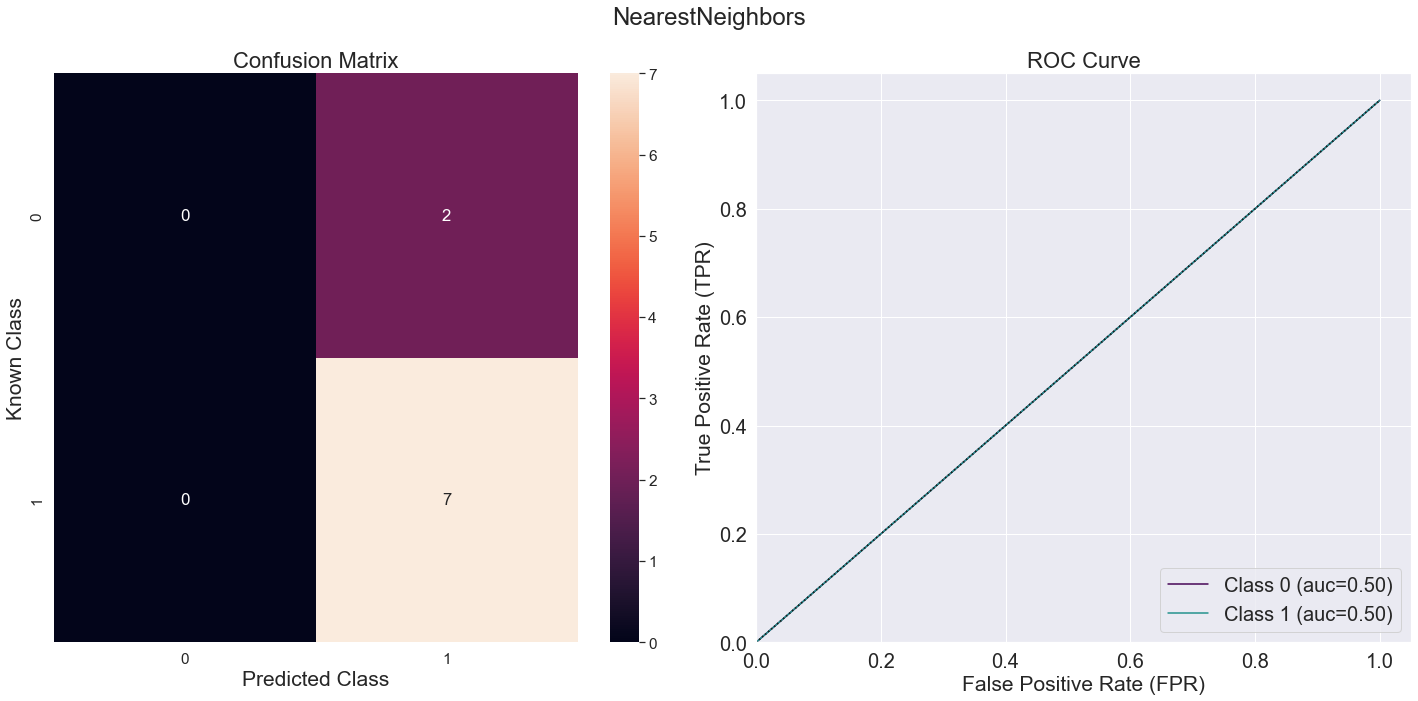

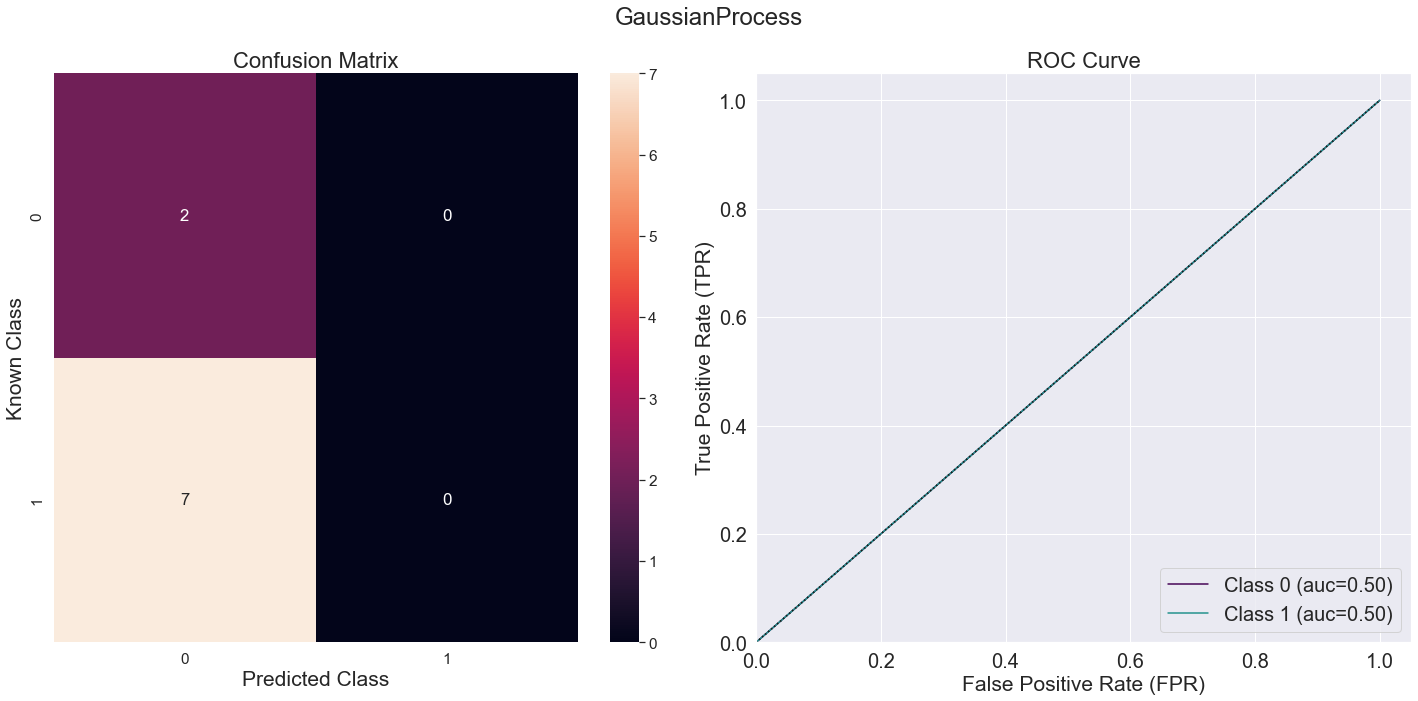

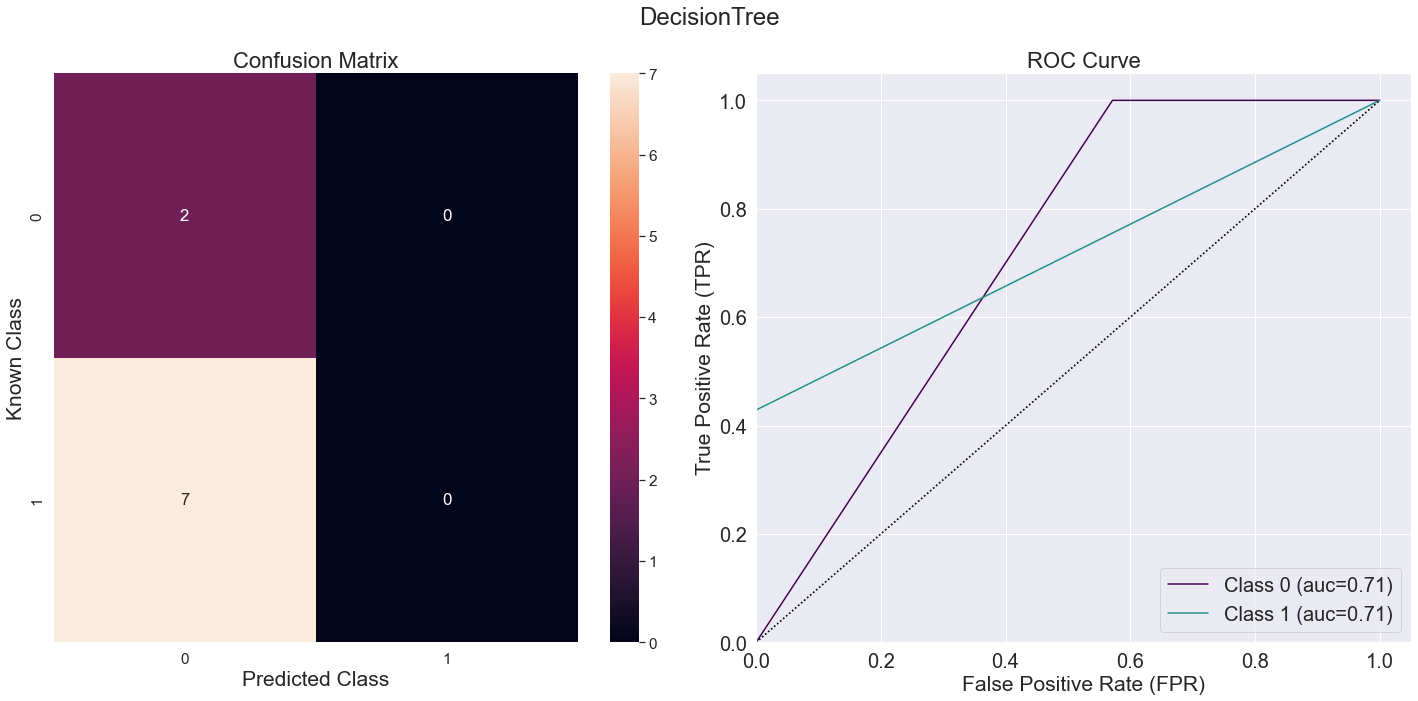

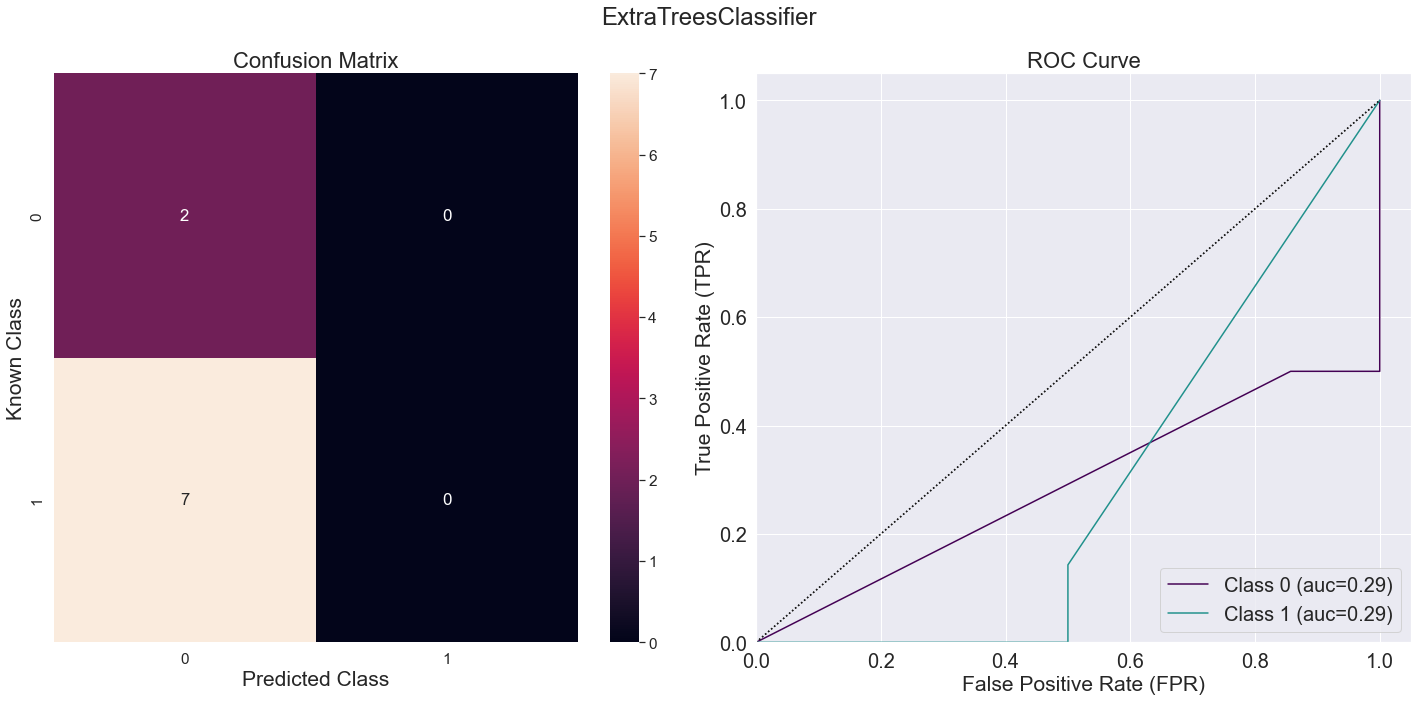

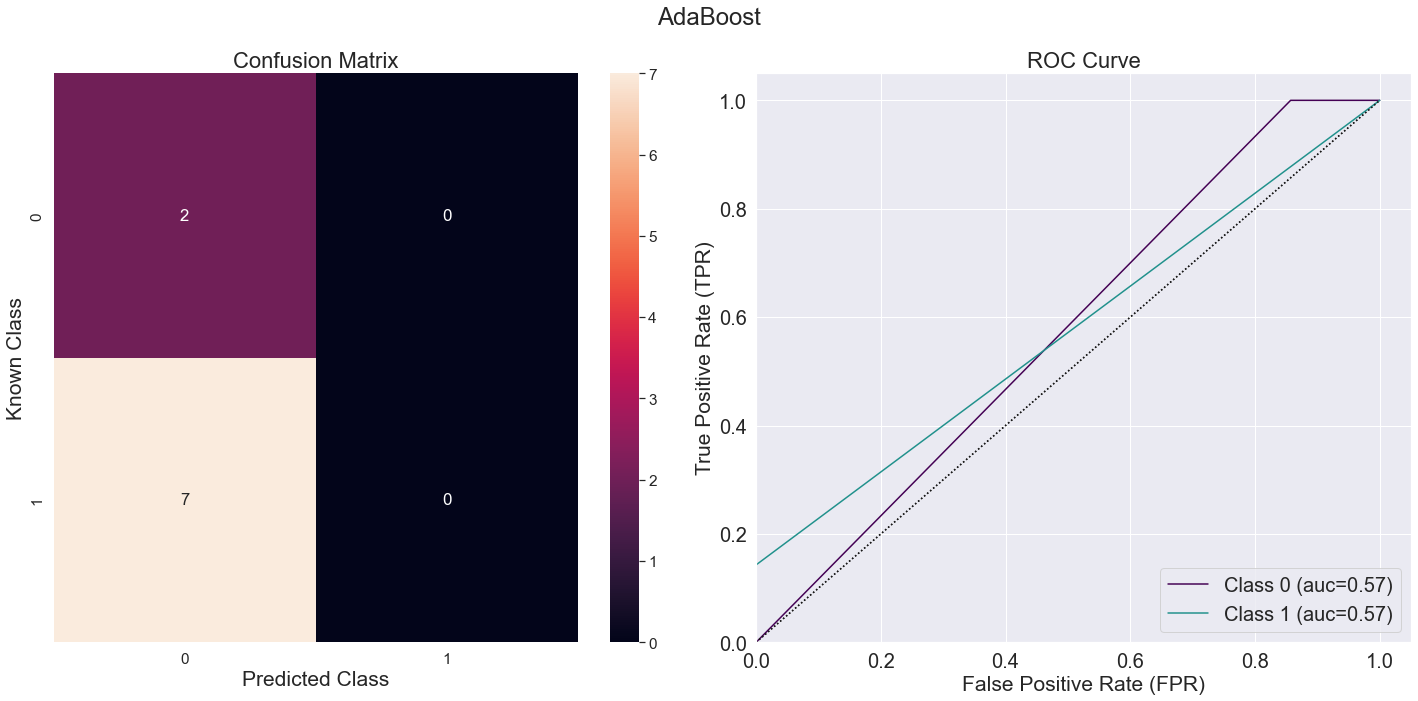

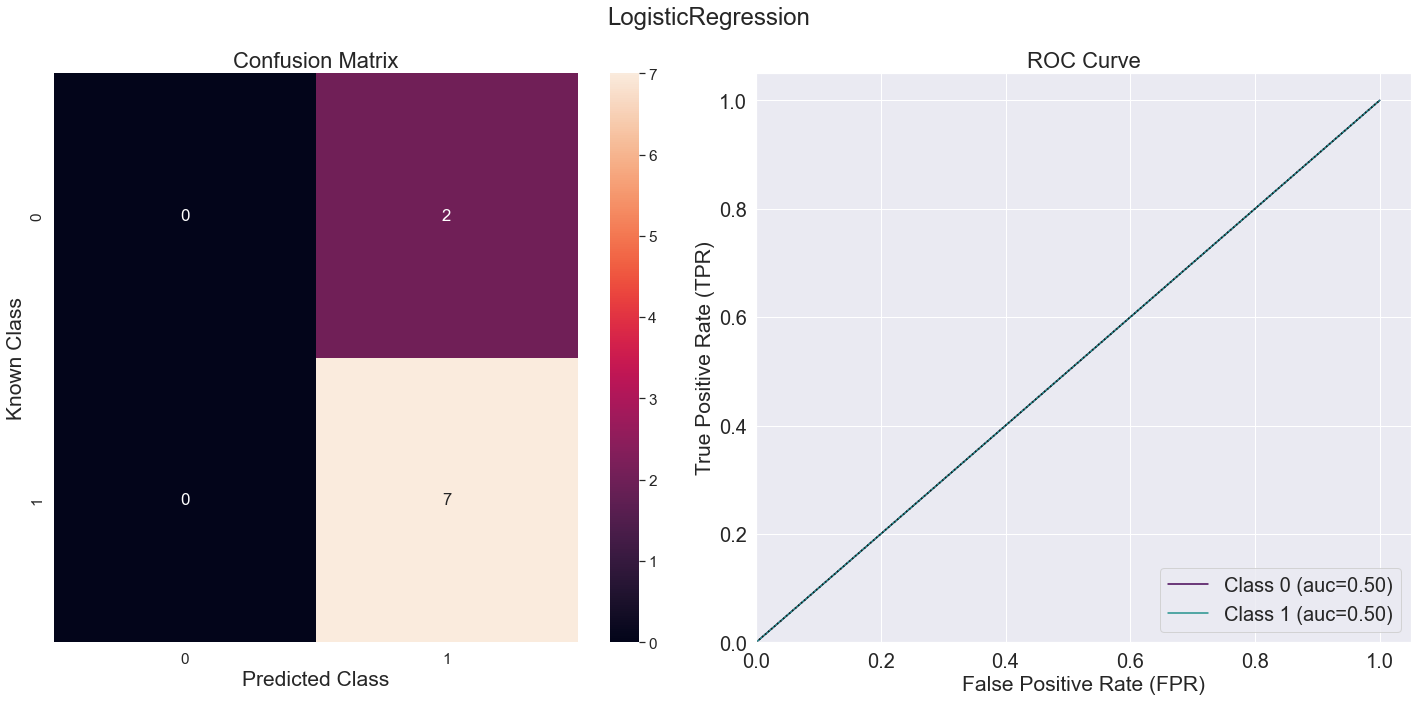

In [103]:
files_plt = []

kfold_clf_names = ["NearestNeighbors", "GaussianProcess",
         "DecisionTree", "ExtraTreesClassifier", "AdaBoost",
         "LogisticRegression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = cwf.build_data_from_directory(dirname, max_folds=1)
    
#     log.debug("Last value in the data frame: {}".format(data[165:166]))
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_morderd.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_mordred.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
log.info(df_metrics_for_paper.to_latex())

In [104]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_mordred.png")

Combining 6 images
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
New image will be W:1440 H:4320
Image 0 added at offset height 0
Image 1 added at offset height 720
Image 2 added at offset height 1440
Image 3 added at offset height 2160
Image 4 added at offset height 2880
Image 5 added at offset height 3600


In [105]:
cwf.which_are_misclassified(data, known_column_label="known", predicted_column_label="prediction", return_indx=False)

         known  prediction  prob0  prob1
m_index                                 
0          1.0         1.0    0.0    1.0
1          1.0         1.0    0.0    1.0
2          1.0         1.0    0.0    1.0
3          0.0         1.0    0.0    1.0
4          1.0         1.0    0.0    1.0
5          1.0         1.0    0.0    1.0
6          1.0         1.0    0.0    1.0
7          1.0         1.0    0.0    1.0
8          0.0         1.0    0.0    1.0


known  prediction  prob0  prob1
m_index                                 
3          0.0         1.0    0.0    1.0
8          0.0         1.0    0.0    1.0